In [9]:
import pandas as pd
import numpy as np
import matplotlib as plt
import scipy.stats


import joblib
import time

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV


from sklearn.svm import SVC
import xlrd
import pandas as pd
import numpy as np
import openpyxl
from nltk import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, cohen_kappa_score, f1_score
import torch
import tensorflow as tf
from transformers import AutoTokenizer, AutoModel, TrainingArguments, Trainer, AutoModelForSequenceClassification, EarlyStoppingCallback


from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB



from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn import metrics

from sklearn import metrics
from statsmodels.stats.inter_rater import fleiss_kappa




# Evaluation 

Creation of results and visuals

### Supervised Models

In [10]:
## Compare results of Berts and ML models on the pka and first round questions

In [11]:
bert_predictions = pd.read_excel('Evalution_data/total_predictions_bert.xlsx')

In [12]:
bert_predictions_h = pd.read_excel('Evalution_data/total_predictions_with_h.xlsx')
ML_predictions = pd.read_excel('Evalution_data/full_predictions_ML.xlsx')

In [13]:
bert_predictions = bert_predictions.drop(columns =['Unnamed: 0'])

In [14]:
bert_predictions_h = bert_predictions_h.drop(columns =['Unnamed: 0'])
ML_predictions = ML_predictions.drop(columns =['Unnamed: 0'])

In [15]:
ML_predictions


question  label  question_ID  \
0   In this reaction  which compound acts as the r...      2           34   
1   Consider a scenario where Compound C is oxidiz...      1           32   
2   In the context of biological redox reactions  ...      0           27   
3   Which assumption is necessary for biologists' ...      3           36   
4   Which of the following best describes the role...      2           35   
..                                                ...    ...          ...   
75  A molecule has a functional group with a pKa o...      3           23   
76  Which statement best predicts the behavior of ...      0           24   
77  A scientist is studying a biomolecule with a c...      1           25   
78  If the enzyme is placed in a solution with a p...      2           26   
79  A protein contains a carboxylic acid functiona...      3           27   

    gaussian_pred  SVM_pred  lr_pred  rf_pred  xgb_pred  
0               0         0        1        0         0  
1               0         0        2        0         1  
2               0         0        1        0         2  
3               1         0        2        0         1  
4               0         0        1        0         0  
..            ...       ...      ...      ...       ...  
75              0         2        1        0         1  
76              0         0        1        0         1  
77              0         2        1        0         1  
78              0         2        2        0         2  
79              0         2        1        0         2  

[80 rows x 8 columns]

In [16]:
def performancePrinter(test_y, pred_y, y_prob=None):
    # Print accuracy score
    print("Accuracy Score -> ", accuracy_score(test_y, pred_y))
    
    # Print Cohen's Kappa Score
    print("Kappa Score -> ", cohen_kappa_score(test_y, pred_y))
    
    # Check if ROC AUC can be calculated (requires probability scores)
    if y_prob is not None:
        try:
            # Calculate ROC AUC score for multi-class classification
            print("ROC AUC Score -> ", roc_auc_score(test_y, y_prob, multi_class='ovr', average='macro'))
        except ValueError as e:
            print(f"Error calculating ROC AUC Score: {e}")
    else:
        print("ROC AUC Score -> Cannot calculate (probability scores required)")
    
    # Print F1 Score with macro averaging for multi-class classification
    print("F1 Score -> ", f1_score(test_y, pred_y, average='macro'))
    
    # Print classification report
    print("Classification report -> \n", classification_report(test_y, pred_y))


    # Create DataFrame from true and predicted labels
    ratings_df = pd.DataFrame({
        'True': test_y,
        'Predicted': pred_y
    })
    
    # Create a contingency table for Fleiss' Kappa
    num_classes = len(np.unique(test_y))
    contingency_table = pd.DataFrame(np.zeros((len(test_y), num_classes), dtype=int))
    
    for i in range(len(test_y)):
        true_label = test_y[i]
        pred_label = pred_y[i]
        contingency_table.loc[i, true_label] += 1
        contingency_table.loc[i, pred_label] += 1

    # Compute Fleiss' Kappa
    try:
        kappa_fleiss = fleiss_kappa(contingency_table)
        print(f"Fleiss' Kappa -> {kappa_fleiss}")
    except Exception as e:
        print(f"Error calculating Fleiss' Kappa: {e}")

In [17]:
## Show the performance results for all models

In [18]:
performancePrinter (bert_predictions['label'], bert_predictions['predicted_label'])

Accuracy Score ->  0.38392857142857145
Kappa Score ->  0.1785714285714286
ROC AUC Score -> Cannot calculate (probability scores required)
F1 Score ->  0.3376625525545853
Classification report -> 
               precision    recall  f1-score   support

           0       0.47      0.64      0.55        28
           1       0.12      0.07      0.09        28
           2       0.37      0.68      0.48        28
           3       0.67      0.14      0.24        28

    accuracy                           0.38       112
   macro avg       0.41      0.38      0.34       112
weighted avg       0.41      0.38      0.34       112

Fleiss' Kappa -> 0.15072256717402055


In [19]:
performancePrinter(ML_predictions['label'], ML_predictions['gaussian_pred'])

Accuracy Score ->  0.275
Kappa Score ->  0.033333333333333326
ROC AUC Score -> Cannot calculate (probability scores required)
F1 Score ->  0.149906015037594
Classification report -> 
               precision    recall  f1-score   support

           0       0.27      1.00      0.42        20
           1       0.25      0.05      0.08        20
           2       1.00      0.05      0.10        20
           3       0.00      0.00      0.00        20

    accuracy                           0.28        80
   macro avg       0.38      0.28      0.15        80
weighted avg       0.38      0.28      0.15        80

Fleiss' Kappa -> -0.2244359414170735


/opt/anaconda3/envs/Diss/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/Diss/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/Diss/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [20]:
performancePrinter(ML_predictions['label'], ML_predictions['SVM_pred'])

Accuracy Score ->  0.2875
Kappa Score ->  0.050000000000000044
ROC AUC Score -> Cannot calculate (probability scores required)
F1 Score ->  0.20855572998430139
Classification report -> 
               precision    recall  f1-score   support

           0       0.31      0.70      0.43        20
           1       0.17      0.05      0.08        20
           2       0.28      0.40      0.33        20
           3       0.00      0.00      0.00        20

    accuracy                           0.29        80
   macro avg       0.19      0.29      0.21        80
weighted avg       0.19      0.29      0.21        80

Fleiss' Kappa -> -0.01910828025477716


/opt/anaconda3/envs/Diss/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/Diss/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/Diss/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [21]:
performancePrinter(ML_predictions['label'], ML_predictions['lr_pred'])

Accuracy Score ->  0.275
Kappa Score ->  0.033333333333333326
ROC AUC Score -> Cannot calculate (probability scores required)
F1 Score ->  0.21109164669002398
Classification report -> 
               precision    recall  f1-score   support

           0       0.11      0.05      0.07        20
           1       0.25      0.70      0.36        20
           2       0.50      0.35      0.41        20
           3       0.00      0.00      0.00        20

    accuracy                           0.28        80
   macro avg       0.21      0.28      0.21        80
weighted avg       0.21      0.28      0.21        80

Fleiss' Kappa -> -0.07444714599976843


/opt/anaconda3/envs/Diss/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/Diss/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/Diss/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [22]:
performancePrinter(ML_predictions['label'], ML_predictions['rf_pred'])

Accuracy Score ->  0.2625
Kappa Score ->  0.01666666666666672
ROC AUC Score -> Cannot calculate (probability scores required)
F1 Score ->  0.12690230731467844
Classification report -> 
               precision    recall  f1-score   support

           0       0.26      1.00      0.41        20
           1       0.00      0.00      0.00        20
           2       1.00      0.05      0.10        20
           3       0.00      0.00      0.00        20

    accuracy                           0.26        80
   macro avg       0.31      0.26      0.13        80
weighted avg       0.31      0.26      0.13        80

Fleiss' Kappa -> -0.27001210816628535


/opt/anaconda3/envs/Diss/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/Diss/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/Diss/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [23]:
performancePrinter(ML_predictions['label'], ML_predictions['xgb_pred'])

Accuracy Score ->  0.3125
Kappa Score ->  0.08333333333333337
ROC AUC Score -> Cannot calculate (probability scores required)
F1 Score ->  0.26778074866310164
Classification report -> 
               precision    recall  f1-score   support

           0       0.36      0.45      0.40        20
           1       0.29      0.35      0.32        20
           2       0.29      0.45      0.35        20
           3       0.00      0.00      0.00        20

    accuracy                           0.31        80
   macro avg       0.24      0.31      0.27        80
weighted avg       0.24      0.31      0.27        80

Fleiss' Kappa -> 0.05569267088743425


/opt/anaconda3/envs/Diss/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/Diss/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/Diss/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [24]:
## Accuracy on Testing Sets
## XGB boost Accuracy on test set .83
## RF accuracy on test set .81
## LR accuracy on test set .80
## SVM accuracy on test set .75
## Gaussian accuracy on test set .58


| Model | Accuracy | Kappa Score | F1 Score |
| --- | --- | --- | --- |
| BERT |**.38** | **.18** | **.34** |
| Naive Bayes | .25 | .03 | .15 |
| Support Vector Machine | .29 | .05 | .21 |
| Logistic Regression | .28 | .03 | .21 |
| Random Forest | .26 | .02 | .13 |
| XGBoost | .31| .08 | .27 |

In [25]:
# Want information about the average number of words
# Our generated questions
generated_questions = pd.read_excel('Evalution_data/all_generated_questions.xlsx')
# The combined training set
training_questions = pd.read_excel('Evalution_data/combined_questions.xlsx')

In [26]:
generated_questions

Unnamed: 0                                           question  label  \
0            0  In this reaction  which compound acts as the r...      2   
1            1  Consider a scenario where Compound C is oxidiz...      1   
2            2  In the context of biological redox reactions  ...      0   
3            3  Which assumption is necessary for biologists' ...      3   
4            4  Which of the following best describes the role...      2   
..         ...                                                ...    ...   
75          75  A molecule has a functional group with a pKa o...      3   
76          76  Which statement best predicts the behavior of ...      0   
77          77  A scientist is studying a biomolecule with a c...      1   
78          78  If the enzyme is placed in a solution with a p...      2   
79          79  A protein contains a carboxylic acid functiona...      3   

    question_ID  
0            34  
1            32  
2            27  
3            36  
4            35  
..          ...  
75           23  
76           24  
77           25  
78           26  
79           27  

[80 rows x 4 columns]

In [27]:
mean_wc_training = pd.Series(training_questions['question']).apply(len).mean()
print(mean_wc_training)

65.98316912972085


In [28]:
mean_wc_generated = pd.Series(generated_questions['question']).apply(len).mean()
print(mean_wc_generated)

133.5


## Human Evaluation

In [29]:
question_evaluation_secondary = pd.read_excel('Evalution_data/fullQuestionEvalSecondary.xlsx')

In [30]:
question_evaluation_secondary.columns

Index(['Unnamed: 0', 'participant_ID', 'question_ID', 'LG_Progress',
       'Relevant', 'Correct_Info', 'Grammatical', 'Enough_Info',
       'Correct_Marked', 'One_Correct', 'Distinct_Option', 'Plausible',
       'Misconceptions', 'Usable', 'Teacher_Blooms', 'objective', 'strategy',
       'scenario', 'question', 'options', 'correct_answer', 'explanation',
       'textbook_section', 'analysis', 'Learning Goal'],
      dtype='object')

In [31]:
question_evaluation_secondary['objective']

0           Applying
1           Applying
2           Applying
3      Understanding
4      Understanding
           ...      
123    Understanding
124         Applying
125         Applying
126        Analyzing
127        Analyzing
Name: objective, Length: 128, dtype: object

In [32]:
question_evaluation_secondary['Teacher_Blooms'].unique()

array([2, 1, 3, 4])

In [33]:
mapping = {
    'Remembering': 1,
    'Understanding': 2,
    'Applying': 3,
    'Analyzing': 4
}
question_evaluation_secondary['objective'] = question_evaluation_secondary['objective'].map(mapping)


In [34]:
performancePrinter(question_evaluation_secondary['objective'], question_evaluation_secondary['Teacher_Blooms'])

Accuracy Score ->  0.3828125
Kappa Score ->  0.17708333333333337
ROC AUC Score -> Cannot calculate (probability scores required)
F1 Score ->  0.3279702939297925
Classification report -> 
               precision    recall  f1-score   support

           1       0.43      0.72      0.54        32
           2       0.27      0.38      0.31        32
           3       0.48      0.44      0.46        32
           4       0.00      0.00      0.00        32

    accuracy                           0.38       128
   macro avg       0.30      0.38      0.33       128
weighted avg       0.30      0.38      0.33       128



KeyError: 4

In [ ]:
# Check fleiss' kappa

# Find unique ratings
all_ratings = pd.concat([question_evaluation_secondary['objective'], question_evaluation_secondary['Teacher_Blooms']])
num_ratings = all_ratings.max()

# Create a matrix where each row represents an item and each column represents a rating category
ratings_matrix = pd.DataFrame({
    'Objective': question_evaluation_secondary['objective'],
    'Teacher_Blooms': question_evaluation_secondary['Teacher_Blooms']
})

# Convert the ratings to a count matrix
count_matrix = pd.DataFrame(np.zeros((ratings_matrix.shape[0], num_ratings), dtype=int),
                            index=ratings_matrix.index)

for i in ratings_matrix.index:
    counts = ratings_matrix.loc[i].value_counts()
    for rating, count in counts.items():
        count_matrix.loc[i, int(rating) - 1] = count

# Compute Fleiss' Kappa
kappa_fleiss = fleiss_kappa(count_matrix)
print(f"Fleiss' Kappa: {kappa_fleiss}")

In [35]:
question_evaluation_secondary['objective']

0      3
1      3
2      3
3      2
4      2
      ..
123    2
124    3
125    3
126    4
127    4
Name: objective, Length: 128, dtype: int64

In [36]:
pip install plotly


Note: you may need to restart the kernel to use updated packages.


In [37]:
import pandas as pd
import plotly.graph_objects as go


In [38]:
df_flow = first_round.groupby(['objective', 'Teacher_Blooms']).size().reset_index(name='count')

# Define the labels (1 to 4) and their names
labels = ['Remembering', 'Understanding', 'Applying', 'Analyzing']

# Create source and target lists
source = df_flow['objective'] - 1  # Adjusting for zero-based indexing in plotly
target = df_flow['Teacher_Blooms'] + len(labels) - 1  # Adding an offset to target indices
value = df_flow['count']

In [39]:
df_flow['objective'] = pd.Categorical(df_flow['objective'], [1,2, 3, 4])

In [40]:
df_flow['objective'] = pd.Categorical(df_flow['objective'], [1,2, 3, 4])
df_flow['Teacher_Blooms'] = pd.Categorical(df_flow['Teacher_Blooms'], [1,2,3,4])
df_flow.sort_values(['objective','Teacher_Blooms'],inplace=True)
df_flow.reset_index(drop=True)


objective Teacher_Blooms  count
0         1              1      7
1         1              2      1
2         1              3      4
3         2              1      1
4         2              2      5
5         2              3      6
6         3              3     12
7         4              2      1
8         4              3      8
9         4              4      3

In [41]:
source

0    0
1    0
2    0
3    1
4    1
5    1
6    2
7    3
8    3
9    3
Name: objective, dtype: int64

In [42]:
import plotly.graph_objects as go
import pandas as pd

# Define colors for each objective value with lighter opacity for the flows
flow_color_map = {
    0: 'rgba(31, 119, 180, 0.5)',  # Lighter blue
    1: 'rgba(255, 127, 14, 0.5)',  # Lighter orange
    2: 'rgba(44, 160, 44, 0.5)',   # Lighter green
    3: 'rgba(214, 39, 40, 0.5)'    # Lighter red
}

# Define solid colors for nodes
node_color_map = {
    0: 'rgb(31, 119, 180)',  # Solid blue
    1: 'rgb(255, 127, 14)',  # Solid orange
    2: 'rgb(44, 160, 44)',   # Solid green
    3: 'rgb(214, 39, 40)'    # Solid red
}

# Apply colors to links based on the source
link_colors = [flow_color_map[src-1] for src in source]

# Apply colors to nodes based on the source/target (assuming source and target are aligned)
node_colors = [node_color_map[src] for src in range(len(labels))]

# Create the Sankey diagram with labels
fig = go.Figure(go.Sankey(
    arrangement='snap',
    node=dict(
        pad=5,
        thickness=20,
        line=dict(color="black", width=0),
        label=labels *2,  # Duplicating the labels for both source and target
         x = [0.001, 0.001, 0.001, 0.001, 0.999, 0.999, 0.999, 0.999],
          y = [0.001, 75/285, 160/285, 190/285, 0.001, 75/285, 130/285, 215/285], 
        color=node_colors + node_colors  # Set the node color to the solid version of the objective colors
    ),
    link=dict(
        source=source.to_list(),  # Indices correspond to source
        target=target.to_list(),  # Indices correspond to target
        value=value.to_list(),
        color=link_colors,  # Apply the lighter colors based on the source objective
        customdata=value,  # Pass the flow values for labeling
        hovertemplate='Value: %{value}<br>Source: %{source.label}<br>Target: %{target.label}<extra></extra>',  # Customize hover info
        label=labels  # This automatically labels the lines with the respective values
    )
))

# Update the layout to make the diagram narrower and boxes white
fig.update_layout(
    title_text="Generated Bloom's Levels to Teacher Predictions",
    font=dict(size=12, color='black', family = 'Times New Roman'),
    title_x=0.5,  # Center the title
    title_y=0.85,  # Adjust the vertical position of the title
    width=600,  # Adjust this value to make the diagram narrower
    height=400,  # You can adjust the height as needed
    annotations=[
        dict(
            x=-0.1,
            y=-0.1,
            xref='paper',
            yref='paper',
            text='LLM-level',
            showarrow=False,
            font=dict(size=12, color='black'),
            align='center'
        ),
        dict(
            x=1.1,
            y=-0.1,
            xref='paper',
            yref='paper',
            text='Teacher-Level',
            showarrow=False,
            font=dict(size=12, color='black'),
            align='center'
        )
    ],
    paper_bgcolor='rgba(255,255,255,0)',  # Set background to white
    plot_bgcolor='rgba(255,255,255,0)'  # Set plot background to white
)

# Show the diagram
fig.show()


KeyError: -1

In [43]:
df_flow2 = second_round.groupby(['objective', 'Teacher_Blooms']).size().reset_index(name='count')

# Define the labels (1 to 4) and their names
labels = ['Remembering', 'Understanding', 'Applying', 'Analyzing']

# Create source and target lists
source2 = df_flow2['objective'] - 1  # Adjusting for zero-based indexing in plotly
target2 = df_flow2['Teacher_Blooms'] + len(labels) - 1  # Adding an offset to target indices
value2 = df_flow2['count']

df_flow2['objective'] = pd.Categorical(df_flow2['objective'], [1,2, 3, 4])
df_flow2['Teacher_Blooms'] = pd.Categorical(df_flow2['Teacher_Blooms'], [1,2,3,4])
df_flow2.sort_values(['objective','Teacher_Blooms'],inplace=True)
df_flow2.reset_index(drop=True)

KeyError: 'objective'

In [ ]:
import plotly.graph_objects as go
import pandas as pd

# Define colors for each objective value with lighter opacity for the flows
flow_color_map = {
    0: 'rgba(31, 119, 180, 0.5)',  # Lighter blue
    1: 'rgba(255, 127, 14, 0.5)',  # Lighter orange
    2: 'rgba(44, 160, 44, 0.5)',   # Lighter green
    3: 'rgba(214, 39, 40, 0.5)'    # Lighter red
}

# Define solid colors for nodes
node_color_map = {
    0: 'rgb(31, 119, 180)',  # Solid blue
    1: 'rgb(255, 127, 14)',  # Solid orange
    2: 'rgb(44, 160, 44)',   # Solid green
    3: 'rgb(214, 39, 40)'    # Solid red
}

# Apply colors to links based on the source
link_colors = [flow_color_map[src] for src in source]

# Apply colors to nodes based on the source/target (assuming source and target are aligned)
node_colors = [node_color_map[src] for src in range(len(labels))]

# Create the Sankey diagram with labels
fig = go.Figure(go.Sankey(
    arrangement='snap',
    node=dict(
        pad=5,
        thickness=20,
        line=dict(color="black", width=0),
        label=labels *2,  # Duplicating the labels for both source and target
         x = [0.001, 0.001, 0.001, 0.001, 0.999, 0.999, 0.999, 0.999],
          y = [0.001, 75/285, 160/285, 190/285, 0.001, 75/285, 130/285, 215/285], 
        color=node_colors + node_colors  # Set the node color to the solid version of the objective colors
    ),
    link=dict(
        source=source2.to_list(),  # Indices correspond to source
        target=target2.to_list(),  # Indices correspond to target
        value=value2.to_list(),
        color=link_colors,  # Apply the lighter colors based on the source objective
        customdata=value2,  # Pass the flow values for labeling
        hovertemplate='Value: %{value}<br>Source: %{source.label}<br>Target: %{target.label}<extra></extra>',  # Customize hover info
        label=labels  # This automatically labels the lines with the respective values
    )
))

# Update the layout to make the diagram narrower and boxes white
fig.update_layout(
    title_text="Generated Bloom's Levels to Teacher Predictions",
    font=dict(size=12, color='black', family = 'Times New Roman'),
    title_x=0.5,  # Center the title
    title_y=0.85,  # Adjust the vertical position of the title
    width=600,  # Adjust this value to make the diagram narrower
    height=400,  # You can adjust the height as needed
    annotations=[
        dict(
            x=-0.1,
            y=-0.1,
            xref='paper',
            yref='paper',
            text='LLM-level',
            showarrow=False,
            font=dict(size=12, color='black'),
            align='center'
        ),
        dict(
            x=1.1,
            y=-0.1,
            xref='paper',
            yref='paper',
            text='Teacher-Level',
            showarrow=False,
            font=dict(size=12, color='black'),
            align='center'
        )
    ],
    paper_bgcolor='rgba(255,255,255,0)',  # Set background to white
    plot_bgcolor='rgba(255,255,255,0)'  # Set plot background to white
)

# Show the diagram
fig.show()


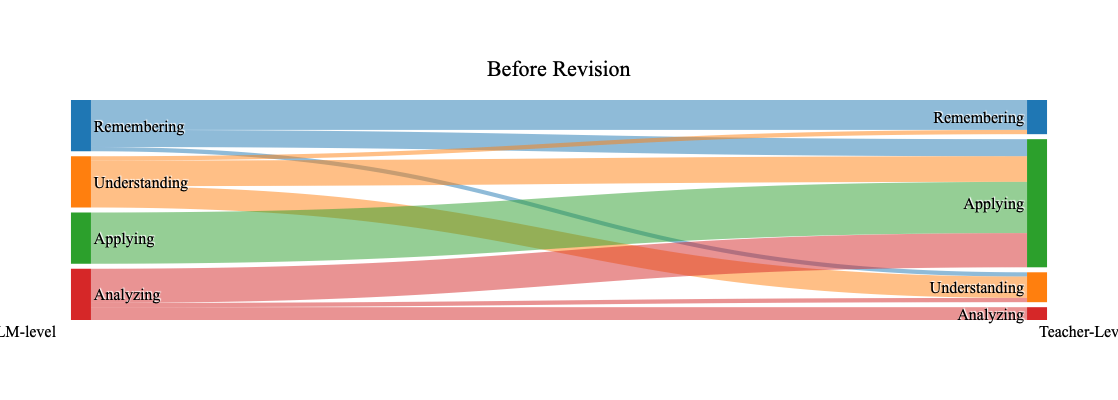

In [44]:
import plotly.graph_objects as go
import pandas as pd

# Define colors for each objective value with lighter opacity for the flows
flow_color_map = {
    0: 'rgba(31, 119, 180, 0.5)',  # Lighter blue
    1: 'rgba(255, 127, 14, 0.5)',  # Lighter orange
    2: 'rgba(44, 160, 44, 0.5)',   # Lighter green
    3: 'rgba(214, 39, 40, 0.5)'    # Lighter red
}

# Define solid colors for nodes
node_color_map = {
    0: 'rgb(31, 119, 180)',  # Solid blue
    1: 'rgb(255, 127, 14)',  # Solid orange
    2: 'rgb(44, 160, 44)',   # Solid green
    3: 'rgb(214, 39, 40)'    # Solid red
}

# Apply colors to links based on the source
link_colors = [flow_color_map[src] for src in source]

# Apply colors to nodes based on the source/target (assuming source and target are aligned)
node_colors = [node_color_map[src] for src in range(len(labels))]

# Create the Sankey diagram with labels
fig = go.Figure(go.Sankey(
    arrangement='snap',
    node=dict(
        pad=5,
        thickness=20,
        line=dict(color="black", width=0),
        label=labels *2,  # Duplicating the labels for both source and target
         x = [0.001, 0.001, 0.001, 0.001, 0.999, 0.999, 0.999, 0.999],
          y = [0.001, 75/285, 160/285, 190/285, 0.001, 75/285, 130/285, 215/285], 
        color=node_colors + node_colors  # Set the node color to the solid version of the objective colors
    ),
    link=dict(
        source=source.to_list(),  # Indices correspond to source
        target=target.to_list(),  # Indices correspond to target
        value=value.to_list(),
        color=link_colors,  # Apply the lighter colors based on the source objective
        customdata=value,  # Pass the flow values for labeling
        hovertemplate='Value: %{value}<br>Source: %{source.label}<br>Target: %{target.label}<extra></extra>',  # Customize hover info
        label=labels  # This automatically labels the lines with the respective values
    )
))

# Update the layout to make the diagram narrower and boxes white
fig.update_layout(
    title_text="Before Revision",
    font=dict(size=16, color='black', family = 'Times New Roman'),
    title_x=0.5,  # Center the title
    title_y=0.85,  # Adjust the vertical position of the title
    width=600,  # Adjust this value to make the diagram narrower
    height=400,  # You can adjust the height as needed
    annotations=[
        dict(
            x=-0.1,
            y=-0.1,
            xref='paper',
            yref='paper',
            text='LLM-level',
            showarrow=False,
            font=dict(size=16, color='black'),
            align='center'
        ),
        dict(
            x=1.1,
            y=-0.1,
            xref='paper',
            yref='paper',
            text='Teacher-Level',
            showarrow=False,
            font=dict(size=16, color='black'),
            align='center'
        )
    ],
    paper_bgcolor='rgba(255,255,255,0)',  # Set background to white
    plot_bgcolor='rgba(255,255,255,0)'  # Set plot background to white
)

# Show the diagram
fig.show()


In [45]:
performancePrinter(first_round['objective'],first_round['Teacher_Blooms'])

Accuracy Score ->  0.5625
Kappa Score ->  0.41666666666666663
ROC AUC Score -> Cannot calculate (probability scores required)
F1 Score ->  0.549436090225564
Classification report -> 
               precision    recall  f1-score   support

           1       0.88      0.58      0.70        12
           2       0.71      0.42      0.53        12
           3       0.40      1.00      0.57        12
           4       1.00      0.25      0.40        12

    accuracy                           0.56        48
   macro avg       0.75      0.56      0.55        48
weighted avg       0.75      0.56      0.55        48



KeyError: 4

In [46]:
performancePrinter(second_round['objective'],second_round['Teacher_Blooms'])

KeyError: 'objective'

In [47]:
df_flow = second_round.groupby(['objective', 'Teacher_Blooms']).size().reset_index(name='count')

# Define the labels (1 to 4) and their names
labels = ['Remembering', 'Understanding', 'Applying', 'Analyzing']

# Create source and target lists
source = df_flow['objective'] - 1  # Adjusting for zero-based indexing in plotly
target = df_flow['Teacher_Blooms'] + len(labels) - 1  # Adding an offset to target indices
value = df_flow['count']
import plotly.graph_objects as go
import pandas as pd

# Define colors for each objective value with lighter opacity for the flows
flow_color_map = {
    0: 'rgba(31, 119, 180, 0.5)',  # Lighter blue
    1: 'rgba(255, 127, 14, 0.5)',  # Lighter orange
    2: 'rgba(44, 160, 44, 0.5)',   # Lighter green
    3: 'rgba(214, 39, 40, 0.5)'    # Lighter red
}

# Define solid colors for nodes
node_color_map = {
    0: 'rgb(31, 119, 180)',  # Solid blue
    1: 'rgb(255, 127, 14)',  # Solid orange
    2: 'rgb(44, 160, 44)',   # Solid green
    3: 'rgb(214, 39, 40)'    # Solid red
}

# Apply colors to links based on the source
link_colors = [flow_color_map[src] for src in source]

# Apply colors to nodes based on the source/target (assuming source and target are aligned)
node_colors = [node_color_map[src] for src in range(len(labels))]

# Create the Sankey diagram with labels
fig = go.Figure(go.Sankey(
    arrangement='snap',
    node=dict(
        pad=5,
        thickness=20,
        line=dict(color="black", width=0),
        label=labels *2,  # Duplicating the labels for both source and target
         x = [0.001, 0.001, 0.001, 0.001, 0.999, 0.999, 0.999, 0.999],
          y = [0.001, 75/285, 160/285, 190/285, 0.001, 75/285, 130/285, 215/285], 
        color=node_colors + node_colors  # Set the node color to the solid version of the objective colors
    ),
    link=dict(
        source=source.to_list(),  # Indices correspond to source
        target=target.to_list(),  # Indices correspond to target
        value=value.to_list(),
        color=link_colors,  # Apply the lighter colors based on the source objective
        customdata=value,  # Pass the flow values for labeling
        hovertemplate='Value: %{value}<br>Source: %{source.label}<br>Target: %{target.label}<extra></extra>',  # Customize hover info
        label=labels  # This automatically labels the lines with the respective values
    )
))

# Update the layout to make the diagram narrower and boxes white
fig.update_layout(
    title_text="After Revision",
    font=dict(size=16, color='black', family = 'Times New Roman'),
    title_x=0.5,  # Center the title
    title_y=0.85,  # Adjust the vertical position of the title
    width=600,  # Adjust this value to make the diagram narrower
    height=400,  # You can adjust the height as needed
    annotations=[
        dict(
            x=-0.1,
            y=-0.1,
            xref='paper',
            yref='paper',
            text='LLM-level',
            showarrow=False,
            font=dict(size=16, color='black'),
            align='center'
        ),
        dict(
            x=1.1,
            y=-0.1,
            xref='paper',
            yref='paper',
            text='Teacher-Level',
            showarrow=False,
            font=dict(size=16, color='black'),
            align='center'
        )
    ],
    paper_bgcolor='rgba(255,255,255,0)',  # Set background to white
    plot_bgcolor='rgba(255,255,255,0)'  # Set plot background to white
)

# Show the diagram
fig.show()


KeyError: 'objective'

In [48]:
import numpy as np
import pandas as pd
from scipy import stats

round1_remember_score=first_round[first_round['objective']==1]['quality_score'].to_list()
round1_understand_score=first_round[first_round['objective']==2]['quality_score'].to_list()
round1_apply_score=first_round[first_round['objective']==3]['quality_score'].to_list()
round1_analyze_score=first_round[first_round['objective']==4]['quality_score'].to_list()

round2_remember_score=second_round[second_round['objective']==1]['quality_score'].to_list()
round2_understand_score=second_round[second_round['objective']==2]['quality_score'].to_list()
round2_apply_score=second_round[second_round['objective']==3]['quality_score'].to_list()
round2_analyze_score=second_round[second_round['objective']==4]['quality_score'].to_list()

# Perform One-Way ANOVA
anova_result = stats.f_oneway(round1_remember_score, round2_remember_score)
print("ANOVA Result:")
print(f"F-statistic: {anova_result.statistic:.3f}")
print(f"P-value: {anova_result.pvalue:.3f}")

# Low p-value less than .05 so we can reject the null and there is a significant difference between groups
kruskal_result = stats.kruskal(round1_remember_score, round2_remember_score)

print("\nKruskal-Wallis Test Result:")
print(f"Chi-Square statistic: {kruskal_result.statistic:.3f}")
print(f"P-value: {kruskal_result.pvalue:.3f}")

KeyError: 'quality_score'

In [49]:
df_flow

objective Teacher_Blooms  count
0         1              1      7
1         1              2      1
2         1              3      4
3         2              1      1
4         2              2      5
5         2              3      6
6         3              3     12
7         4              2      1
8         4              3      8
9         4              4      3

In [50]:
df_flow

objective Teacher_Blooms  count
0         1              1      7
1         1              2      1
2         1              3      4
3         2              1      1
4         2              2      5
5         2              3      6
6         3              3     12
7         4              2      1
8         4              3      8
9         4              4      3

In [51]:
df_flow

objective Teacher_Blooms  count
0         1              1      7
1         1              2      1
2         1              3      4
3         2              1      1
4         2              2      5
5         2              3      6
6         3              3     12
7         4              2      1
8         4              3      8
9         4              4      3

In [52]:
target

0    4
1    5
2    6
3    4
4    5
5    6
6    6
7    5
8    6
9    7
Name: Teacher_Blooms, dtype: int64

In [53]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

# Define colors for each objective value with lighter opacity for the flows
flow_color_map = {
    0: 'rgba(31, 119, 180, 0.5)',  # Lighter blue
    1: 'rgba(255, 127, 14, 0.5)',  # Lighter orange
    2: 'rgba(44, 160, 44, 0.5)',   # Lighter green
    3: 'rgba(214, 39, 40, 0.5)'    # Lighter red
}

# Define solid colors for nodes
node_color_map = {
    0: 'rgb(31, 119, 180)',  # Solid blue
    1: 'rgb(255, 127, 14)',  # Solid orange
    2: 'rgb(44, 160, 44)',   # Solid green
    3: 'rgb(214, 39, 40)'    # Solid red
}

# Apply colors to links based on the source
link_colors = [flow_color_map[src] for src in source]

# Apply colors to nodes based on the source/target (assuming source and target are aligned)
node_colors = [node_color_map[src] for src in range(len(labels))]

# Create two Sankey diagrams
fig = make_subplots(rows=1, cols=2, 
                    subplot_titles=("Before Revision", "After Revision"),
                    horizontal_spacing=0.05)

# First diagram - Before Revision
fig.add_trace(go.Sankey(
    arrangement='snap',
    node=dict(
        pad=5,
        thickness=20,
        line=dict(color="black", width=0),
        label=labels *2,  # Duplicating the labels for both source and target
         x = [0.001, 0.001, 0.001, 0.001, 0.999, 0.999, 0.999, 0.999],
          y = [0.001, 75/285, 160/285, 190/285, 0.001, 75/285, 130/285, 215/285], 
        color=node_colors + node_colors  # Set the node color to the solid version of the objective colors
    ),
    link=dict(
        source=source.to_list(),  # Indices correspond to source
        target=target.to_list(),  # Indices correspond to target
        value=value.to_list(),
        color=link_colors,  # Apply the lighter colors based on the source objective
        customdata=value,  # Pass the flow values for labeling
        hovertemplate='Value: %{value}<br>Source: %{source.label}<br>Target: %{target.label}<extra></extra>',  # Customize hover info
        label=labels  # This automatically labels the lines with the respective values
    )
), row=1, col=1)

# Second diagram - After Revision
fig.add_trace(go.Sankey(
    arrangement='snap',
    node=dict(
        pad=5,
        thickness=20,
        line=dict(color="black", width=0),
        label=labels *2,  # Duplicating the labels for both source and target
         x = [0.001, 0.001, 0.001, 0.001, 0.999, 0.999, 0.999, 0.999],
          y = [0.001, 75/285, 160/285, 190/285, 0.001, 75/285, 130/285, 215/285], 
        color=node_colors + node_colors  # Set the node color to the solid version of the objective colors
    ),
    link=dict(
        source=source.to_list(),  # Indices correspond to source
        target=target.to_list(),  # Indices correspond to target
        value=value.to_list(),
        color=link_colors,  # Apply the lighter colors based on the source objective
        customdata=value,  # Pass the flow values for labeling
        hovertemplate='Value: %{value}<br>Source: %{source.label}<br>Target: %{target.label}<extra></extra>',  # Customize hover info
        label=labels  # This automatically labels the lines with the respective values
    )
), row=1, col=2)

# Update the layout to apply a global style
fig.update_layout(
    title_text="Generated Bloom's Levels Compared to Instructor Predictions",
    font=dict(size=12, color='black', family='Times New Roman'),
    title_x=0.5,  # Center the title
    title_y=0.9,  # Adjust the vertical position of the title
    width=1200,  # Adjust this value to control the overall width
    height=500,  # Adjust the height as needed
    annotations=[
        dict(
            x=-0.1,
            y=-0.1,
            xref='paper',
            yref='paper',
            text='LLM-level',
            showarrow=False,
            font=dict(size=12, color='black'),
            align='center'
        ),
        dict(
            x=1.1,
            y=-0.1,
            xref='paper',
            yref='paper',
            text='Teacher-Level',
            showarrow=False,
            font=dict(size=12, color='black'),
            align='center'
        )
    ],
    paper_bgcolor='rgba(255,255,255,0)',  # Set background to white
    plot_bgcolor='rgba(255,255,255,0)'  # Set plot background to white
)

# Show the diagram
fig.show()


ValueError: Trace type 'sankey' is not compatible with subplot type 'xy'
at grid position (1, 1)

See the docstring for the specs argument to plotly.subplots.make_subplots
for more information on subplot types

In [ ]:
source.to_list()


In [ ]:
labels

In [54]:
target

0    4
1    5
2    6
3    4
4    5
5    6
6    6
7    5
8    6
9    7
Name: Teacher_Blooms, dtype: int64

In [55]:
d = {'source':['Formal','Formal','Formal','Formal','Informal','Informal','Informal','Informal','Unemployed','Unemployed',
     'Unemployed','Unemployed','Inactive','Inactive','Inactive','Inactive'],'destination':['Formal','Informal','Unemployed', 'Inactive',
                                                                                           'Formal','Informal','Unemployed', 'Inactive',
                                                                                           'Formal','Informal','Unemployed', 'Inactive',
                                                                                           'Formal','Informal','Unemployed', 'Inactive'],
     'value':[20,10,30,15,20,15,25,25,5,10,10,5,30,20,20,25]}


In [56]:
df = pd.DataFrame(data=d)

In [57]:
df

source destination  value
0       Formal      Formal     20
1       Formal    Informal     10
2       Formal  Unemployed     30
3       Formal    Inactive     15
4     Informal      Formal     20
5     Informal    Informal     15
6     Informal  Unemployed     25
7     Informal    Inactive     25
8   Unemployed      Formal      5
9   Unemployed    Informal     10
10  Unemployed  Unemployed     10
11  Unemployed    Inactive      5
12    Inactive      Formal     30
13    Inactive    Informal     20
14    Inactive  Unemployed     20
15    Inactive    Inactive     25

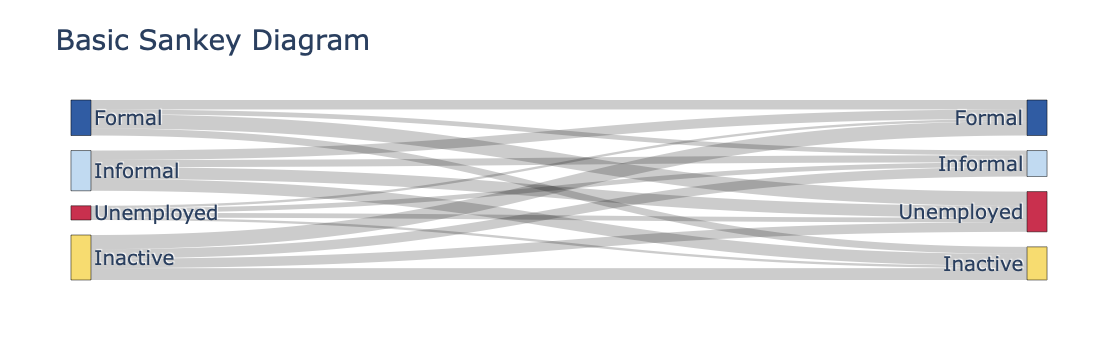

In [58]:
#Sort by Source and then Destination
df['source'] = pd.Categorical(df['source'], ['Formal','Informal', 'Unemployed', 'Inactive'])
df['destination'] = pd.Categorical(df['destination'], ['Formal','Informal', 'Unemployed', 'Inactive'])
df.sort_values(['source', 'destination'], inplace = True)
df.reset_index(drop=True)

mynode = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = ['Formal', 'Informal', 'Unemployed', 'Inactive', 'Formal', 'Informal', 'Unemployed', 'Inactive'],
      x = [0.001, 0.001, 0.001, 0.001, 0.999, 0.999, 0.999, 0.999],
      y = [0.001, 75/285, 160/285, 190/285, 0.001, 75/285, 130/285, 215/285], 
      color = ["#305CA3", "#C1DAF1", "#C9304E", "#F7DC70", "#305CA3", "#C1DAF1", "#C9304E", "#F7DC70"])

mylink = dict(
    source = [ 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3 ], 
    target = [ 4, 5, 6, 7, 4, 5, 6, 7, 4, 5, 6, 7, 4, 5, 6, 7 ],
    value = df.value.to_list())

fig = go.Figure(data=[go.Sankey(
    arrangement='snap',
    node = mynode,
    link = mylink
)])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=20)
fig.show()

In [59]:
first_round['objective']

0     2
1     2
2     2
3     3
4     3
5     3
6     4
7     4
8     4
9     1
10    1
11    1
12    1
13    1
14    1
15    2
16    2
17    2
18    3
19    3
20    3
21    4
22    4
23    4
24    2
25    2
26    2
27    1
28    1
29    1
30    3
31    3
32    3
33    4
34    4
35    4
36    1
37    1
38    1
39    2
40    2
41    2
42    3
43    3
44    3
45    4
46    4
47    4
Name: objective, dtype: int64

In [60]:
first_round['Teacher_Blooms

SyntaxError: unterminated string literal (detected at line 1) (3175556751.py, line 1)

In [61]:
##Experiment 2 Sankey


df_flow['objective'] = pd.Categorical(df_flow['objective'], [1,2, 3, 4])
df_flow['Teacher_Blooms'] = pd.Categorical(df_flow['Teacher_Blooms'], [1,2,3,4])
df_flow.sort_values(['objective','Teacher_Blooms'],inplace=True)
df_flow.reset_index(drop=True)

objective Teacher_Blooms  count
0         1              1      7
1         1              2      1
2         1              3      4
3         2              1      1
4         2              2      5
5         2              3      6
6         3              3     12
7         4              2      1
8         4              3      8
9         4              4      3

In [62]:
## Next Step: Separate LG questions and no LG questions
# Calculate their performance

question_evaluation_secondary['LG_Progress'].unique()

array([nan,  1.,  2.,  0.])

In [63]:
# Create DataFrame for rows where 'LG_Progress' is NaN
no_LG = question_evaluation_secondary[question_evaluation_secondary['LG_Progress'].isna()]

# Create DataFrame for rows where 'LG_Progress' is not NaN
with_LG = question_evaluation_secondary[question_evaluation_secondary['LG_Progress'].notna()]


In [64]:
len(with_LG['question_ID'].unique())

16

In [65]:
performancePrinter(no_LG['objective'], no_LG['Teacher_Blooms'])

Accuracy Score ->  0.3958333333333333
Kappa Score ->  0.19444444444444442
ROC AUC Score -> Cannot calculate (probability scores required)
F1 Score ->  0.335656321440113
Classification report -> 
               precision    recall  f1-score   support

           1       0.44      0.79      0.57        24
           2       0.26      0.38      0.31        24
           3       0.53      0.42      0.47        24
           4       0.00      0.00      0.00        24

    accuracy                           0.40        96
   macro avg       0.31      0.40      0.34        96
weighted avg       0.31      0.40      0.34        96



/opt/anaconda3/envs/Diss/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/anaconda3/envs/Diss/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/anaconda3/envs/Diss/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



KeyError: 4

In [66]:
performancePrinter(with_LG['objective'], with_LG['Teacher_Blooms'])

Accuracy Score ->  0.34375
Kappa Score ->  0.125
ROC AUC Score -> Cannot calculate (probability scores required)
F1 Score ->  0.30116959064327486
Classification report -> 
               precision    recall  f1-score   support

           1       0.40      0.50      0.44         8
           2       0.27      0.38      0.32         8
           3       0.40      0.50      0.44         8
           4       0.00      0.00      0.00         8

    accuracy                           0.34        32
   macro avg       0.27      0.34      0.30        32
weighted avg       0.27      0.34      0.30        32



KeyError: 0

In [67]:
# A small difference in accuracy and Kappa scores when using LGs vs not using LGS


## Quality Evaluation on original survey


In [68]:
question_evaluation_secondary.columns

Index(['Unnamed: 0', 'participant_ID', 'question_ID', 'LG_Progress',
       'Relevant', 'Correct_Info', 'Grammatical', 'Enough_Info',
       'Correct_Marked', 'One_Correct', 'Distinct_Option', 'Plausible',
       'Misconceptions', 'Usable', 'Teacher_Blooms', 'objective', 'strategy',
       'scenario', 'question', 'options', 'correct_answer', 'explanation',
       'textbook_section', 'analysis', 'Learning Goal'],
      dtype='object')

In [69]:
question_evaluation_secondary['Usable'].describe()

count    128.000000
mean       0.648438
std        0.479334
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: Usable, dtype: float64

In [70]:
score_columns =['Relevant', 'Correct_Info', 'Grammatical', 'Enough_Info',
       'Correct_Marked', 'One_Correct', 'Distinct_Option', 'Plausible',
       'Misconceptions', 'Usable']

In [71]:
question_evaluation_secondary['quality_score'] = question_evaluation_secondary[score_columns].sum(axis=1)


In [72]:
question_evaluation_secondary['quality_score_percent'] = question_evaluation_secondary['quality_score']/19

In [73]:
question_evaluation_secondary['quality_score_percent']

0      1.000000
1      0.736842
2      0.736842
3      0.789474
4      0.684211
         ...   
123    1.000000
124    0.947368
125    0.842105
126    0.947368
127    0.947368
Name: quality_score_percent, Length: 128, dtype: float64

In [74]:
score_columns_ex2 =['Relevant', 'Correct_Info', 'Grammatical', 'Enough_Info',
       'Correct_Marked', 'One_Correct', 'Distinct_Option', 'Plausible', 'Usable',"LG_Progress"]

In [75]:
first_round['quality_score'] = first_round[score_columns_ex2].sum(axis=1)
second_round['quality_score'] = second_round[score_columns_ex2].sum(axis=1)

In [76]:

# Define the score columns
score_columns = [
    'Relevant', 'Correct_Info', 'Grammatical', 'Enough_Info',
    'Correct_Marked', 'One_Correct', 'Distinct_Option', 'Plausible',
    'Misconceptions', 'Usable'
]

# Compute statistics across all questions
stats_all = {}
for col in score_columns:
    stats_all[col] = {
        'Mean': [col].mean(),
        'Standard_Deviation': question_evaluation_secondary[col].std(),
        'Median': question_evaluation_secondary[col].median()
    }

# Convert to DataFrame for better visualization
stats_all_df = pd.DataFrame(stats_all).T
stats_all_df.index.name = 'Score_Column'
# Round to 2 decimal places
stats_all_df = stats_all_df.round(2)
print("Statistics Across All Questions:")
print(stats_all_df)

# Map objective values to labels if needed
objective_labels = {1: 'Remember', 2: 'Understand', 3: 'Apply', 4: 'Analyze'}
question_evaluation_secondary['Objective_Label'] = question_evaluation_secondary['objective'].map(objective_labels)

# Compute statistics grouped by the objective
stats_by_objective = question_evaluation_secondary.groupby('Objective_Label')[score_columns].agg(['mean', 'std', 'median']).reset_index()

# Rename columns for clarity
stats_by_objective.columns = [
    'Objective_Label'] + [f'{col}_{stat}' for col in score_columns for stat in ['mean', 'std', 'median']]
# Round to 2 decimal places
stats_by_objective = stats_by_objective.round(2)
print("\nStatistics Grouped by Objective:")
print(stats_by_objective)

AttributeError: 'list' object has no attribute 'mean'

In [77]:
!pip install seaborn

In [78]:

question_evaluation_secondary.groupby('Objective_Label')['quality_score'].mean()

KeyError: 'Objective_Label'

In [ ]:
means
# Analyze, Apply, Remember, Understand

In [ ]:



import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Map objective values to labels
objective_labels = {1: 'Remember', 2: 'Understand', 3: 'Apply', 4: 'Analyze'}
question_evaluation_secondary['Objective_Label'] = question_evaluation_secondary['objective'].map(objective_labels)

# Define the order of the objectives
objective_order = ['Remember', 'Understand', 'Apply', 'Analyze']

# Create the box plot
plt.figure(figsize=(8, 6))  # Adjust width (8) and height (6) for desired size
sns.boxplot(x='Objective_Label', y='quality_score', data=question_evaluation_secondary, palette='Set2')

# Calculate means
means = question_evaluation_secondary.groupby('Objective_Label')['quality_score'].mean().values

# Add mean markers
for i, mean in enumerate(means):
    plt.scatter(i, mean, color='black', edgecolor='black', s=100, marker='^', zorder=10)

# Customize the plot
plt.xticks(rotation=0)
plt.xlabel("Bloom's Levels")
plt.ylabel('Quality Score')
plt.title("Quality Scores by Bloom's Levels", pad=20)

# Show the plot
plt.tight_layout()  # Adjust layout to fit labels and titles
plt.show()


In [ ]:
first_round['quality_score']

In [ ]:
first_round.columns

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Map objective values to labels
objective_labels = {1: 'Remember', 2: 'Understand', 3: 'Apply', 4: 'Analyze'}
first_round['Objective_Label'] = first_round['objective'].map(objective_labels)
second_round['Objective_Label'] = first_round['objective'].map(objective_labels)

# Define the order of the objectives
objective_order = ['Remember', 'Understand', 'Apply', 'Analyze']

# Create the figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns, adjust size as needed

# Add a title to the whole figure
fig.suptitle("Quality Score Distribution Before and After Revision", fontsize=14, y=1.02)

# First plot (left)
sns.boxplot(x='Objective_Label', y='quality_score', data=first_round, palette='Set2', ax=ax1)

# Calculate means for the first plot
means_1 = first_round.groupby('Objective_Label')['quality_score'].mean().values

# Add mean markers to the first plot
for i, mean in enumerate(means_1):
    ax1.scatter(i, mean, color='black', edgecolor='black', s=100, marker='^', zorder=10)

# Customize the first plot
ax1.set_xticks(range(len(objective_order)))
ax1.set_xticklabels(objective_order, rotation=0)
ax1.set_xlabel("Bloom's Levels")
ax1.set_ylabel('Quality Score')
ax1.set_title("Before Revision", pad=20)

# Second plot (right)
sns.boxplot(x='Objective_Label', y='quality_score', data=second_round, palette='Set2', ax=ax2)

# Calculate means for the second plot
means_2 = second_round.groupby('Objective_Label')['quality_score'].mean().values

# Add mean markers to the second plot
for i, mean in enumerate(means_2):
    ax2.scatter(i, mean, color='black', edgecolor='black', s=100, marker='^', zorder=10)

# Customize the second plot
ax2.set_xticks(range(len(objective_order)))
ax2.set_xticklabels(objective_order, rotation=0)
ax2.set_xlabel("Bloom's Levels")
ax2.set_ylabel('Quality Score')
ax2.set_title("After Revision", pad=20)


y_min = min(first_round['quality_score'].min(), second_round['quality_score'].min())-1
y_max = max(first_round['quality_score'].max(), second_round['quality_score'].max())+1
ax1.set_ylim(y_min, y_max)
ax2.set_ylim(y_min, y_max)


# Adjust layout to fit labels and titles
plt.tight_layout()
plt.subplots_adjust(top=0.88)  # Adjust the top to make space for the main title
plt.show()


In [83]:

first_round['quality_score_percent'] = first_round['quality_score']/19



second_round['quality_score_percent'] = second_round['quality_score']/19




/var/folders/3_/3w9w1wt96nj9w_2s9mqhpgtr0000gn/T/ipykernel_77882/1968634323.py:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/3_/3w9w1wt96nj9w_2s9mqhpgtr0000gn/T/ipykernel_77882/1968634323.py:38: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




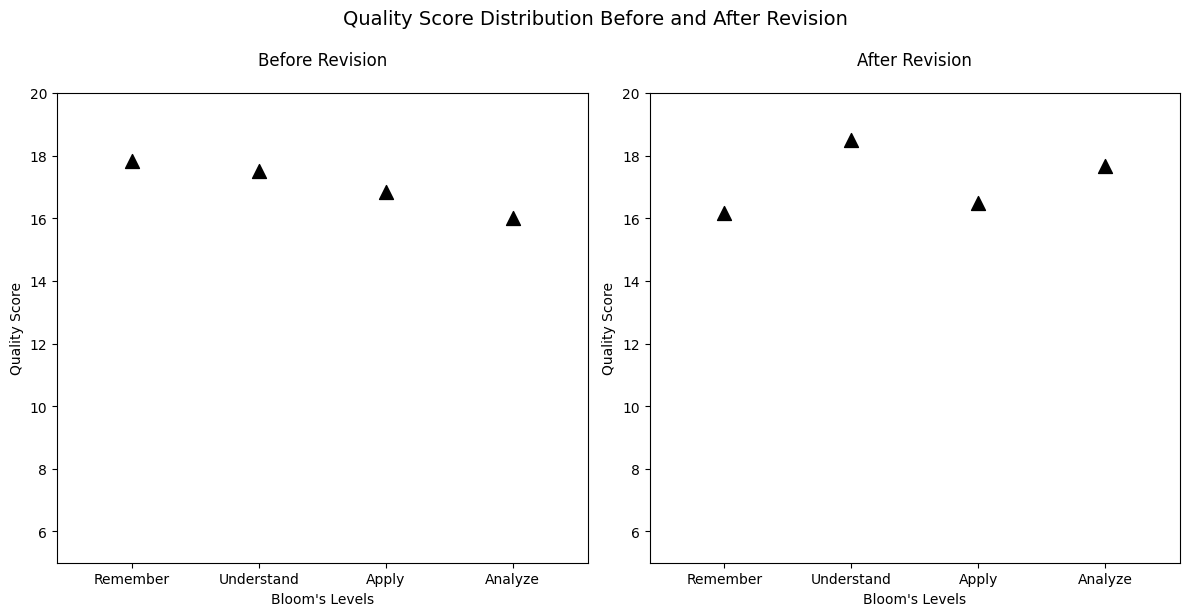

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Map objective values to labels
objective_labels = {1: 'Remember', 2: 'Understand', 3: 'Apply', 4: 'Analyze'}
first_round['Objective_Label'] = first_round['objective'].map(objective_labels)
second_round['Objective_Label'] = first_round['objective'].map(objective_labels)

# Define the order of the objectives
objective_order = ['Remember', 'Understand', 'Apply', 'Analyze']

# Create the figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns, adjust size as needed

# Add a title to the whole figure
fig.suptitle("Quality Score Distribution Before and After Revision", fontsize=14, y=1.02)

# First plot (left)
sns.boxplot(x='Objective_Label', y='quality_score_percent', data=first_round, palette='Set2', ax=ax1)

# Calculate means for the first plot
means_1 = first_round.groupby('Objective_Label')['quality_score'].mean().values

# Add mean markers to the first plot
for i, mean in enumerate(means_1):
    ax1.scatter(i, mean, color='black', edgecolor='black', s=100, marker='^', zorder=10)

# Customize the first plot
ax1.set_xticks(range(len(objective_order)))
ax1.set_xticklabels(objective_order, rotation=0)
ax1.set_xlabel("Bloom's Levels")
ax1.set_ylabel('Quality Score')
ax1.set_title("Before Revision", pad=20)

# Second plot (right)
sns.boxplot(x='Objective_Label', y='quality_score_percent', data=second_round, palette='Set2', ax=ax2)

# Calculate means for the second plot
means_2 = second_round.groupby('Objective_Label')['quality_score'].mean().values

# Add mean markers to the second plot
for i, mean in enumerate(means_2):
    ax2.scatter(i, mean, color='black', edgecolor='black', s=100, marker='^', zorder=10)

# Customize the second plot
ax2.set_xticks(range(len(objective_order)))
ax2.set_xticklabels(objective_order, rotation=0)
ax2.set_xlabel("Bloom's Levels")
ax2.set_ylabel('Quality Score')
ax2.set_title("After Revision", pad=20)


y_min = min(first_round['quality_score'].min(), second_round['quality_score'].min())-1
y_max = max(first_round['quality_score'].max(), second_round['quality_score'].max())+1
ax1.set_ylim(y_min, y_max)
ax2.set_ylim(y_min, y_max)


# Adjust layout to fit labels and titles
plt.tight_layout()
plt.subplots_adjust(top=0.88)  # Adjust the top to make space for the main title
plt.show()


In [85]:
first_round.groupby('Objective_Label')['quality_score'].mean()

Objective_Label
Analyze       17.833333
Apply         17.500000
Remember      16.833333
Understand    16.000000
Name: quality_score, dtype: float64

In [86]:
second_round.groupby('Objective_Label')['quality_score'].mean()

Objective_Label
Analyze       16.166667
Apply         18.500000
Remember      16.500000
Understand    17.666667
Name: quality_score, dtype: float64

In [87]:
import numpy as np
import pandas as pd
from scipy import stats

round1_remember_score=first_round[first_round['objective']==1]['quality_score'].to_list()
round1_understand_score=first_round[first_round['objective']==2]['quality_score'].to_list()
round1_apply_score=first_round[first_round['objective']==3]['quality_score'].to_list()
round1_analyze_score=first_round[first_round['objective']==4]['quality_score'].to_list()

round2_remember_score=second_round[second_round['objective']==1]['quality_score'].to_list()
round2_understand_score=second_round[second_round['objective']==2]['quality_score'].to_list()
round2_apply_score=second_round[second_round['objective']==3]['quality_score'].to_list()
round2_analyze_score=second_round[second_round['objective']==4]['quality_score'].to_list()

# Perform One-Way ANOVA
anova_result = stats.f_oneway(round1_remember_score, round2_remember_score)
print("ANOVA Result:")
print(f"F-statistic: {anova_result.statistic:.3f}")
print(f"P-value: {anova_result.pvalue:.3f}")

# Low p-value less than .05 so we can reject the null and there is a significant difference between groups
kruskal_result = stats.kruskal(round1_remember_score, round2_remember_score)

print("\nKruskal-Wallis Test Result:")
print(f"Chi-Square statistic: {kruskal_result.statistic:.3f}")
print(f"P-value: {kruskal_result.pvalue:.3f}")


res = ttest_ind(round1_remember_score, round2_remember_score)

print(f"Remember result:\n{res}")




# Perform One-Way ANOVA
anova_result = stats.f_oneway(round1_understand_score, round2_understand_score)
print("ANOVA Result:")
print(f"F-statistic: {anova_result.statistic:.3f}")
print(f"P-value: {anova_result.pvalue:.3f}")

# Low p-value less than .05 so we can reject the null and there is a significant difference between groups
kruskal_result = stats.kruskal(round1_understand_score, round2_understand_score)

print("\nKruskal-Wallis Test Result:")
print(f"Chi-Square statistic: {kruskal_result.statistic:.3f}")
print(f"P-value: {kruskal_result.pvalue:.3f}")


from scipy.stats import ttest_ind



res = ttest_ind(round1_understand_score, round2_understand_score)

print(f"Understand result:\n{res}")




# Perform One-Way ANOVA
anova_result = stats.f_oneway(round1_apply_score, round2_apply_score)
print("ANOVA Result Apply:")
print(f"F-statistic: {anova_result.statistic:.3f}")
print(f"P-value: {anova_result.pvalue:.3f}")

# Low p-value less than .05 so we can reject the null and there is a significant difference between groups
kruskal_result = stats.kruskal(round1_apply_score, round2_apply_score)

print("\nKruskal-Wallis Test Result:")
print(f"Chi-Square statistic: {kruskal_result.statistic:.3f}")
print(f"P-value: {kruskal_result.pvalue:.3f}")


from scipy.stats import ttest_ind



res = ttest_ind(round1_apply_score, round2_apply_score)

print(f"Apply result:\n{res}")



# Perform One-Way ANOVA
anova_result = stats.f_oneway(round1_analyze_score, round2_analyze_score)
print("\n\nANOVA Result Analyze:")
print(f"F-statistic: {anova_result.statistic:.3f}")
print(f"P-value: {anova_result.pvalue:.3f}")

# Low p-value less than .05 so we can reject the null and there is a significant difference between groups
kruskal_result = stats.kruskal(round1_analyze_score, round2_analyze_score)

print("\nKruskal-Wallis Test Result:")
print(f"Chi-Square statistic: {kruskal_result.statistic:.3f}")
print(f"P-value: {kruskal_result.pvalue:.3f}")


from scipy.stats import ttest_ind



res = ttest_ind(round1_analyze_score, round2_analyze_score)

print(f"Analyze result:\n{res}")

KeyError: 'objective'

In [88]:
# Perform One-Way ANOVA
anova_result = stats.f_oneway(round1_remember_score, round1_understand_score,round1_apply_score,round1_analyze_score)
print("\n\nANOVA Result Analyze:")
print(f"F-statistic: {anova_result.statistic:.3f}")
print(f"P-value: {anova_result.pvalue:.3f}")
# Perform One-Way ANOVA
anova_result = stats.f_oneway(round2_remember_score, round2_understand_score,round2_apply_score,round2_analyze_score)
print("\n\nANOVA Result Analyze:")
print(f"F-statistic: {anova_result.statistic:.3f}")
print(f"P-value: {anova_result.pvalue:.3f}")

# Low p-value less than .05 so we can reject the null and there is a significant difference between groups
kruskal_result = stats.kruskal(round2_remember_score, round2_understand_score,round2_apply_score,round2_analyze_score)

print("\nKruskal-Wallis Test Result:")
print(f"Chi-Square statistic: {kruskal_result.statistic:.3f}")
print(f"P-value: {kruskal_result.pvalue:.3f}")




ANOVA Result Analyze:
F-statistic: 0.993
P-value: 0.405


NameError: name 'round2_remember_score' is not defined

In [89]:
import numpy as np
from scipy.stats import tukey_hsd
res = tukey_hsd(round2_remember_score, round2_understand_score,round2_apply_score,round2_analyze_score)
print(res)

NameError: name 'round2_remember_score' is not defined

In [90]:
question_evaluation_secondary.groupby('Objective_Label')['quality_score'].mean()

KeyError: 'Objective_Label'

In [91]:
question_evaluation_secondary.groupby('Objective_Label')['quality_score'].mean().reindex(objective_order)

KeyError: 'Objective_Label'

In [92]:
means

NameError: name 'means' is not defined

In [93]:
question_evaluation_secondary.groupby('Objective_Label')['quality_score'].mean()

KeyError: 'Objective_Label'

In [94]:
means

NameError: name 'means' is not defined

/var/folders/3_/3w9w1wt96nj9w_2s9mqhpgtr0000gn/T/ipykernel_77882/1649220312.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




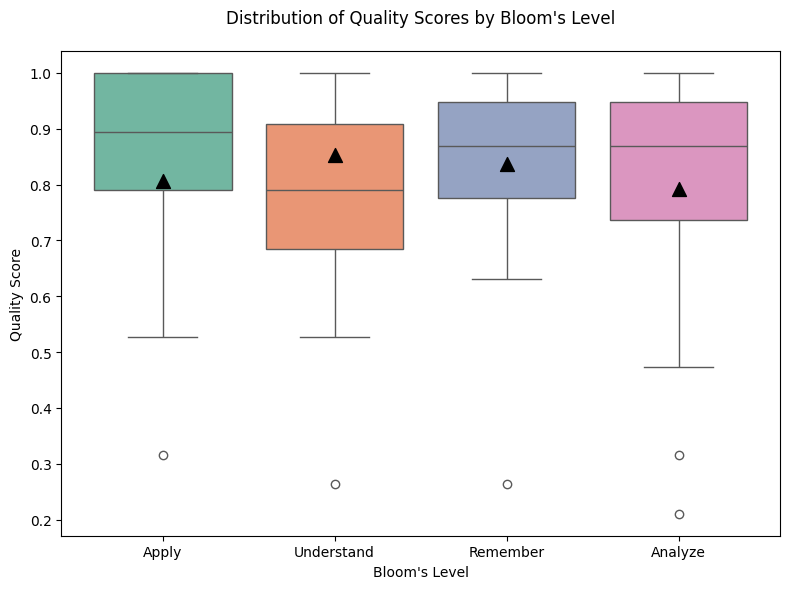

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


# Map objective values to labels
objective_labels = {1: 'Remember', 2: 'Understand', 3: 'Apply', 4: 'Analyze'}
question_evaluation_secondary['Objective_Label'] = question_evaluation_secondary['objective'].map(objective_labels)

# Create the box plot
plt.figure(figsize=(8, 6))  # Adjust width (8) and height (6) for desired size
sns.boxplot(x='Objective_Label', y='quality_score_percent', data=question_evaluation_secondary, palette='Set2')

# Calculate means
means = question_evaluation_secondary.groupby('Objective_Label')['quality_score_percent'].mean().values

# Add mean markers
for i, mean in enumerate(means):
    plt.scatter(i, mean, color='black', edgecolor='black', s=100, marker='^', zorder=10)

# Customize the plot
plt.xticks(rotation=0)
plt.xlabel("Bloom's Level")
plt.ylabel('Quality Score')
plt.title("Distribution of Quality Scores by Bloom's Level", pad =20)

# Show the plot
plt.tight_layout()  # Adjust layout to fit labels and titles
plt.show()


In [96]:
objective_labels = {1: 'Remember', 2: 'Understand', 3: 'Apply', 4: 'Analyze'}
question_evaluation_secondary['Objective_Label'] = question_evaluation_secondary['objective'].map(objective_labels)

# Group by the objective levels
grouped = question_evaluation_secondary.groupby('Objective_Label')['quality_score']

# Compute statistics
stats = grouped.agg(['mean', 'std', 'median','count']).reset_index()

# Rename columns for clarity
stats.columns = ["Bloom's Level", 'Mean', 'Standard_Deviation', 'Median','Count']
stats

Bloom's Level      Mean  Standard_Deviation  Median  Count
0       Analyze  15.31250            3.796752    16.5     32
1         Apply  16.21875            2.926347    17.0     32
2      Remember  15.90625            2.888904    16.5     32
3    Understand  15.03125            3.126209    15.0     32

In [97]:
import numpy as np
import pandas as pd
from scipy import stats

remember_score=question_evaluation_secondary[question_evaluation_secondary['objective']==1]['quality_score'].to_list()
understand_score=question_evaluation_secondary[question_evaluation_secondary['objective']==2]['quality_score'].to_list()
apply_score=question_evaluation_secondary[question_evaluation_secondary['objective']==3]['quality_score'].to_list()
analyze_score=question_evaluation_secondary[question_evaluation_secondary['objective']==4]['quality_score'].to_list()

# Perform One-Way ANOVA
anova_result = stats.f_oneway(remember_score, understand_score, apply_score, analyze_score)
print("ANOVA Result:")
print(f"F-statistic: {anova_result.statistic:.3f}")
print(f"P-value: {anova_result.pvalue:.3f}")

# Low p-value less than .05 so we can reject the null and there is a significant difference between groups
kruskal_result = stats.kruskal(remember_score, understand_score, apply_score, analyze_score)

print("\nKruskal-Wallis Test Result:")
print(f"Chi-Square statistic: {kruskal_result.statistic:.3f}")
print(f"P-value: {kruskal_result.pvalue:.3f}")

ANOVA Result:
F-statistic: 0.915
P-value: 0.436

Kruskal-Wallis Test Result:
Chi-Square statistic: 3.474
P-value: 0.324


In [98]:
objective_labels = {1: 'Remember', 2: 'Understand', 3: 'Apply', 4: 'Analyze'}
question_evaluation_secondary['Teacher_Blooms_Label'] = question_evaluation_secondary['Teacher_Blooms'].map(objective_labels)

# Group by the objective levels
grouped = question_evaluation_secondary.groupby('Teacher_Blooms_Label')['quality_score']

# Compute statistics
stats = grouped.agg(['mean', 'std', 'median','count']).reset_index()

# Rename columns for clarity
stats.columns = ["Predicted Bloom's Level", 'Mean', 'Standard_Deviation', 'Median','Count']
stats

Predicted Bloom's Level       Mean  Standard_Deviation  Median  Count
0                 Analyze  18.000000                 NaN    18.0      1
1                   Apply  16.482759            2.443953    17.0     29
2                Remember  14.584906            3.899872    16.0     53
3              Understand  16.222222            2.353806    17.0     45

In [99]:
remember_guess=question_evaluation_secondary[question_evaluation_secondary['Teacher_Blooms']==1]['quality_score'].to_list()
understand_guess=question_evaluation_secondary[question_evaluation_secondary['Teacher_Blooms']==2]['quality_score'].to_list()
apply_guess=question_evaluation_secondary[question_evaluation_secondary['Teacher_Blooms']==3]['quality_score'].to_list()
analyze_guess =question_evaluation_secondary[question_evaluation_secondary['Teacher_Blooms']==4]['quality_score'].to_list()

In [100]:
import numpy as np
import pandas as pd
from scipy import stats

# Perform One-Way ANOVA
anova_result = stats.f_oneway(remember_guess, understand_guess, apply_guess,analyze_guess)
print("ANOVA Result:")
print(f"F-statistic: {anova_result.statistic:.3f}")
print(f"P-value: {anova_result.pvalue:.3f}")
# Low p-value less than .05 so we can reject the null and there is a significant difference between groups
kruskal_result = stats.kruskal(remember_guess, understand_guess, apply_guess, analyze_guess)
print("\nKruskal-Wallis Test Result:")
print(f"Chi-Square statistic: {kruskal_result.statistic:.3f}")
print(f"P-value: {kruskal_result.pvalue:.3f}")

ANOVA Result:
F-statistic: 3.451
P-value: 0.019

Kruskal-Wallis Test Result:
Chi-Square statistic: 7.217
P-value: 0.065


In [101]:
import numpy as np
from scipy.stats import tukey_hsd
res = tukey_hsd(remember_guess, understand_guess, apply_guess)
print(res)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -1.637     0.028    -3.134    -0.140
 (0 - 2)     -1.898     0.025    -3.604    -0.192
 (1 - 0)      1.637     0.028     0.140     3.134
 (1 - 2)     -0.261     0.934    -2.019     1.498
 (2 - 0)      1.898     0.025     0.192     3.604
 (2 - 1)      0.261     0.934    -1.498     2.019



In [102]:
grouped.agg(['count'])

count
Teacher_Blooms_Label       
Analyze                   1
Apply                    29
Remember                 53
Understand               45

In [103]:
## Next for each question I want to compute mean std, median across questions


In [104]:

# Define the score columns
score_columns = [
    'Relevant', 'Correct_Info', 'Grammatical', 'Enough_Info',
    'Correct_Marked', 'One_Correct', 'Distinct_Option', 'Plausible',
    'Misconceptions', 'Usable'
]

# Compute statistics across all questions
stats_all = {}
for col in score_columns:
    stats_all[col] = {
        'Mean': question_evaluation_secondary[col].mean(),
        'Standard_Deviation': question_evaluation_secondary[col].std(),
        'Median': question_evaluation_secondary[col].median()
    }

# Convert to DataFrame for better visualization
stats_all_df = pd.DataFrame(stats_all).T
stats_all_df.index.name = 'Score_Column'
# Round to 2 decimal places
stats_all_df = stats_all_df.round(2)
print("Statistics Across All Questions:")
print(stats_all_df)

# Map objective values to labels if needed
objective_labels = {1: 'Remember', 2: 'Understand', 3: 'Apply', 4: 'Analyze'}
question_evaluation_secondary['Objective_Label'] = question_evaluation_secondary['objective'].map(objective_labels)

# Compute statistics grouped by the objective
stats_by_objective = question_evaluation_secondary.groupby('Objective_Label')[score_columns].agg(['mean', 'std', 'median']).reset_index()

# Rename columns for clarity
stats_by_objective.columns = [
    'Objective_Label'] + [f'{col}_{stat}' for col in score_columns for stat in ['mean', 'std', 'median']]
# Round to 2 decimal places
stats_by_objective = stats_by_objective.round(2)
print("\nStatistics Grouped by Objective:")
print(stats_by_objective)

Statistics Across All Questions:
                 Mean  Standard_Deviation  Median
Score_Column                                     
Relevant         1.73                0.56     2.0
Correct_Info     1.78                0.55     2.0
Grammatical      1.66                0.61     2.0
Enough_Info      1.80                0.52     2.0
Correct_Marked   1.89                0.44     2.0
One_Correct      1.96                0.23     2.0
Distinct_Option  1.80                0.48     2.0
Plausible        1.38                0.91     2.0
Misconceptions   0.97                0.81     1.0
Usable           0.65                0.48     1.0

Statistics Grouped by Objective:
  Objective_Label  Relevant_mean  Relevant_std  Relevant_median  \
0         Analyze           1.59          0.67              2.0   
1           Apply           1.75          0.57              2.0   
2        Remember           1.84          0.45              2.0   
3      Understand           1.72          0.52              2.0  

In [105]:
stats_by_objective

Objective_Label  Relevant_mean  Relevant_std  Relevant_median  \
0         Analyze           1.59          0.67              2.0   
1           Apply           1.75          0.57              2.0   
2        Remember           1.84          0.45              2.0   
3      Understand           1.72          0.52              2.0   

   Correct_Info_mean  Correct_Info_std  Correct_Info_median  Grammatical_mean  \
0               1.81              0.47                  2.0              1.62   
1               1.88              0.42                  2.0              1.66   
2               1.81              0.54                  2.0              1.88   
3               1.62              0.71                  2.0              1.47   

   Grammatical_std  Grammatical_median  ...  Distinct_Option_median  \
0             0.66                 2.0  ...                     2.0   
1             0.60                 2.0  ...                     2.0   
2             0.34                 2.0  ...                     2.0   
3             0.72                 2.0  ...                     2.0   

   Plausible_mean  Plausible_std  Plausible_median  Misconceptions_mean  \
0            1.66           0.75               2.0                 1.00   
1            1.47           0.88               2.0                 1.12   
2            1.25           0.98               2.0                 0.88   
3            1.16           0.99               2.0                 0.88   

   Misconceptions_std  Misconceptions_median  Usable_mean  Usable_std  \
0                0.84                    1.0         0.53        0.51   
1                0.83                    1.0         0.69        0.47   
2                0.75                    1.0         0.75        0.44   
3                0.83                    1.0         0.62        0.49   

   Usable_median  
0            1.0  
1            1.0  
2            1.0  
3            1.0  

[4 rows x 31 columns]

In [106]:
# For questions that were rated by multiple readers, I want to compute the interrator reliability score with different columns
secondary_description= question_evaluation_secondary.describe()

In [107]:
secondary_description

Unnamed: 0  participant_ID  question_ID  LG_Progress    Relevant  \
count  128.000000      128.000000   128.000000    32.000000  128.000000   
mean    63.500000        4.500000    33.484375     1.281250    1.726562   
std     37.094474        2.300291    20.486210     0.728869    0.557198   
min      0.000000        1.000000     1.000000     0.000000    0.000000   
25%     31.750000        2.750000    16.750000     1.000000    2.000000   
50%     63.500000        4.500000    32.000000     1.000000    2.000000   
75%     95.250000        6.250000    50.250000     2.000000    2.000000   
max    127.000000        8.000000    74.000000     2.000000    2.000000   

       Correct_Info  Grammatical  Enough_Info  Correct_Marked  One_Correct  \
count    128.000000   128.000000   128.000000      128.000000   128.000000   
mean       1.781250     1.656250     1.804688        1.890625     1.960938   
std        0.546103     0.607531     0.518304        0.438939     0.231474   
min        0.000000     0.000000     0.000000        0.000000     0.000000   
25%        2.000000     1.000000     2.000000        2.000000     2.000000   
50%        2.000000     2.000000     2.000000        2.000000     2.000000   
75%        2.000000     2.000000     2.000000        2.000000     2.000000   
max        2.000000     2.000000     2.000000        2.000000     2.000000   

       Distinct_Option   Plausible  Misconceptions      Usable  \
count       128.000000  128.000000       128.00000  128.000000   
mean          1.796875    1.382812         0.96875    0.648438   
std           0.475533    0.914633         0.81267    0.479334   
min           0.000000    0.000000         0.00000    0.000000   
25%           2.000000    0.000000         0.00000    0.000000   
50%           2.000000    2.000000         1.00000    1.000000   
75%           2.000000    2.000000         2.00000    1.000000   
max           2.000000    2.000000         2.00000    1.000000   

       Teacher_Blooms   objective  textbook_section  quality_score  \
count      128.000000  128.000000        128.000000     128.000000   
mean         1.828125    2.500000          2.375000      15.617188   
std          0.804607    1.122427          1.223137       3.202167   
min          1.000000    1.000000          1.000000       4.000000   
25%          1.000000    1.750000          1.000000      14.000000   
50%          2.000000    2.500000          2.500000      16.000000   
75%          2.000000    3.250000          3.250000      18.000000   
max          4.000000    4.000000          4.000000      19.000000   

       quality_score_percent  
count             128.000000  
mean                0.821957  
std                 0.168535  
min                 0.210526  
25%                 0.736842  
50%                 0.842105  
75%                 0.947368  
max                 1.000000

In [108]:
columns_list = ['Relevant', 'Correct_Info', 'Grammatical', 'Enough_Info', 'Correct_Marked', 'One_Correct', 'Distinct_Option', 'Plausible', 'LG_Progress']

secondary_means = []

percent_change =[]

for column in columns_list:
    secondary_mean = first_description[column]['mean']
    second_mean = second_description[column]['mean']
    percent = (second_mean-first_mean)/first_mean
    first_round_means.append(first_mean)
    second_round_means.append(second_mean)
    percent_change.append(percent)
    

NameError: name 'first_description' is not defined

In [109]:
question_evaluation_secondary['question_ID']

0      34
1      34
2      34
3      32
4      32
       ..
123    70
124    73
125    73
126    74
127    74
Name: question_ID, Length: 128, dtype: int64

In [110]:
pip install statsmodels


Note: you may need to restart the kernel to use updated packages.


In [111]:
# Count occurrences of each question_ID
question_counts = question_evaluation_secondary['question_ID'].value_counts()

# Filter question_IDs with more than one entry
multiple_entries_question_ids = question_counts[question_counts > 1].index

# Filter DataFrame to include only those with multiple entries
filtered_df = question_evaluation_secondary[question_evaluation_secondary['question_ID'].isin(multiple_entries_question_ids)]

# Display the number of unique question_IDs
num_unique_question_ids = filtered_df['question_ID'].nunique()
print(f"Number of unique question_IDs with multiple entries: {num_unique_question_ids}")

Number of unique question_IDs with multiple entries: 48


In [112]:
columns_to_list = ['LG_Progress', 'Relevant', 'Correct_Info', 'Grammatical', 
                    'Enough_Info', 'Correct_Marked', 'One_Correct', 'Distinct_Option', 
                    'Plausible', 'Misconceptions', 'Usable', 'Teacher_Blooms', 
                    'objective', 'quality_score']

In [113]:
grouped_df = filtered_df.groupby('question_ID').agg(lambda x: list(x))

# Display the new DataFrame
print("\nGrouped DataFrame:")
grouped_df['Teacher_Blooms']


Grouped DataFrame:


question_ID
1        [1, 1]
2        [1, 1]
3        [1, 1]
4        [1, 2]
5        [2, 1]
6        [2, 3]
7        [3, 2]
8        [2, 2]
9        [2, 2]
10       [2, 3]
11       [2, 2]
12       [1, 3]
13       [3, 1]
14       [2, 2]
15       [1, 1]
16       [1, 2]
17       [1, 1]
18       [1, 2]
19       [1, 2]
20       [2, 2]
21       [3, 2]
22       [3, 3]
23       [2, 3]
24       [3, 2]
27    [2, 1, 1]
28    [1, 1, 1]
29    [2, 1, 1]
30    [1, 1, 1]
31    [2, 1, 3]
32    [2, 1, 3]
33    [3, 2, 3]
34    [2, 1, 3]
35    [2, 1, 2]
36    [1, 1, 1]
37    [1, 1, 1]
38    [2, 1, 1]
51    [2, 1, 2]
52    [2, 1, 3]
54    [2, 1, 3]
56    [2, 1, 1]
64       [1, 1]
65       [1, 1]
67       [3, 3]
68       [3, 3]
69       [4, 2]
70       [2, 3]
73       [2, 2]
74       [3, 2]
Name: Teacher_Blooms, dtype: object

In [114]:
grouped_df['Teacher_Blooms']

question_ID
1        [1, 1]
2        [1, 1]
3        [1, 1]
4        [1, 2]
5        [2, 1]
6        [2, 3]
7        [3, 2]
8        [2, 2]
9        [2, 2]
10       [2, 3]
11       [2, 2]
12       [1, 3]
13       [3, 1]
14       [2, 2]
15       [1, 1]
16       [1, 2]
17       [1, 1]
18       [1, 2]
19       [1, 2]
20       [2, 2]
21       [3, 2]
22       [3, 3]
23       [2, 3]
24       [3, 2]
27    [2, 1, 1]
28    [1, 1, 1]
29    [2, 1, 1]
30    [1, 1, 1]
31    [2, 1, 3]
32    [2, 1, 3]
33    [3, 2, 3]
34    [2, 1, 3]
35    [2, 1, 2]
36    [1, 1, 1]
37    [1, 1, 1]
38    [2, 1, 1]
51    [2, 1, 2]
52    [2, 1, 3]
54    [2, 1, 3]
56    [2, 1, 1]
64       [1, 1]
65       [1, 1]
67       [3, 3]
68       [3, 3]
69       [4, 2]
70       [2, 3]
73       [2, 2]
74       [3, 2]
Name: Teacher_Blooms, dtype: object

In [115]:
# Determine the maximum number of raters
max_raters = max(len(ratings) for ratings in grouped_df['Teacher_Blooms'])

# Convert the Teacher_Blooms column into a DataFrame
ratings_matrix = pd.DataFrame(grouped_df['Teacher_Blooms'].tolist())

# Pad the DataFrame with NaN to ensure all rows have the same number of columns
ratings_matrix = ratings_matrix.reindex(columns=range(max_raters), fill_value=np.nan)

# Convert ratings to integer and handle NaN (missing ratings)
ratings_matrix = ratings_matrix.fillna(0).astype(int)

# Find the number of unique ratings
rating_categories = ratings_matrix.apply(pd.Series.value_counts, axis=1).fillna(0).astype(int)
num_ratings = rating_categories.shape[1]  # Number of unique categories

# Ensure that the count matrix has the right dimensions
ratings_count_matrix = pd.DataFrame(np.zeros((ratings_matrix.shape[0], num_ratings), dtype=int),
                                   index=ratings_matrix.index)

# Populate the count matrix
for i in ratings_matrix.index:
    counts = ratings_matrix.loc[i].value_counts()
    for rating, count in counts.items():
        ratings_count_matrix.loc[i, int(rating)] = count

# Ensure the data is in the correct format
# Validate the matrix dimensions
assert ratings_count_matrix.sum(axis=1).min() == max_raters, "Mismatch in total counts"

# Compute Fleiss' Kappa
kappa_fleiss = fleiss_kappa(ratings_count_matrix)
print(f"Fleiss' Kappa: {kappa_fleiss}")

Fleiss' Kappa: -0.027359602042152074


In [116]:
question_evaluation_secondary.columns

Index(['Unnamed: 0', 'participant_ID', 'question_ID', 'LG_Progress',
       'Relevant', 'Correct_Info', 'Grammatical', 'Enough_Info',
       'Correct_Marked', 'One_Correct', 'Distinct_Option', 'Plausible',
       'Misconceptions', 'Usable', 'Teacher_Blooms', 'objective', 'strategy',
       'scenario', 'question', 'options', 'correct_answer', 'explanation',
       'textbook_section', 'analysis', 'Learning Goal', 'quality_score',
       'quality_score_percent', 'Objective_Label', 'Teacher_Blooms_Label'],
      dtype='object')

/var/folders/3_/3w9w1wt96nj9w_2s9mqhpgtr0000gn/T/ipykernel_77882/1141312161.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/3_/3w9w1wt96nj9w_2s9mqhpgtr0000gn/T/ipykernel_77882/1141312161.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/3_/3w9w1wt96nj9w_2s9mqhpgtr0000gn/T/ipykernel_77882/1141312161.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/3_/3w9w1wt96nj9w_2s9mqhpgtr0000gn/T/ipykernel_77882/1141312161.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign 

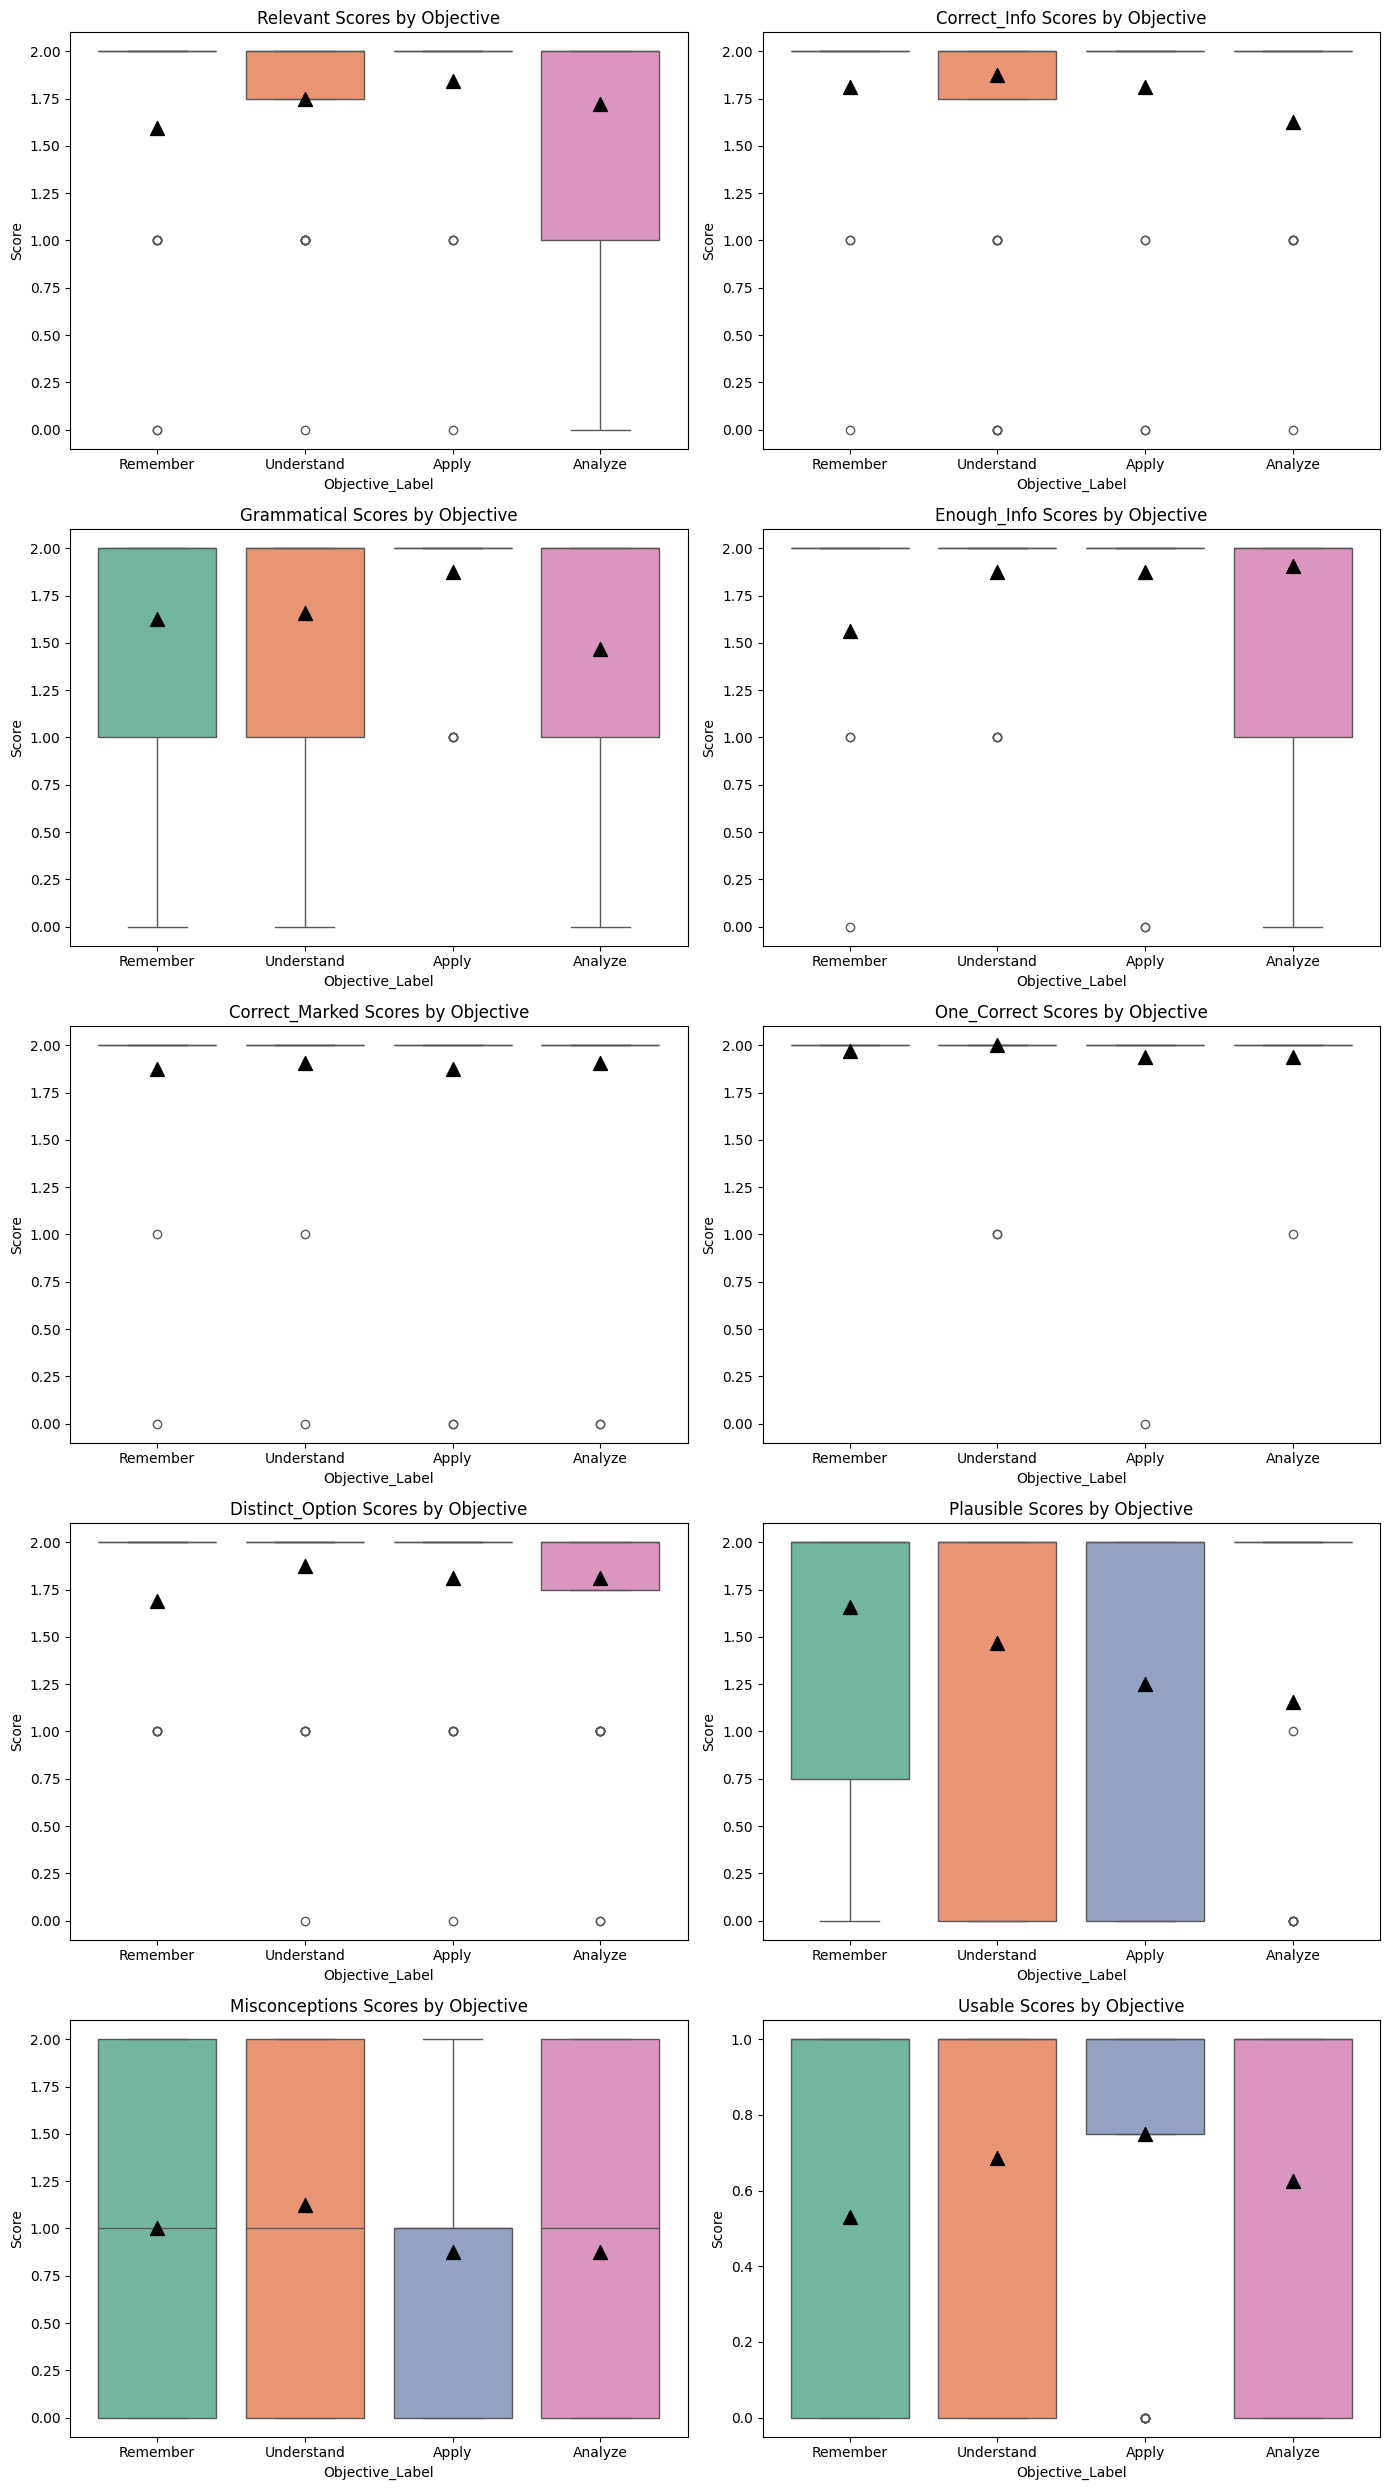

In [117]:
# Map objective values to labels
objective_labels = {1: 'Remember', 2: 'Understand', 3: 'Apply', 4: 'Analyze'}
question_evaluation_secondary['Objective_Label'] = question_evaluation_secondary['objective'].map(objective_labels)

# Define score columns
score_columns = ['Relevant', 'Correct_Info', 'Grammatical', 'Enough_Info',
                 'Correct_Marked', 'One_Correct', 'Distinct_Option', 'Plausible',
                 'Misconceptions', 'Usable']

# Create subplots
num_plots = len(score_columns)
fig, axes = plt.subplots(nrows=(num_plots + 1) // 2, ncols=2, figsize=(14, 5 * ((num_plots + 1) // 2)))
axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easy indexing

for idx, column in enumerate(score_columns):
    ax = axes[idx]
    sns.boxplot(x='Objective_Label', y=column, data=question_evaluation_secondary, palette='Set2', ax=ax)
    
    # Calculate means
    means = question_evaluation_secondary.groupby('Objective_Label')[column].mean().values
    
    # Add mean markers
    for i, mean in enumerate(means):
        ax.scatter(i, mean, color='black', edgecolor='black', s=100, marker='^', zorder=10)
    
    # Customize each subplot
    ax.set_xticks(range(len(objective_labels)))
    ax.set_xticklabels(objective_labels.values(), rotation=0)
    ax.set_ylabel('Score')
    ax.set_title(f'{column} Scores by Objective')

# Hide any unused subplots
for idx in range(num_plots, len(axes)):
    fig.delaxes(axes[idx])

# Adjust layouxt to fit labels and titles
plt.tight_layout()
plt.show()

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


# Reversed dictionary for mapping numeric values to labels
reversed_relabel_dict = {
    "LG_Progress": {0: 'No, it does not', 1: 'Yes, to some extent', 2: 'Yes, to a large extent'},
    "Relevant": {0: 'No, the question is not relevant', 1: 'The question is relevant but requires knowledge beyond what is included in the text section', 2: 'Yes, the question is relevant to the excerpt'},
    "Correct_Info": {0: 'No, not all information contained in the question is correct', 1: 'Mostly, but there are minor inaccuracies', 2: 'Yes, all information in the question is correct'},
    "Grammatical": {0: 'The question contains major grammar or syntactic errors that make the question more difficult to understand.', 1: 'The question contains minor grammar or syntactic errors, but these errors don’t interrupt understanding the question.', 2: 'Yes, the question is grammatical and well formed'},
    "Enough_Info": {0: 'No, it doesn’t provide enough information', 1: 'Somewhat, but additional information would be useful for clarity', 2: 'Yes it provides enough information'},
    "Correct_Marked": {0: 'No, there is no correct answer', 1: 'There is a correct answer but it is not given as the correct answer', 2: 'Yes, there is a correct answer and it is marked as the correct answer'},
    "One_Correct": {0: 'No, there are no correct answers given', 1: 'No, there are multiple correct answers', 2: 'Yes, the question contains only one correct answer'},
    "Distinct_Option": {0: 'No, they are too similar, making them repeated choices', 1: 'Some choices are unique, some are too similar', 2: 'Yes, they are completely unique between each other'},
    "Plausible": {0: 'No, there are obviously wrong option(s)', 1: 'Yes however the options give away the correct answer', 2: 'Yes there are no obviously wrong options'},
    "Misconceptions": {0: 'No, the wrong answer choices do not target misconceptions', 1: 'Some wrong answer choices target common misconceptions', 2: 'Yes, all wrong answer choices target common misconceptions'},
    "Usable": {0: 'No', 1: 'Yes'},
    "Teacher_Blooms": {1: 'Remembering', 2: 'Understanding', 3: 'Applying', 4: 'Analyzing'}
}

## Davis Evaluation

In [119]:
first_round = pd.read_excel('round1_eval.xlsx')

In [120]:
first_round.columns

Index(['Unnamed: 0', 'participant_ID', 'question_ID', 'Relevant',
       'Correct_Info', 'Grammatical', 'Enough_Info', 'Correct_Marked',
       'One_Correct', 'Distinct_Option', 'Plausible', 'Usable', 'LG_Progress',
       'Teacher_Blooms', 'Level_feedback', 'improve_feedback', 'context',
       'context_explain', 'additional_feedback', 'objective', 'learning_goal',
       'strategy', 'scenario', 'question', 'options', 'correct_answer',
       'explanation', 'textbook_section', 'model', 'analysis'],
      dtype='object')

In [121]:
second_round = pd.read_excel('round2_eval.xlsx')

In [122]:
##Bloom's Level Evaluations
first_round['objective'] = first_round

ValueError: Columns must be same length as key

In [123]:
performancePrinter(second_round['objective'], second_round['Teacher_Blooms'])

KeyError: 'objective'

In [124]:
second_round.columns

Index(['Unnamed: 0', 'participant_ID', 'question_ID', 'Relevant',
       'Correct_Info', 'Grammatical', 'Enough_Info', 'Correct_Marked',
       'One_Correct', 'Distinct_Option', 'Plausible', 'Usable', 'LG_Progress',
       'Teacher_Blooms', 'Level_feedback', 'improve_feedback', 'context',
       'context_explain', 'additional_feedback', 'Feedback_corrected',
       'Feedback_addressed'],
      dtype='object')

In [125]:
second_round.columns

Index(['Unnamed: 0', 'participant_ID', 'question_ID', 'Relevant',
       'Correct_Info', 'Grammatical', 'Enough_Info', 'Correct_Marked',
       'One_Correct', 'Distinct_Option', 'Plausible', 'Usable', 'LG_Progress',
       'Teacher_Blooms', 'Level_feedback', 'improve_feedback', 'context',
       'context_explain', 'additional_feedback', 'Feedback_corrected',
       'Feedback_addressed'],
      dtype='object')

In [126]:
blooms_df = first_round[['objective', 'question_ID']].drop_duplicates()

In [127]:
second_round = pd.merge(second_round, blooms_df, how ='left', on='question_ID')

In [128]:
blooms_df

objective  question_ID
0           2            1
3           3            4
6           4            5
9           1            7
12          1            9
15          2           13
18          3           14
21          4           16
24          2           18
27          1           20
30          3           22
33          4           23
36          1           24
39          2           25
42          3           26
45          4           27

In [129]:
second_round

Unnamed: 0  participant_ID  question_ID  Relevant  Correct_Info  \
0            0               1            1       2.0             2   
1            1               2            1       2.0             2   
2            2               3            1       2.0             2   
3            0               1            4       2.0             2   
4            1               2            4       2.0             2   
5            2               3            4       2.0             2   
6            0               1            5       2.0             2   
7            1               2            5       2.0             2   
8            2               3            5       2.0             2   
9            0               1            7       2.0             2   
10           1               2            7       2.0             2   
11           2               3            7       2.0             2   
12           0               1            9       2.0             2   
13           1               2            9       2.0             2   
14           2               3            9       2.0             2   
15           0               1           13       2.0             2   
16           1               2           13       2.0             2   
17           2               3           13       2.0             2   
18           0               1           14       2.0             2   
19           1               2           14       2.0             2   
20           2               3           14       2.0             2   
21           0               1           16       2.0             2   
22           1               2           16       2.0             2   
23           2               3           16       2.0             2   
24           0               1           18       2.0             2   
25           1               2           18       2.0             2   
26           2               3           18       2.0             2   
27           0               1           20       2.0             2   
28           1               2           20       2.0             2   
29           2               3           20       NaN             2   
30           0               1           22       2.0             2   
31           1               2           22       2.0             2   
32           2               3           22       2.0             2   
33           0               1           23       2.0             2   
34           1               2           23       2.0             2   
35           2               3           23       2.0             2   
36           0               1           24       2.0             2   
37           1               2           24       2.0             2   
38           2               3           24       2.0             2   
39           0               1           25       2.0             2   
40           1               2           25       2.0             2   
41           2               3           25       2.0             2   
42           0               1           26       2.0             2   
43           1               2           26       2.0             2   
44           2               3           26       2.0             2   
45           0               1           27       2.0             2   
46           1               2           27       2.0             2   
47           2               3           27       2.0             2   

    Grammatical  Enough_Info  Correct_Marked  One_Correct  Distinct_Option  \
0             2            2               2            2              1.0   
1             2            2               2            2              2.0   
2             2            2               2            2              2.0   
3             2            2               2            2              2.0   
4             1            2               2            2              2.0   
5             2            2               2            

In [130]:
performancePrinter(second_round['objective'], second_round['Teacher_Blooms'])

Accuracy Score ->  0.6041666666666666
Kappa Score ->  0.4722222222222222
ROC AUC Score -> Cannot calculate (probability scores required)
F1 Score ->  0.6008459835547122
Classification report -> 
               precision    recall  f1-score   support

           1       0.92      0.92      0.92        12
           2       0.50      0.50      0.50        12
           3       0.42      0.67      0.52        12
           4       0.80      0.33      0.47        12

    accuracy                           0.60        48
   macro avg       0.66      0.60      0.60        48
weighted avg       0.66      0.60      0.60        48



KeyError: 4

In [131]:
df_flow

objective Teacher_Blooms  count
0         1              1      7
1         1              2      1
2         1              3      4
3         2              1      1
4         2              2      5
5         2              3      6
6         3              3     12
7         4              2      1
8         4              3      8
9         4              4      3

In [132]:
# Bar chart of scores

# Could show a sankey Diagram

df_flow = first_round.groupby(['objective', 'Teacher_Blooms']).size().reset_index(name='count')

# Define the labels (1 to 4) and their names
labels = ['Remembering', 'Understanding', 'Applying', 'Analyzing']

# Create source and target lists
source = df_flow['objective'] - 1  # Adjusting for zero-based indexing in plotly
target = df_flow['Teacher_Blooms'] + len(labels) - 1  # Adding an offset to target indices
value = df_flow['count']

In [133]:
first_round.columns

Index(['Unnamed: 0', 'participant_ID', 'question_ID', 'Relevant',
       'Correct_Info', 'Grammatical', 'Enough_Info', 'Correct_Marked',
       'One_Correct', 'Distinct_Option', 'Plausible', 'Usable', 'LG_Progress',
       'Teacher_Blooms', 'Level_feedback', 'improve_feedback', 'context',
       'context_explain', 'additional_feedback', 'objective', 'learning_goal',
       'strategy', 'scenario', 'question', 'options', 'correct_answer',
       'explanation', 'textbook_section', 'model', 'analysis'],
      dtype='object')

In [134]:
second_round.columns


Index(['Unnamed: 0', 'participant_ID', 'question_ID', 'Relevant',
       'Correct_Info', 'Grammatical', 'Enough_Info', 'Correct_Marked',
       'One_Correct', 'Distinct_Option', 'Plausible', 'Usable', 'LG_Progress',
       'Teacher_Blooms', 'Level_feedback', 'improve_feedback', 'context',
       'context_explain', 'additional_feedback', 'Feedback_corrected',
       'Feedback_addressed', 'objective'],
      dtype='object')

In [135]:
first_round_unique = first_round[['question_ID', 'objective']].drop_duplicates(subset='question_ID')

# Merge to add the 'objective' column from first_round_unique to second_round
second_round2 = pd.merge(second_round, first_round_unique, on='question_ID', how='left')

# Check the resulting DataFrame
print(second_round2.head())

   Unnamed: 0  participant_ID  question_ID  Relevant  Correct_Info  \
0           0               1            1       2.0             2   
1           1               2            1       2.0             2   
2           2               3            1       2.0             2   
3           0               1            4       2.0             2   
4           1               2            4       2.0             2   

   Grammatical  Enough_Info  Correct_Marked  One_Correct  Distinct_Option  \
0            2            2               2            2              1.0   
1            2            2               2            2              2.0   
2            2            2               2            2              2.0   
3            2            2               2            2              2.0   
4            1            2               2            2              2.0   

   ...  Teacher_Blooms                                     Level_feedback  \
0  ...               2                 

In [136]:
second_round2.columns

Index(['Unnamed: 0', 'participant_ID', 'question_ID', 'Relevant',
       'Correct_Info', 'Grammatical', 'Enough_Info', 'Correct_Marked',
       'One_Correct', 'Distinct_Option', 'Plausible', 'Usable', 'LG_Progress',
       'Teacher_Blooms', 'Level_feedback', 'improve_feedback', 'context',
       'context_explain', 'additional_feedback', 'Feedback_corrected',
       'Feedback_addressed', 'objective_x', 'objective_y'],
      dtype='object')

In [137]:
# Bar chart of scores

# Could show a sankey Diagram

df_flow2 = second_round2.groupby(['objective_x', 'Teacher_Blooms']).size().reset_index(name='count')

# Define the labels (1 to 4) and their names
labels = ['Remembering', 'Understanding', 'Applying', 'Analyzing']

# Create source and target lists
source = df_flow['objective'] - 1  # Adjusting for zero-based indexing in plotly
target = df_flow['Teacher_Blooms'] + len(labels) - 1  # Adding an offset to target indices
value = df_flow['count']

In [138]:
df_flow2

objective_x  Teacher_Blooms  count
0             1               1     11
1             1               2      1
2             2               1      1
3             2               2      6
4             2               3      5
5             3               2      3
6             3               3      8
7             3               4      1
8             4               2      2
9             4               3      6
10            4               4      4

In [139]:
df_flow2

objective_x  Teacher_Blooms  count
0             1               1     11
1             1               2      1
2             2               1      1
3             2               2      6
4             2               3      5
5             3               2      3
6             3               3      8
7             3               4      1
8             4               2      2
9             4               3      6
10            4               4      4

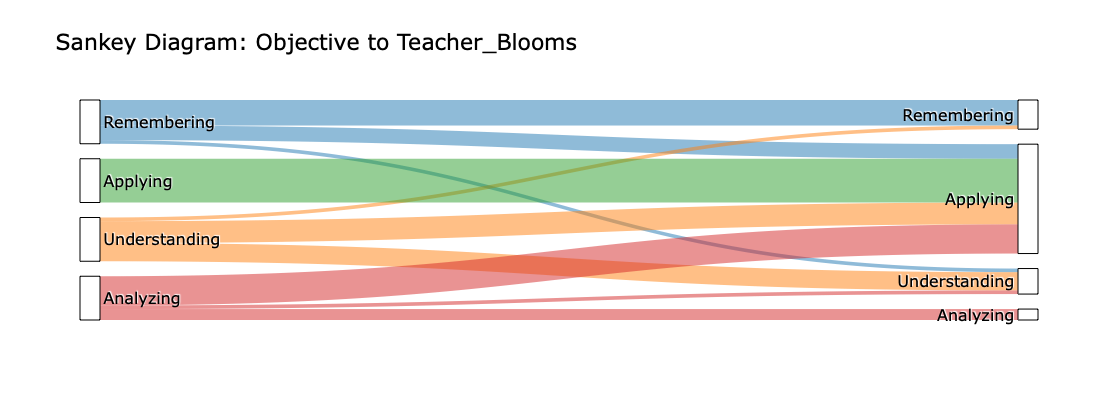

In [140]:
#Define colors for each objective value
color_map = {
    0: 'rgba(31, 119, 180, 0.5)',  # Remembering (blue)
    1: 'rgba(255, 127, 14, 0.5)',  # Understanding (orange)
    2: 'rgba(44, 160, 44, 0.5)',   # Applying (green)
    3: 'rgba(214, 39, 40, 0.5)'    # Analyzing (red)
}

# Apply colors based on the source
link_colors = [color_map[src] for src in source]

# Create the Sankey diagram with labels
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=1),
        label=labels + labels,
        # Duplicating the labels for both source and target
        color="white"  # Set the node color to white
    ),
    link=dict(
        source=source,  # Indices correspond to source
        target=target,  # Indices correspond to target
        value=value,
        color=link_colors,  # Apply the colors based on the source objective
        customdata=value,  # Pass the flow values for labeling
        hovertemplate='Value: %{value}<br>Source: %{source.label}<br>Target: %{target.label}<extra></extra>',  # Customize hover info
        label=labels  # This automatically labels the lines with the respective values
    )
))

# Update the layout to make the diagram narrower and boxes white
fig.update_layout(
    title_text="Sankey Diagram: Objective to Teacher_Blooms",
    font=dict(size = 16, color = 'black'),
    width=500,  # Adjust this value to make the diagram narrower
    height=400,  # You can adjust the height as needed
    paper_bgcolor='rgba(255,255,255,0)',  # Set background to white
    plot_bgcolor='rgba(255,255,255,0)'  # Set plot background to white
)

# Show the diagram
fig.show()


# Label Left Side GPT Label, Right Teacher Label
# Try to enforce according to Bloom's

In [141]:
df_flow

objective  Teacher_Blooms  count
0          1               1      7
1          1               2      1
2          1               3      4
3          2               1      1
4          2               2      5
5          2               3      6
6          3               3     12
7          4               2      1
8          4               3      8
9          4               4      3

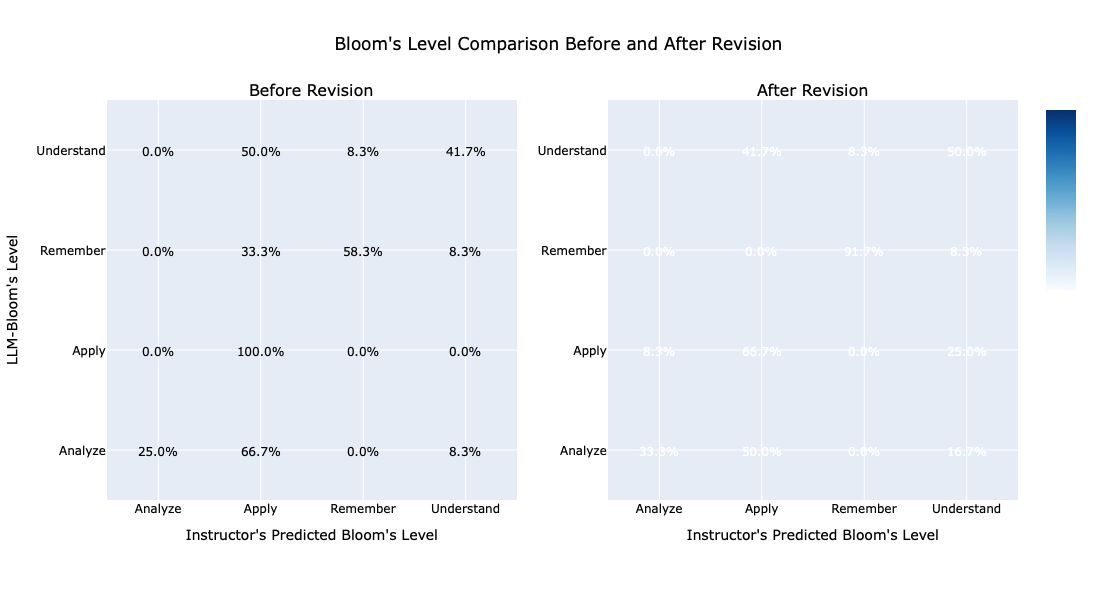

In [142]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Assuming df_flow and df_flow2 are your DataFrames

# Map objective values to labels
objective_labels = {1: 'Remember', 2: 'Understand', 3: 'Apply', 4: 'Analyze'}
df_flow['Objective_Label'] = df_flow['objective'].map(objective_labels)
df_flow['Teacher_Label'] = df_flow['Teacher_Blooms'].map(objective_labels)

df_flow2['Objective_Label'] = df_flow2['objective_x'].map(objective_labels)
df_flow2['Teacher_Label'] = df_flow2['Teacher_Blooms'].map(objective_labels)

# Pivot the DataFrames to create matrices for the heatmaps
heatmap_data1 = df_flow.pivot_table(index='Objective_Label', columns='Teacher_Label', values='count', fill_value=0)
heatmap_data2 = df_flow2.pivot_table(index='Objective_Label', columns='Teacher_Label', values='count', fill_value=0)

# Calculate percentages for annotations
heatmap_percentage1 = heatmap_data1.div(heatmap_data1.sum(axis=1), axis=0) * 100
heatmap_percentage2 = heatmap_data2.div(heatmap_data2.sum(axis=1), axis=0) * 100

# Create a subplot figure with two columns
fig = make_subplots(rows=1, cols=2, subplot_titles=('Before Revision', 'After Revision'))

# First heatmap (Before Revision)
fig.add_trace(go.Heatmap(
    z=heatmap_data1.values,
    x=heatmap_data1.columns,
    y=heatmap_data1.index,
    colorscale='Blues',
    colorbar=dict(
        tickvals=[heatmap_data1.values.min(), heatmap_data1.values.max()],
        ticktext=['', ''],
        len=0.5,  # Length of the colorbar
        y=0.75  # Position the colorbar in the middle of the first heatmap
    ),
    zmin=0,
    zmax=heatmap_data1.values.max()
), row=1, col=1)

# Add annotations for the first heatmap
for i, row in enumerate(heatmap_data1.index):
    for j, col in enumerate(heatmap_data1.columns):
        percentage = heatmap_percentage1.iloc[i, j]
        fig.add_annotation(
            x=j,
            y=i,
            text=f'{percentage:.1f}%',
            font=dict(size=12, color='black'),
            showarrow=False,
            xref=f'x1',
            yref=f'y1'
        )

# Second heatmap (After Revision)
fig.add_trace(go.Heatmap(
    z=heatmap_data2.values,
    x=heatmap_data2.columns,
    y=heatmap_data2.index,
    colorscale='Blues',
    colorbar=dict(
        tickvals=[heatmap_data2.values.min(), heatmap_data2.values.max()],
        ticktext=['', ''],
        len=0.5,  # Length of the colorbar
        y=0.75  # Align it with the first colorbar
    ),
    zmin=0,
    zmax=heatmap_data2.values.max()
), row=1, col=2)

# Add annotations for the second heatmap
for i, row in enumerate(heatmap_data2.index):
    for j, col in enumerate(heatmap_data2.columns):
        percentage = heatmap_percentage2.iloc[i, j]
        fig.add_annotation(
            x=j,
            y=i,
            text=f'{percentage:.1f}%',
            font=dict(size=12, color='white'),
            showarrow=False,
            xref=f'x2',
            yref=f'y2'
        )

# Update layout with annotations and other settings
fig.update_layout(
    title_text="Bloom's Level Comparison Before and After Revision",
    title_x=0.5,
    font=dict(size=12, color='black'),
    width=1200,  # Adjust width
    height=600,  # Adjust height
    margin=dict(l=100, r=100, t=100, b=100)
)

# Update axes labels
fig.update_xaxes(title_text="Instructor's Predicted Bloom's Level", row=1, col=1)
fig.update_yaxes(title_text="LLM-Bloom's Level", row=1, col=1)
fig.update_xaxes(title_text="Instructor's Predicted Bloom's Level", row=1, col=2)
fig.update_yaxes(title_text="", row=1, col=2)

# Show the plot
fig.show()


/var/folders/3_/3w9w1wt96nj9w_2s9mqhpgtr0000gn/T/ipykernel_77882/1197139494.py:24: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior

/var/folders/3_/3w9w1wt96nj9w_2s9mqhpgtr0000gn/T/ipykernel_77882/1197139494.py:25: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



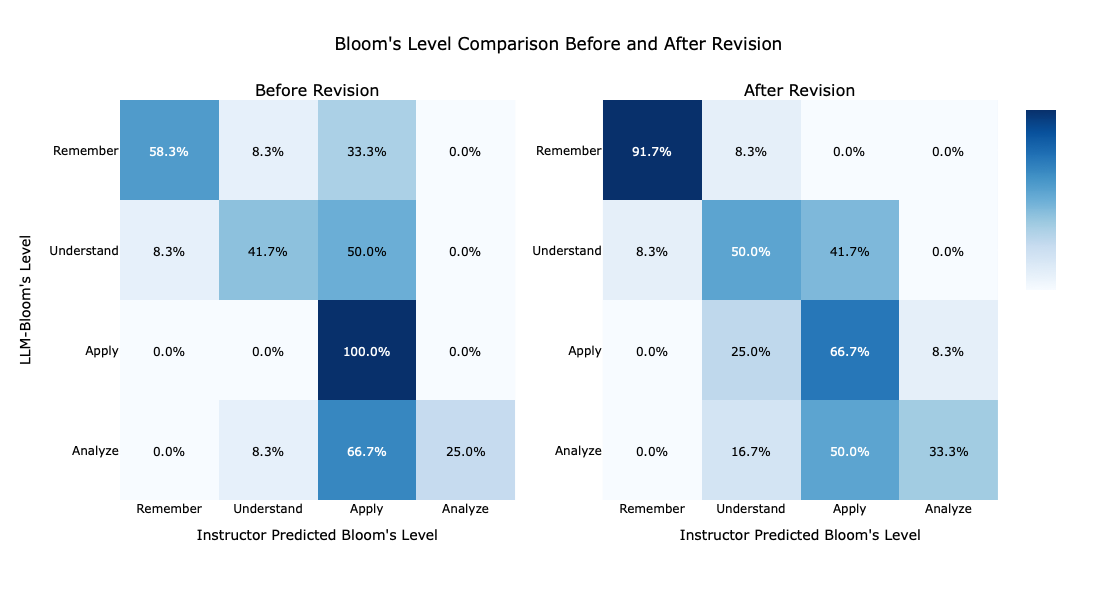

In [143]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Map objective values to labels
objective_labels = {1: 'Remember', 2: 'Understand', 3: 'Apply', 4: 'Analyze'}
df_flow['Objective_Label'] = df_flow['objective'].map(objective_labels)
df_flow['Teacher_Label'] = df_flow['Teacher_Blooms'].map(objective_labels)

df_flow2['Objective_Label'] = df_flow2['objective_x'].map(objective_labels)
df_flow2['Teacher_Label'] = df_flow2['Teacher_Blooms'].map(objective_labels)

# Define the desired order of labels
label_order = ['Remember', 'Understand', 'Apply', 'Analyze']
label_order_reverse = ['Analyze', 'Apply','Understand', 'Remember']

# Convert columns to categorical with the desired order
df_flow['Objective_Label'] = pd.Categorical(df_flow['Objective_Label'], categories=label_order_reverse, ordered=True)
df_flow['Teacher_Label'] = pd.Categorical(df_flow['Teacher_Label'], categories=label_order, ordered=True)

df_flow2['Objective_Label'] = pd.Categorical(df_flow2['Objective_Label'], categories=label_order_reverse, ordered=True)
df_flow2['Teacher_Label'] = pd.Categorical(df_flow2['Teacher_Label'], categories=label_order, ordered=True)

# Pivot the DataFrames to create matrices for the heatmaps, using the correct label order
heatmap_data1 = df_flow.pivot_table(index='Objective_Label', columns='Teacher_Label', values='count', fill_value=0)
heatmap_data2 = df_flow2.pivot_table(index='Objective_Label', columns='Teacher_Label', values='count', fill_value=0)

# Calculate percentages for annotations
heatmap_percentage1 = heatmap_data1.div(heatmap_data1.sum(axis=1), axis=0) * 100
heatmap_percentage2 = heatmap_data2.div(heatmap_data2.sum(axis=1), axis=0) * 100
# Determine the color
def get_font_color(z_value, max_value):
    # Use a heuristic: white for dark shades and black for light shades
    return 'white' if z_value > 0.5 * max_value else 'black'


# Create a subplot figure with two columns
fig = make_subplots(rows=1, cols=2, subplot_titles=('Before Revision', 'After Revision'))

# First heatmap (Before Revision)
fig.add_trace(go.Heatmap(
    z=heatmap_data1.values,
    x=heatmap_data1.columns,
    y=heatmap_data1.index,
    colorscale='Blues',  # Changed to blue scale
    colorbar=dict(
        tickvals=[heatmap_data1.values.min(), heatmap_data1.values.max()],
        ticktext=['', ''],
        len=0.5,  # Length of the colorbar
        y=0.75  # Position the colorbar in the middle of the first heatmap
    ),
    zmin=0,
    zmax=heatmap_data1.values.max()
), row=1, col=1)

# Add annotations for the first heatmap
for i, row in enumerate(heatmap_data1.index):
    for j, col in enumerate(heatmap_data1.columns):
        percentage = heatmap_percentage1.iloc[i, j]
        font_color = get_font_color(heatmap_data1.values[i, j], heatmap_data1.values.max())
        fig.add_annotation(
            x=j,
            y=i,
            text=f'{percentage:.1f}%',
            font=dict(size=12, color=font_color),
            showarrow=False,
            xref='x1',
            yref='y1'
        )

# Second heatmap (After Revision)
fig.add_trace(go.Heatmap(
    z=heatmap_data2.values,
    x=heatmap_data2.columns,
    y=heatmap_data2.index,
    colorscale='Blues',  # Changed to blue scale
    colorbar=dict(
        tickvals=[heatmap_data2.values.min(), heatmap_data2.values.max()],
        ticktext=['', ''],
        len=0.5,  # Length of the colorbar
        y=0.75  # Align it with the first colorbar
    ),
    zmin=0,
    zmax=heatmap_data2.values.max()
), row=1, col=2)

# Add annotations for the second heatmap
for i, row in enumerate(heatmap_data2.index):
    for j, col in enumerate(heatmap_data2.columns):
        percentage = heatmap_percentage2.iloc[i, j]
        font_color = get_font_color(heatmap_data2.values[i, j], heatmap_data2.values.max())
        fig.add_annotation(
            x=j,
            y=i,
            text=f'{percentage:.1f}%',
            font=dict(size=12, color=font_color),
            showarrow=False,
            xref='x2',
            yref='y2'
        )

# Update layout with annotations and other settings
fig.update_layout(
    title_text="Bloom's Level Comparison Before and After Revision",
    title_x=0.5,
    font=dict(size=12, color='black'),
    width=1200,  # Adjust width
    height=600,  # Adjust height
    margin=dict(l=120, r=120, t=100, b=100)
)

# Update axes labels
fig.update_xaxes(title_text="Instructor Predicted Bloom's Level", row=1, col=1)
fig.update_yaxes(title_text="LLM-Bloom's Level", row=1, col=1)
fig.update_xaxes(title_text="Instructor Predicted Bloom's Level", row=1, col=2)
fig.update_yaxes(title_text="", row=1, col=2)

# Show the plot
fig.show()


In [144]:
heatmap_data1 = df_flow.pivot_table(index=pd.Categorical(df_flow['Objective_Label'], categories=label_order, ordered=True), columns=pd.Categorical(df_flow['Teacher_Label'], categories=label_order, ordered=True),values='count', fill_value=0)

KeyError: 'Remember'

In [145]:
## Need to compare the overall quality in the first round vs second round
# Both rounds overall evaluation score
# Then create the graph

In [146]:
value

0     7
1     1
2     4
3     1
4     5
5     6
6    12
7     1
8     8
9     3
Name: count, dtype: int64

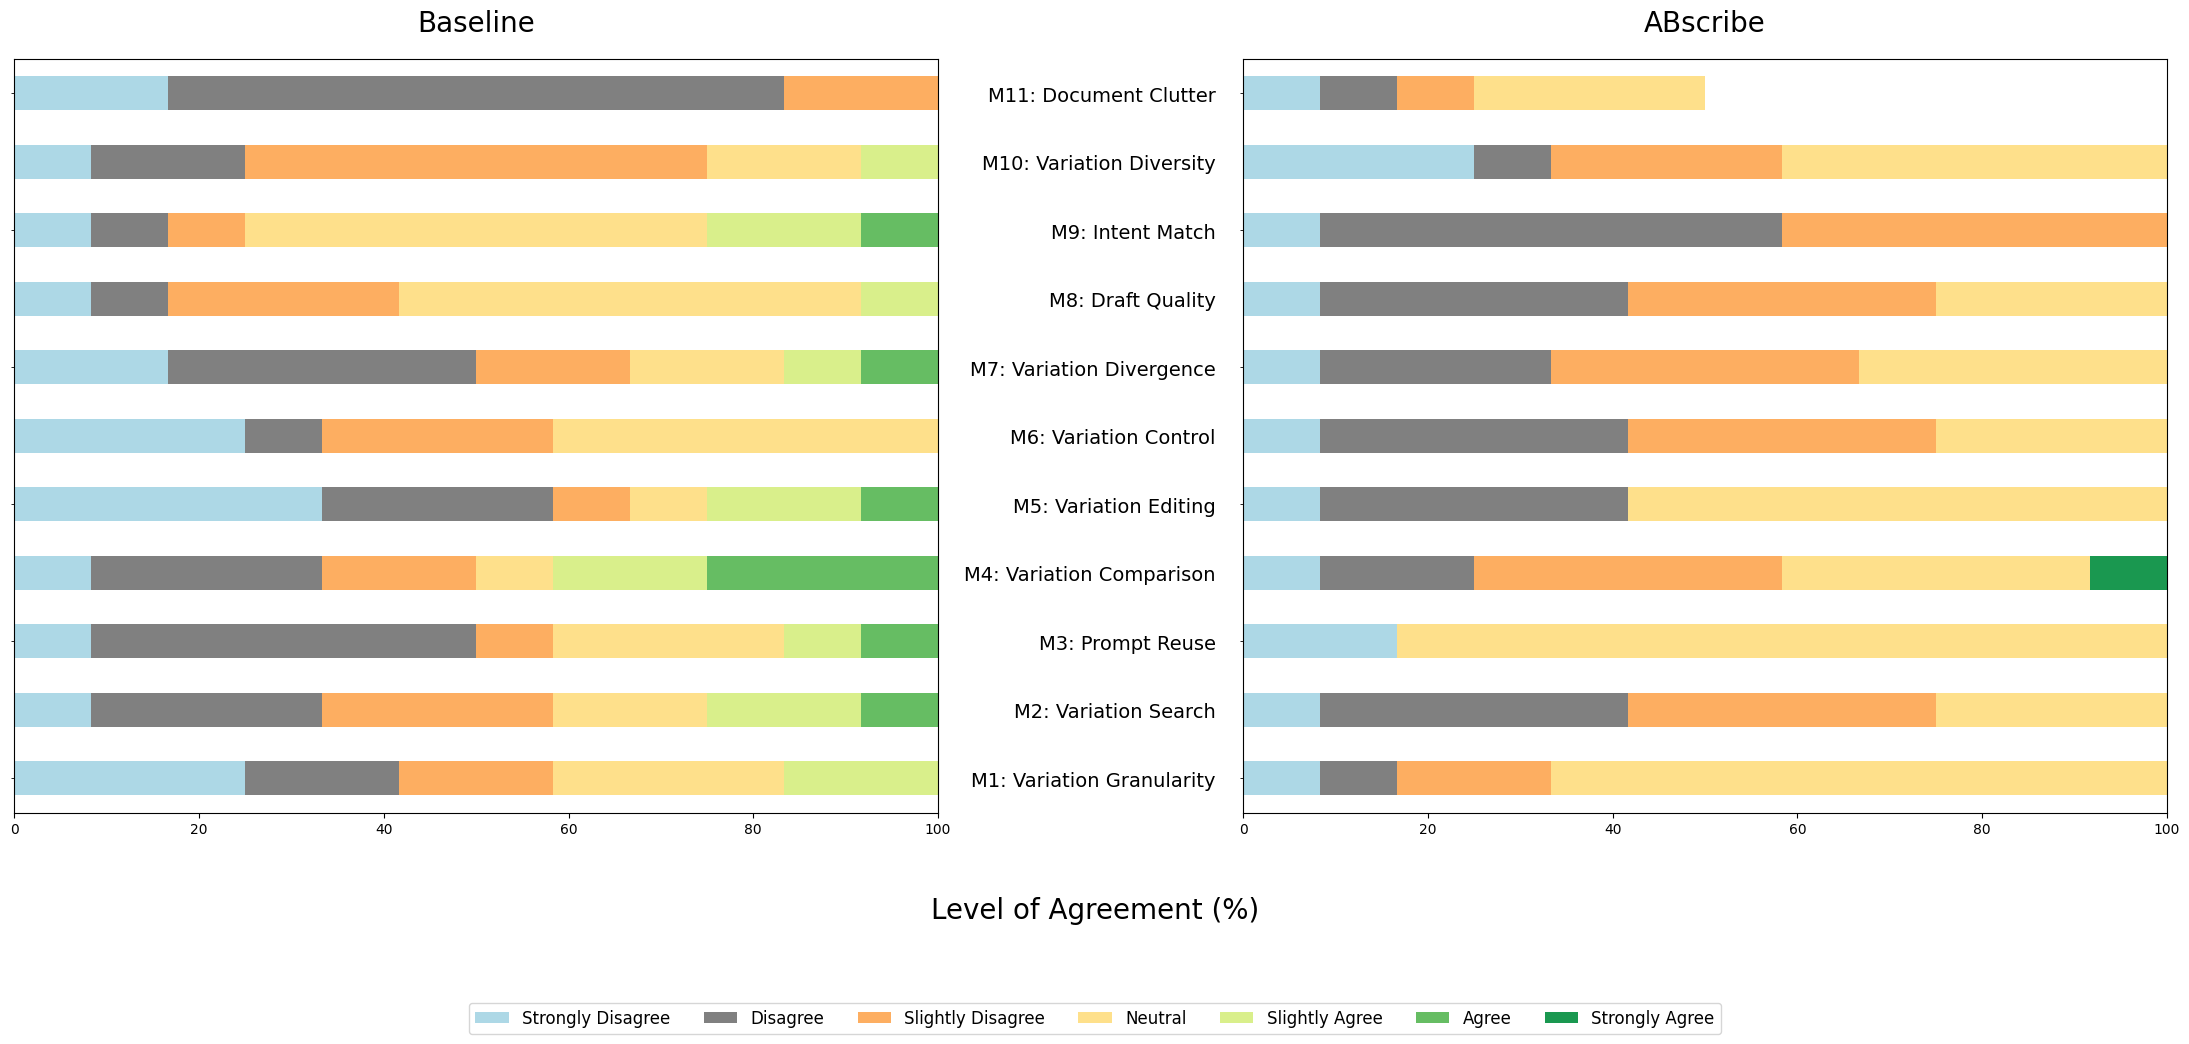

In [147]:
import matplotlib.pyplot as plt
import pandas as pd

# Sample data based on your image
categories = ['M1: Variation Granularity', 'M2: Variation Search', 'M3: Prompt Reuse', 
              'M4: Variation Comparison', 'M5: Variation Editing', 'M6: Variation Control', 
              'M7: Variation Divergence', 'M8: Draft Quality', 'M9: Intent Match', 
              'M10: Variation Diversity', 'M11: Document Clutter']

data_baseline = {
    'Strongly Disagree': [25, 8.33, 8.33, 8.33, 33.33, 25, 16.67, 8.33, 8.33, 8.33, 16.67],
    'Disagree': [16.67, 25, 41.67, 25, 25, 8.33, 33.33, 8.33, 8.33, 16.67, 66.67],
    'Slightly Disagree': [16.67, 25, 8.33, 16.67, 8.33, 25, 16.67, 25, 8.33, 50, 25],
    'Neutral': [25, 16.67, 25, 8.33, 8.33, 41.67, 16.67, 50, 50, 16.67, 8.33],
    'Slightly Agree': [16.67, 16.67, 8.33, 16.67, 16.67, 16.67, 8.33, 16.67, 16.67, 16.67, 8.33],
    'Agree': [8.33, 8.33, 8.33, 25, 16.67, 16.67, 8.33, 16.67, 16.67, 8.33, 8.33],
    'Strongly Agree': [8.33, 8.33, 25, 16.67, 8.33, 16.67, 8.33, 8.33, 16.67, 8.33, 0]
}

data_abscribe = {
    'Strongly Disagree': [8.33, 8.33, 16.67, 8.33, 8.33, 8.33, 8.33, 8.33, 8.33, 25, 8.33],
    'Disagree': [8.33, 33.33, 0, 16.67, 33.33, 33.33, 25, 33.33, 50, 8.33, 8.33],
    'Slightly Disagree': [16.67, 33.33, 0, 33.33, 0, 33.33, 33.33, 33.33, 41.67, 25, 8.33],
    'Neutral': [66.67, 25, 83.33, 33.33, 58.33, 58.33, 33.33, 58.33, 41.67, 41.67, 25],
    'Slightly Agree': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'Agree': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'Strongly Agree': [0, 0, 0, 41.67, 0, 0, 0, 0, 0, 0, 0]
}

# Create DataFrames
df_baseline = pd.DataFrame(data_baseline, index=categories)
df_abscribe = pd.DataFrame(data_abscribe, index=categories)

def plot_stacked_bar(ax, df, title):
    df.plot(kind='barh', stacked=True, color=['lightblue', 'gray', '#fdae61', '#fee08b', '#d9ef8b', '#66bd63', '#1a9850'], ax=ax)
    ax.set_title(title, pad=20, fontsize =20)
    ax.set_xlim(0, 100)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.legend().set_visible(False)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10), gridspec_kw={'width_ratios': [1, 1]}, sharey=True)

# Plot each graph
plot_stacked_bar(ax1, df_baseline, 'Baseline')
plot_stacked_bar(ax2, df_abscribe, 'ABscribe')

# Remove x-axis labels (level of agreement) from individual plots
ax1.set_xlabel('')
ax2.set_xlabel('')

# Remove the y-axis category labels from both plots
ax1.set_yticks([])
ax1.set_yticklabels([])
ax2.set_yticks([])
ax2.set_yticklabels([])

# Add the y-axis category labels in the center, between the two plots
for i, category in enumerate(categories):
    plt.text(-3, i, category, ha='right', va='center_baseline', fontsize=14)

# Add the x-axis label centered below the two plots
fig.supxlabel('Level of Agreement (%)', fontsize=20, y=0.02)

# Show the legend only once, between the two graphs
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=7, fontsize=12)

# Adjust layout to ensure no overlap, increasing the space between plots using `wspace`
plt.subplots_adjust(wspace=0.)  # Adjust this value to control the space between the two plots
plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Leave space at the bottom for the common xlabel
plt.show()


In [148]:
first_round.columns


Index(['Unnamed: 0', 'participant_ID', 'question_ID', 'Relevant',
       'Correct_Info', 'Grammatical', 'Enough_Info', 'Correct_Marked',
       'One_Correct', 'Distinct_Option', 'Plausible', 'Usable', 'LG_Progress',
       'Teacher_Blooms', 'Level_feedback', 'improve_feedback', 'context',
       'context_explain', 'additional_feedback', 'objective', 'learning_goal',
       'strategy', 'scenario', 'question', 'options', 'correct_answer',
       'explanation', 'textbook_section', 'model', 'analysis'],
      dtype='object')

In [149]:
first_round['Grammatical'].value_counts()/ len(first_round)


Grammatical
2    0.937500
1    0.041667
0    0.020833
Name: count, dtype: float64

In [150]:
first_round_percents['Relevant'] = first_round['Relevant'].value_counts()/len(first_round)

NameError: name 'first_round_percents' is not defined

In [151]:
# Initialize the DataFrame
response_values = [0, 1, 2]
first_round_percent = pd.DataFrame({'response_value': response_values})

# List of column names to iterate over
columns = ['Grammatical', 'Correct_Info', 'Enough_Info', 'Correct_Marked', 'One_Correct', 'Relevant', 'Distinct_Option', 'Plausible', 'LG_Progress']

# Loop over each column, calculate the percentage, and map it to the first_round_percent DataFrame
for column in columns:
    percent_values = first_round[column].value_counts(normalize=True)*100
    first_round_percent[column] = first_round_percent['response_value'].map(percent_values)

# Display the resulting DataFrame
first_round_percent



# Fill any NaN values with 0 (in case a particular 'response_value' has no corresponding rows)
first_round_percent.fillna(0, inplace=True)

first_round_percent

response_value  Grammatical  Correct_Info  Enough_Info  Correct_Marked  \
0               0     2.083333      6.250000     8.510638        4.166667   
1               1     4.166667      4.166667    12.765957       12.500000   
2               2    93.750000     89.583333    78.723404       83.333333   

   One_Correct  Relevant  Distinct_Option  Plausible  LG_Progress  
0         0.00      0.00         4.166667  14.583333     2.083333  
1         6.25      6.25        10.416667   8.333333    14.583333  
2        93.75     93.75        85.416667  77.083333    83.333333

In [152]:
# Initialize the DataFrame
response_values = [0, 1, 2]
second_round_percent = pd.DataFrame({'response_value': response_values})

# List of column names to iterate over
columns = ['Grammatical', 'Correct_Info', 'Enough_Info', 'Correct_Marked', 'One_Correct', 'Relevant', 'Distinct_Option', 'Plausible', 'LG_Progress']

# Loop over each column, calculate the percentage, and map it to the first_round_percent DataFrame
for column in columns:
    percent_values = second_round[column].value_counts(normalize=True)*100
    second_round_percent[column] = second_round_percent['response_value'].map(percent_values)

# Display the resulting DataFrame
second_round_percent



# Fill any NaN values with 0 (in case a particular 'response_value' has no corresponding rows)
second_round_percent.fillna(0, inplace=True)

second_round_percent

response_value  Grammatical  Correct_Info  Enough_Info  Correct_Marked  \
0               0     4.166667           0.0     6.250000        4.166667   
1               1    10.416667           0.0     4.166667        0.000000   
2               2    85.416667         100.0    89.583333       95.833333   

   One_Correct  Relevant  Distinct_Option  Plausible  LG_Progress  
0     2.083333       0.0         6.382979  10.638298         6.25  
1    10.416667       0.0         8.510638   2.127660        18.75  
2    87.500000     100.0        85.106383  87.234043        75.00

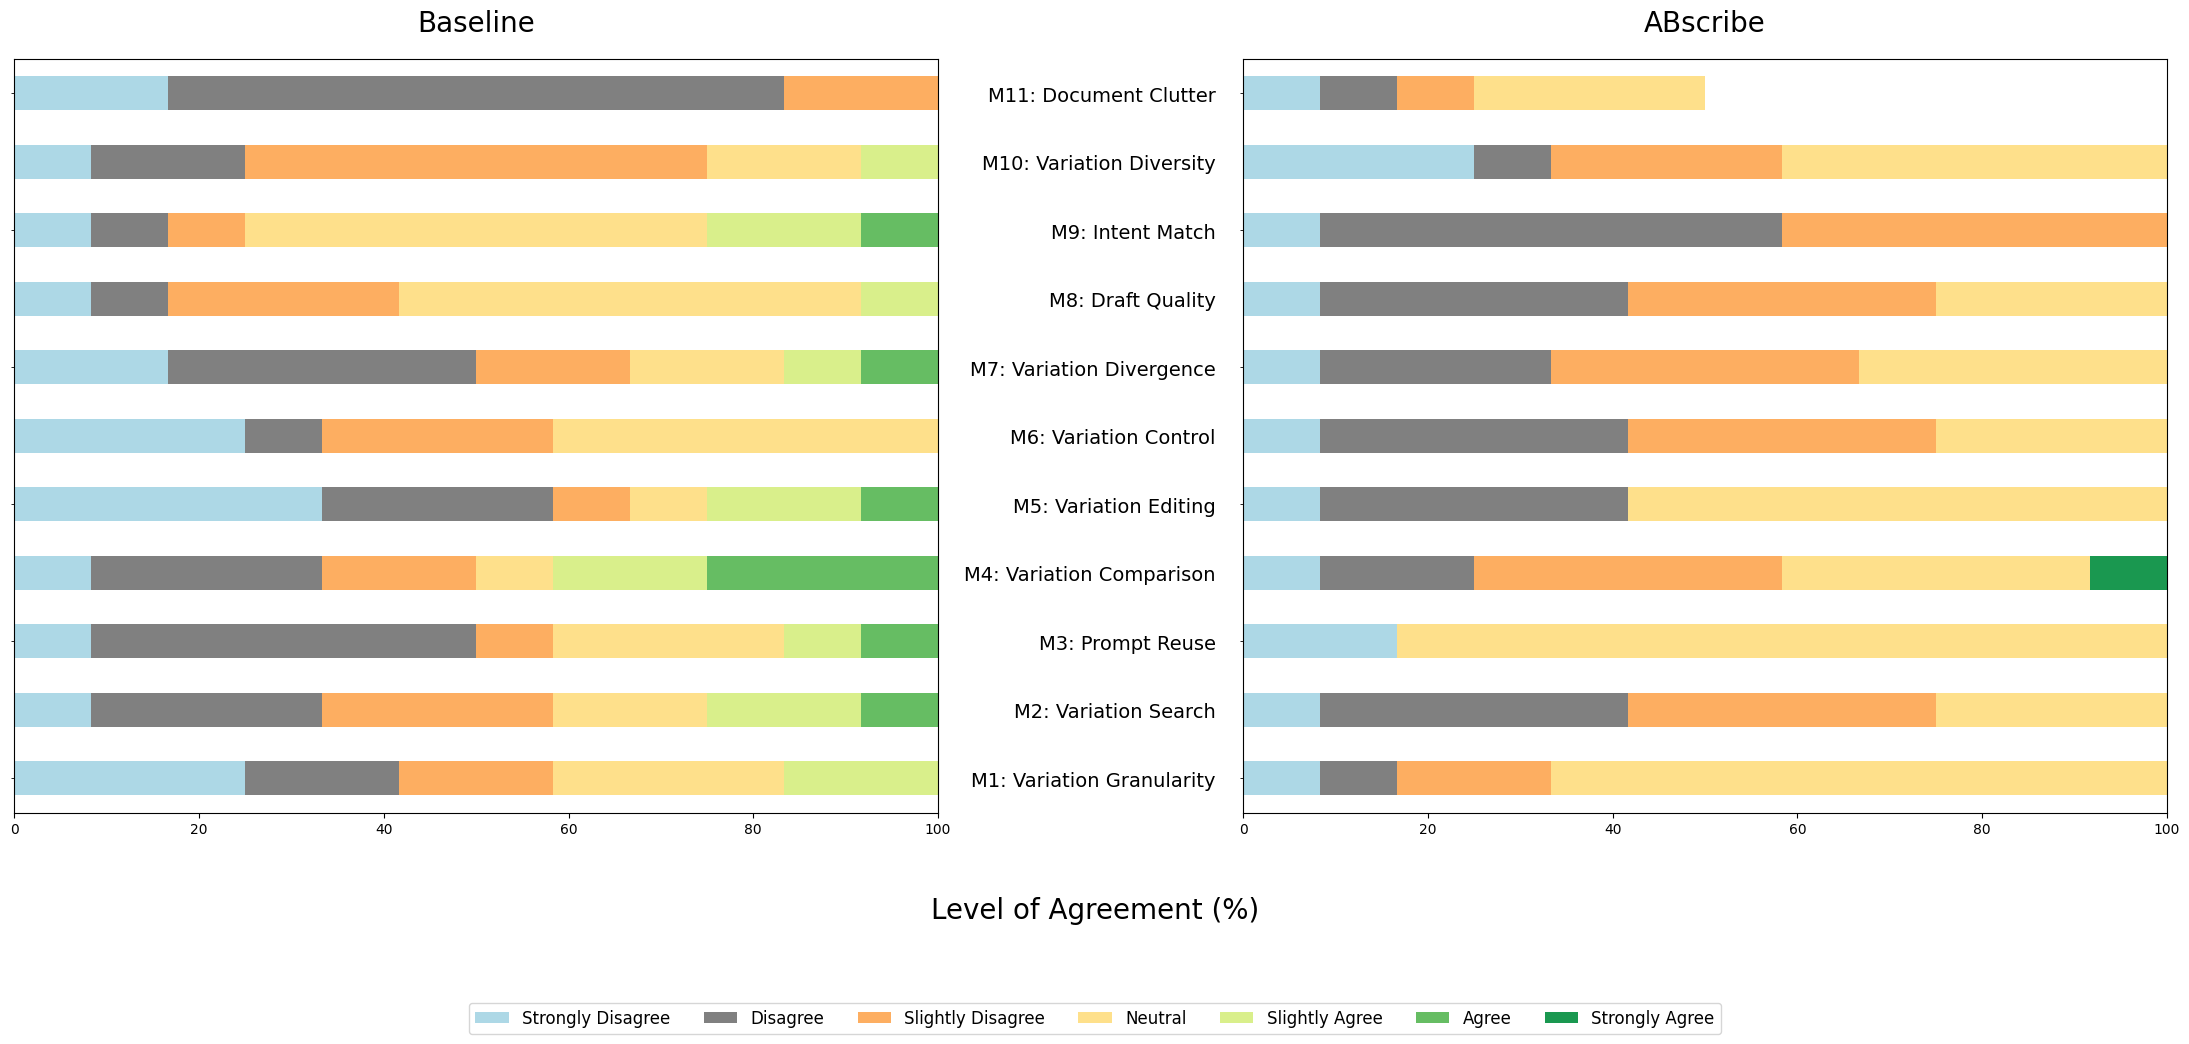

In [153]:
import matplotlib.pyplot as plt
import pandas as pd

# Sample data based on your image
categories = ['M1: Variation Granularity', 'M2: Variation Search', 'M3: Prompt Reuse', 
              'M4: Variation Comparison', 'M5: Variation Editing', 'M6: Variation Control', 
              'M7: Variation Divergence', 'M8: Draft Quality', 'M9: Intent Match', 
              'M10: Variation Diversity', 'M11: Document Clutter']

data_baseline = {
    'Strongly Disagree': [25, 8.33, 8.33, 8.33, 33.33, 25, 16.67, 8.33, 8.33, 8.33, 16.67],
    'Disagree': [16.67, 25, 41.67, 25, 25, 8.33, 33.33, 8.33, 8.33, 16.67, 66.67],
    'Slightly Disagree': [16.67, 25, 8.33, 16.67, 8.33, 25, 16.67, 25, 8.33, 50, 25],
    'Neutral': [25, 16.67, 25, 8.33, 8.33, 41.67, 16.67, 50, 50, 16.67, 8.33],
    'Slightly Agree': [16.67, 16.67, 8.33, 16.67, 16.67, 16.67, 8.33, 16.67, 16.67, 16.67, 8.33],
    'Agree': [8.33, 8.33, 8.33, 25, 16.67, 16.67, 8.33, 16.67, 16.67, 8.33, 8.33],
    'Strongly Agree': [8.33, 8.33, 25, 16.67, 8.33, 16.67, 8.33, 8.33, 16.67, 8.33, 0]
}

data_abscribe = {
    'Strongly Disagree': [8.33, 8.33, 16.67, 8.33, 8.33, 8.33, 8.33, 8.33, 8.33, 25, 8.33],
    'Disagree': [8.33, 33.33, 0, 16.67, 33.33, 33.33, 25, 33.33, 50, 8.33, 8.33],
    'Slightly Disagree': [16.67, 33.33, 0, 33.33, 0, 33.33, 33.33, 33.33, 41.67, 25, 8.33],
    'Neutral': [66.67, 25, 83.33, 33.33, 58.33, 58.33, 33.33, 58.33, 41.67, 41.67, 25],
    'Slightly Agree': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'Agree': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'Strongly Agree': [0, 0, 0, 41.67, 0, 0, 0, 0, 0, 0, 0]
}

# Create DataFrames
df_baseline = pd.DataFrame(data_baseline, index=categories)
df_abscribe = pd.DataFrame(data_abscribe, index=categories)

def plot_stacked_bar(ax, df, title):
    df.plot(kind='barh', stacked=True, color=['lightblue', 'gray', '#fdae61', '#fee08b', '#d9ef8b', '#66bd63', '#1a9850'], ax=ax)
    ax.set_title(title, pad=20, fontsize =20)
    ax.set_xlim(0, 100)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.legend().set_visible(False)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10), gridspec_kw={'width_ratios': [1, 1]}, sharey=True)

# Plot each graph
plot_stacked_bar(ax1, df_baseline, 'Baseline')
plot_stacked_bar(ax2, df_abscribe, 'ABscribe')

# Remove x-axis labels (level of agreement) from individual plots
ax1.set_xlabel('')
ax2.set_xlabel('')

# Remove the y-axis category labels from both plots
ax1.set_yticks([])
ax1.set_yticklabels([])
ax2.set_yticks([])
ax2.set_yticklabels([])

# Add the y-axis category labels in the center, between the two plots
for i, category in enumerate(categories):
    plt.text(-3, i, category, ha='right', va='center_baseline', fontsize=14)

# Add the x-axis label centered below the two plots
fig.supxlabel('Level of Agreement (%)', fontsize=20, y=0.02)

# Show the legend only once, between the two graphs
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=7, fontsize=12)

# Adjust layout to ensure no overlap, increasing the space between plots using `wspace`
plt.subplots_adjust(wspace=0.)  # Adjust this value to control the space between the two plots
plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Leave space at the bottom for the common xlabel
plt.show()


In [154]:
second_round['context'].value_counts(normalize=True)

context
Exam Question                                                                                                                                                          0.391304
Home Practice Question                                                                                                                                                 0.369565
Reading Comprehension                                                                                                                                                  0.043478
The definitions in Option A and B would lead to confusion.  I would not use it.                                                                                        0.021739
Until it is corrected, for nothing. Unless the objective is to make the student realize that they don't have enough information to answer the question completely.     0.021739
The garbage.                                                                                                    

In [155]:
second_round_percent

response_value  Grammatical  Correct_Info  Enough_Info  Correct_Marked  \
0               0     4.166667           0.0     6.250000        4.166667   
1               1    10.416667           0.0     4.166667        0.000000   
2               2    85.416667         100.0    89.583333       95.833333   

   One_Correct  Relevant  Distinct_Option  Plausible  LG_Progress  
0     2.083333       0.0         6.382979  10.638298         6.25  
1    10.416667       0.0         8.510638   2.127660        18.75  
2    87.500000     100.0        85.106383  87.234043        75.00

In [156]:
first_round_low=list(first_round_percent.iloc[0])[1:]

In [157]:
first_round_medium = list(first_round_percent.iloc[1])[1:]
first_round_high = list(first_round_percent.iloc[2])[1:]
second_round_low = list(second_round_percent.iloc[0])[1:]
second_round_medium = list(second_round_percent.iloc[1])[1:]
second_round_high = list(second_round_percent.iloc[2])[1:]

In [158]:
first_round_low

[2.083333333333333,
 6.25,
 8.51063829787234,
 4.166666666666666,
 0.0,
 0.0,
 4.166666666666666,
 14.583333333333334,
 2.083333333333333]

In [159]:
first_round_low, first_round_medium, first_round_high

([2.083333333333333,
  6.25,
  8.51063829787234,
  4.166666666666666,
  0.0,
  0.0,
  4.166666666666666,
  14.583333333333334,
  2.083333333333333],
 [4.166666666666666,
  4.166666666666666,
  12.76595744680851,
  12.5,
  6.25,
  6.25,
  10.416666666666668,
  8.333333333333332,
  14.583333333333334],
 [93.75,
  89.58333333333334,
  78.72340425531915,
  83.33333333333334,
  93.75,
  93.75,
  85.41666666666666,
  77.08333333333334,
  83.33333333333334])

In [160]:
first_round_medium

[4.166666666666666,
 4.166666666666666,
 12.76595744680851,
 12.5,
 6.25,
 6.25,
 10.416666666666668,
 8.333333333333332,
 14.583333333333334]

In [161]:
first_round_high

[93.75,
 89.58333333333334,
 78.72340425531915,
 83.33333333333334,
 93.75,
 93.75,
 85.41666666666666,
 77.08333333333334,
 83.33333333333334]

In [162]:
second_round_low, second_round_medium, second_round_high

([4.166666666666666,
  0.0,
  6.25,
  4.166666666666666,
  2.083333333333333,
  0.0,
  6.382978723404255,
  10.638297872340425,
  6.25],
 [10.416666666666668,
  0.0,
  4.166666666666666,
  0.0,
  10.416666666666668,
  0.0,
  8.51063829787234,
  2.127659574468085,
  18.75],
 [85.41666666666666,
  100.0,
  89.58333333333334,
  95.83333333333334,
  87.5,
  100.0,
  85.1063829787234,
  87.2340425531915,
  75.0])

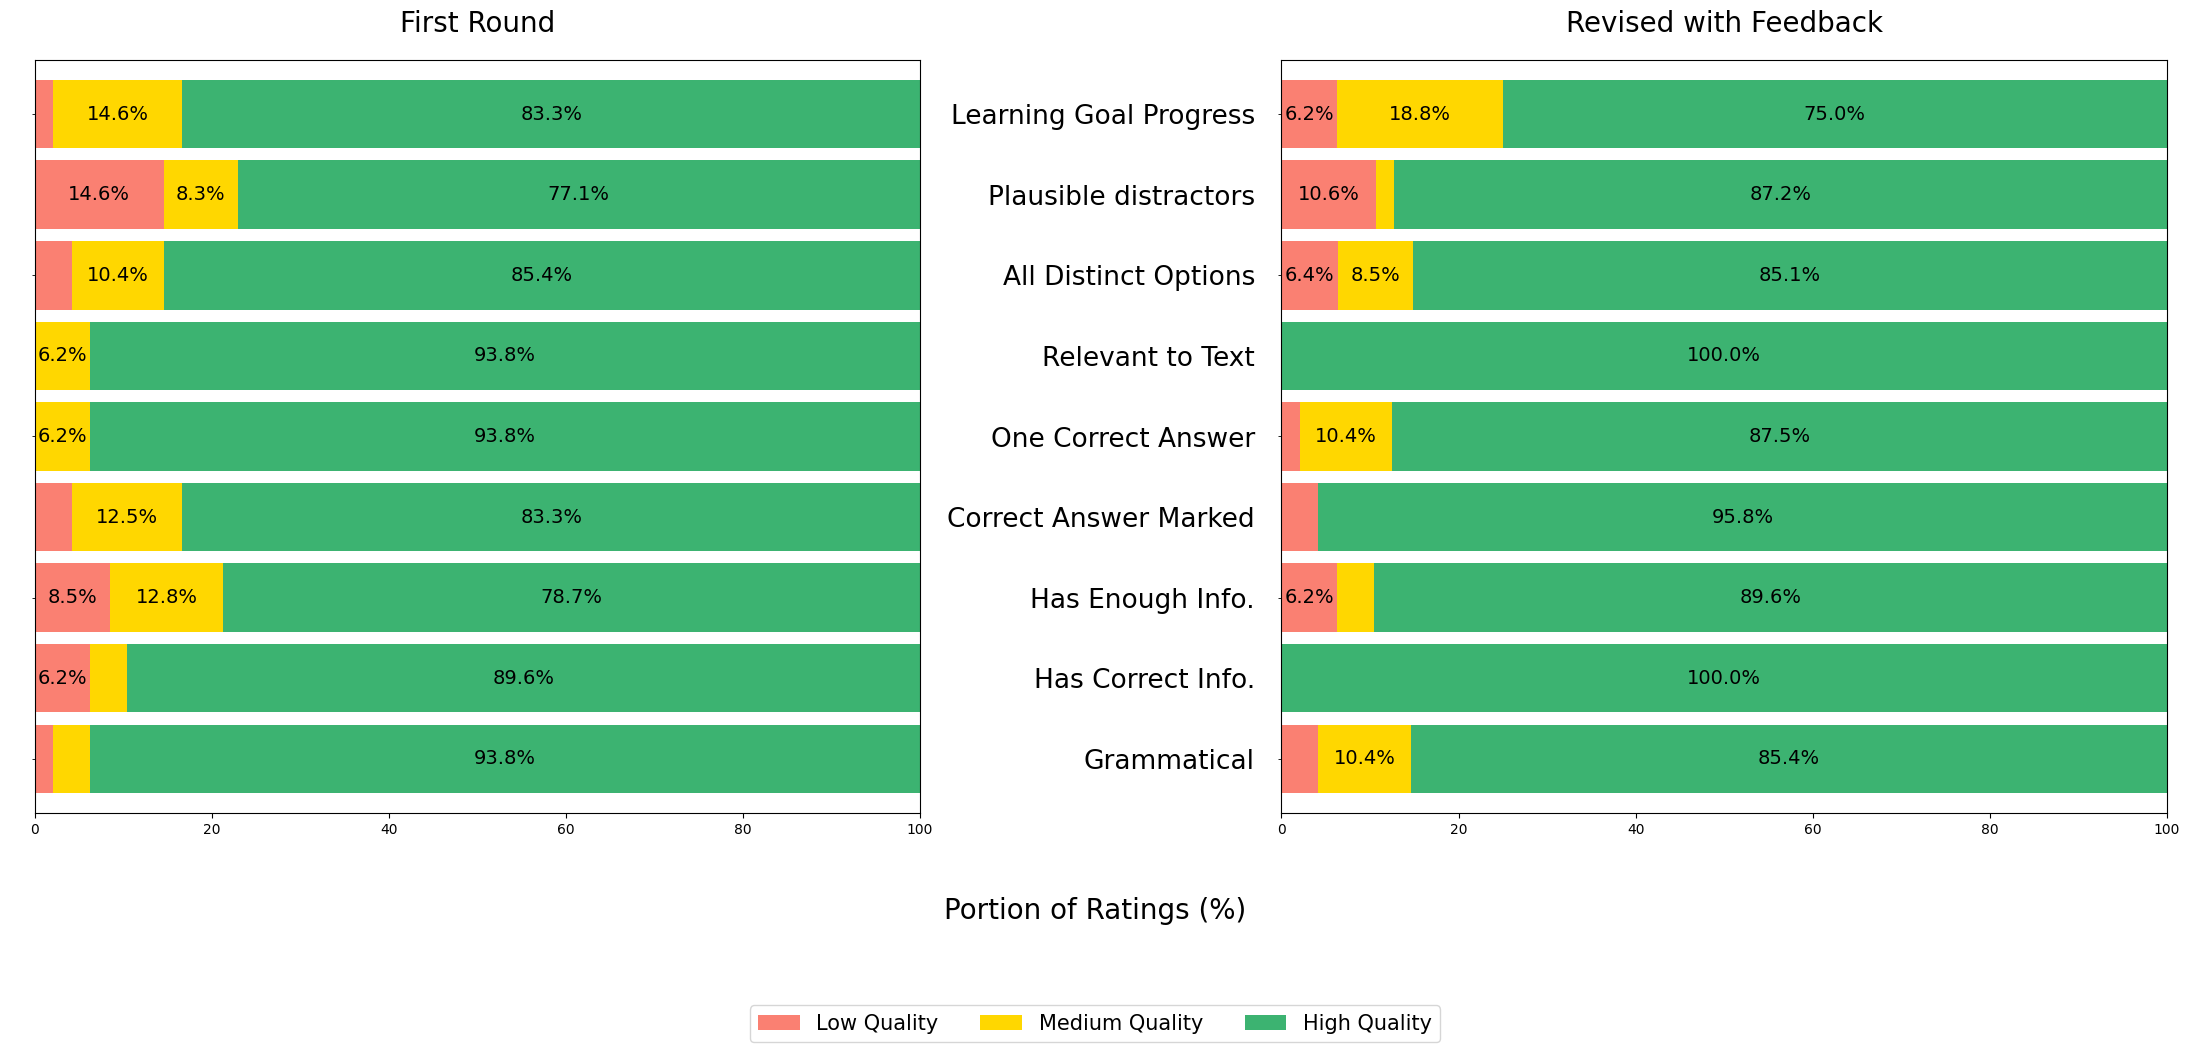

In [163]:
import matplotlib.pyplot as plt
import pandas as pd

# Sample data based on your image
categories = ['Grammatical', 'Has Correct Info.', 'Has Enough Info.', 'Correct Answer Marked', 'One Correct Answer', 'Relevant to Text', 'All Distinct Options', 'Plausible distractors', 'Learning Goal Progress']

data_baseline = {
    'Low Quality': first_round_low,
    'Medium Quality':first_round_medium,
    'High Quality': first_round_high,
    
}

data_second = {
    'Low Quality': second_round_low,
    'Medium Quality': second_round_medium,
    'High Quality': second_round_high
}

# Create DataFrames
# Create DataFrames
df_baseline = pd.DataFrame(data_baseline, index=categories)
df_second = pd.DataFrame(data_second, index=categories)

def plot_stacked_bar(ax, df, title):
    # Plot the stacked bar chart
    df.plot(kind='barh', stacked=True, color=['salmon', 'gold', 'mediumseagreen'], ax=ax, width=0.85)
    
    # Add proportions on bars
    for i, (category, row) in enumerate(df.iterrows()):
        bottom = 0
        for j, (value, color) in enumerate(zip(row, ['salmon', 'gold', 'mediumseagreen'])):
            if value > 5:
                ax.text(value / 2 + bottom, i, f'{value:.1f}%', ha='center', va='center', fontsize=14, color='black')
                bottom += value
            else:
               
                ax.text(value / 2 + bottom, i, f'{value:.1f}%', ha='center', va='center', fontsize=14, color='none')
                bottom += value
    
    ax.set_title(title, pad=20, fontsize=20)
    ax.set_xlim(0, 100)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.legend().set_visible(False)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10), gridspec_kw={'width_ratios': [1, 1]}, sharey=True)

# Plot each graph
plot_stacked_bar(ax1, df_baseline, 'First Round')
plot_stacked_bar(ax2, df_second, 'Revised with Feedback')

# Remove x-axis labels (level of agreement) from individual plots
ax1.set_xlabel('')
ax2.set_xlabel('')

# Remove the y-axis category labels from both plots
ax1.set_yticks([])
ax1.set_yticklabels([])
ax2.set_yticks([])
ax2.set_yticklabels([])

# Add the y-axis category labels in the center, between the two plots
for i, category in enumerate(categories):
    plt.text(-3, i, category, ha='right', va='center_baseline', fontsize=19)

# Add the x-axis label centered below the two plots
fig.supxlabel('Portion of Ratings (%)', fontsize=20, y=0.02)

# Show the legend only once, between the two graphs
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3, fontsize=15)

# Adjust layout to ensure no overlap, increasing the space between plots using `wspace`
plt.subplots_adjust(wspace=0.)  # Adjust this value to control the space between the two plots
plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Leave space at the bottom for the common xlabel
plt.show()


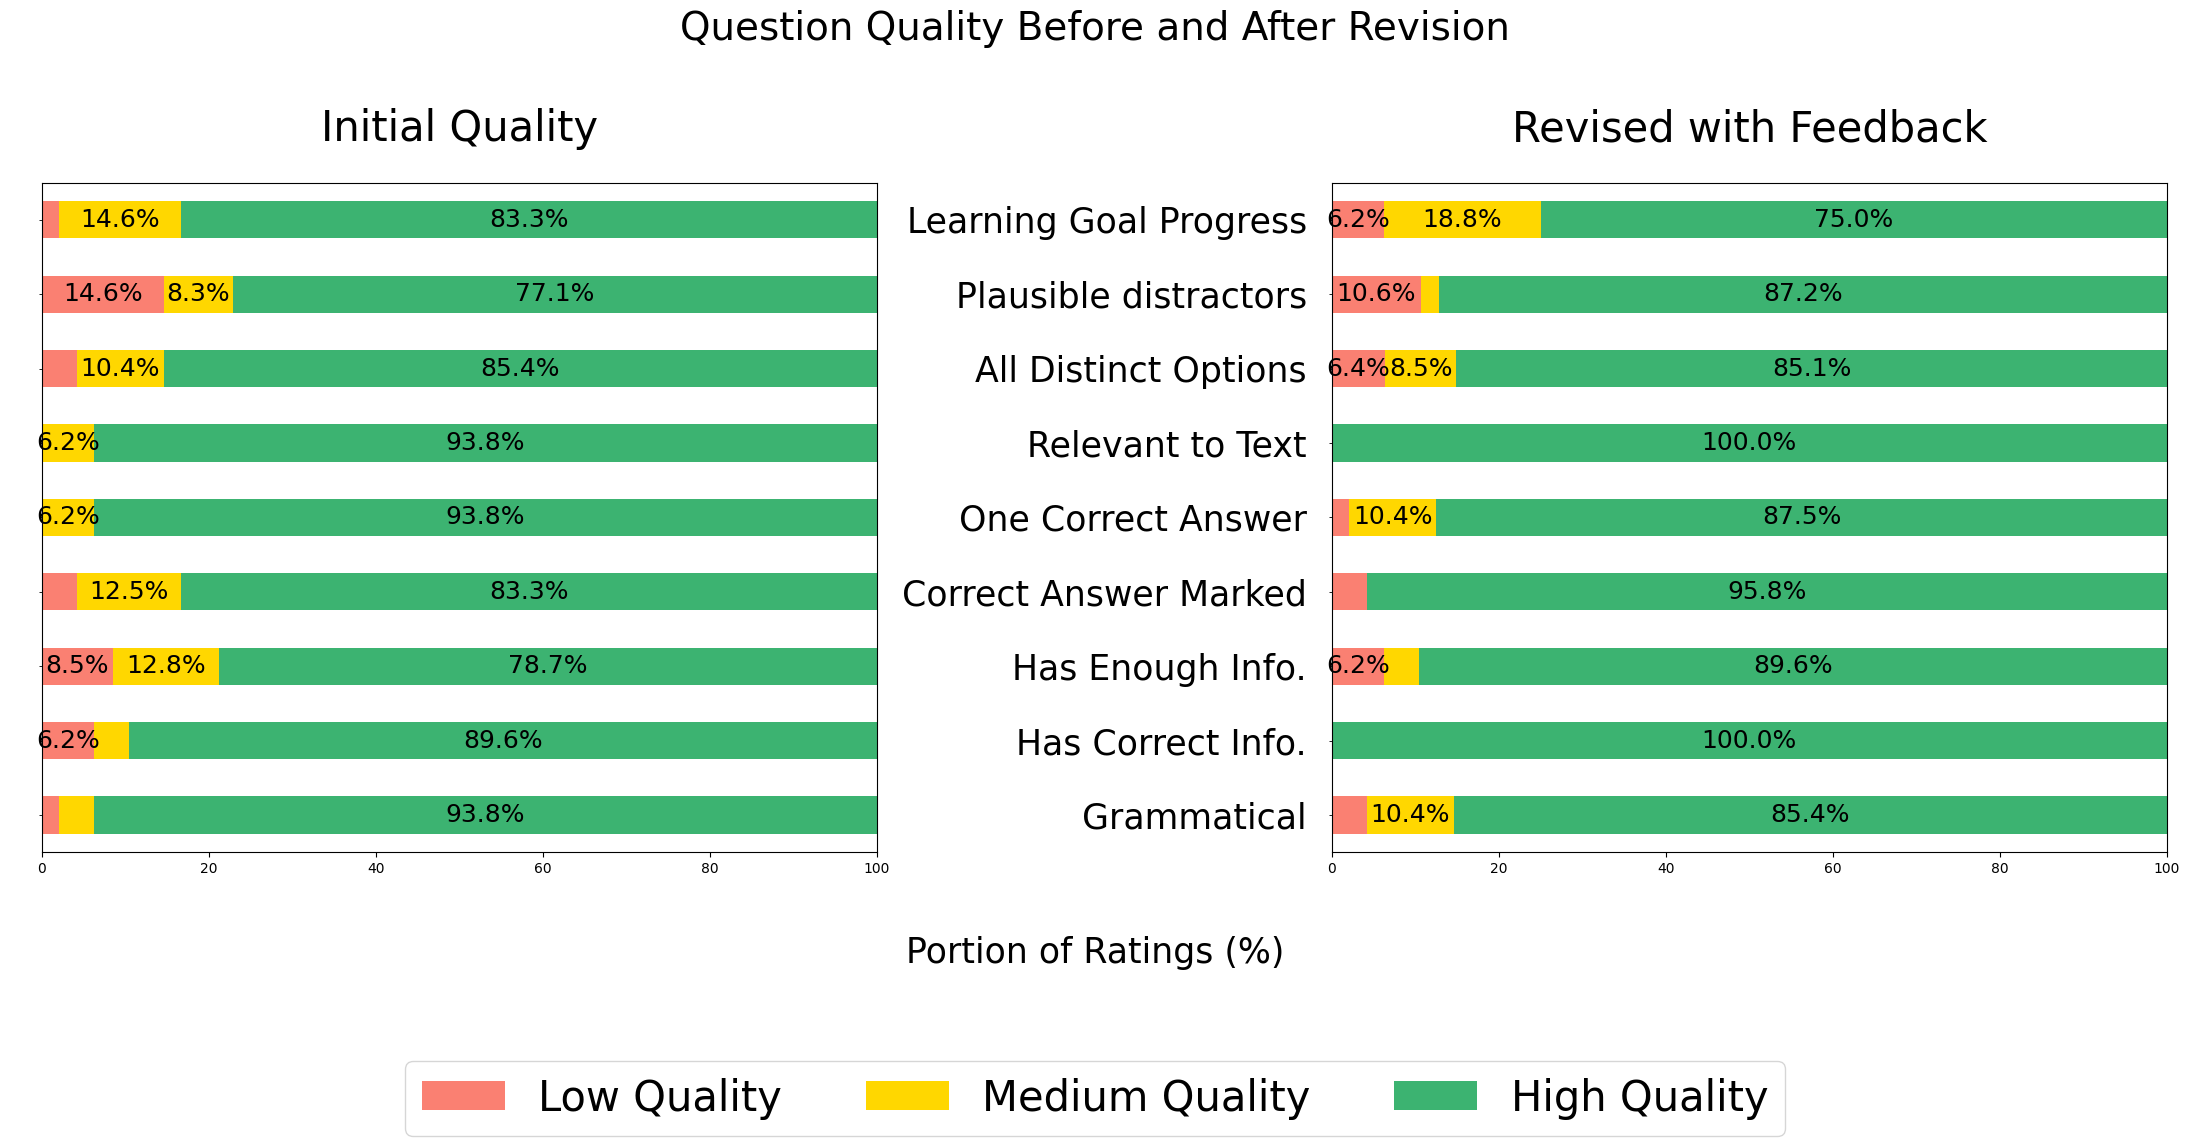

In [164]:
import matplotlib.pyplot as plt
import pandas as pd

# Sample data based on your image
categories = ['Grammatical', 'Has Correct Info.', 'Has Enough Info.', 'Correct Answer Marked', 'One Correct Answer', 'Relevant to Text', 'All Distinct Options', 'Plausible distractors', 'Learning Goal Progress']

data_baseline = {
    'Low Quality': first_round_low,
    'Medium Quality':first_round_medium,
    'High Quality': first_round_high,
    
}

data_second = {
    'Low Quality': second_round_low,
    'Medium Quality': second_round_medium,
    'High Quality': second_round_high
}

# Create DataFrames
# Create DataFrames
df_baseline = pd.DataFrame(data_baseline, index=categories)
df_second = pd.DataFrame(data_second, index=categories)

def plot_stacked_bar(ax, df, title):
    # Plot the stacked bar chart
    df.plot(kind='barh', stacked=True, color=['salmon', 'gold', 'mediumseagreen'], ax=ax)
    
    # Add proportions on bars
    for i, (category, row) in enumerate(df.iterrows()):
        bottom = 0
        for j, (value, color) in enumerate(zip(row, ['salmon', 'gold', 'mediumseagreen'])):
            if value > 5:
                ax.text(value / 2 + bottom, i, f'{value:.1f}%', ha='center', va='center', fontsize=18, color='black')
                bottom += value
            else:
               
                ax.text(value / 2 + bottom, i, f'{value:.1f}%', ha='center', va='center', fontsize=18, color='none')
                bottom += value
        
    
    ax.set_title(title, pad=30, fontsize=30)
    ax.set_xlim(0, 100)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.legend().set_visible(False)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10), gridspec_kw={'width_ratios': [1, 1]}, sharey=True)

# Plot each graph
plot_stacked_bar(ax1, df_baseline, 'Initial Quality')
plot_stacked_bar(ax2, df_second, 'Revised with Feedback')

# Remove x-axis labels (level of agreement) from individual plots
ax1.set_xlabel('')
ax2.set_xlabel('')

# Remove the y-axis category labels from both plots
ax1.set_yticks([])
ax1.set_yticklabels([])
ax2.set_yticks([])
ax2.set_yticklabels([])

# Add the y-axis category labels in the center, between the two plots
for i, category in enumerate(categories):
    plt.text(-3, i, category, ha='right', va='center_baseline', fontsize=25)

# Add the x-axis label centered below the two plots
fig.supxlabel('Portion of Ratings (%)', fontsize=25, y=0.02)

# Show the legend only once, between the two graphs
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3, fontsize=30)

fig.suptitle('Question Quality Before and After Revision', fontsize=28)

# Adjust layout to ensure no overlap, increasing the space between plots using `wspace`
plt.subplots_adjust(top=0.65)  # Adjust this value to control the space between the two plots
# Adjust layout to ensure no overlap, adding space at the top for the suptitle
plt.subplots_adjust(top=0.5, wspace=0.3)  # Increase `top` to add space for suptitle
plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Leave space at the bottom for the common xlabel

plt.show()


In [165]:
first_round['Usable'].value_counts(normalize =True)

Usable
1    0.708333
0    0.291667
Name: proportion, dtype: float64

In [166]:
second_round['Usable'].value_counts(normalize =True)

Usable
1    0.666667
0    0.333333
Name: proportion, dtype: float64

In [167]:
first_round.columns

Index(['Unnamed: 0', 'participant_ID', 'question_ID', 'Relevant',
       'Correct_Info', 'Grammatical', 'Enough_Info', 'Correct_Marked',
       'One_Correct', 'Distinct_Option', 'Plausible', 'Usable', 'LG_Progress',
       'Teacher_Blooms', 'Level_feedback', 'improve_feedback', 'context',
       'context_explain', 'additional_feedback', 'objective', 'learning_goal',
       'strategy', 'scenario', 'question', 'options', 'correct_answer',
       'explanation', 'textbook_section', 'model', 'analysis'],
      dtype='object')

NameError: name 'wedges1' is not defined

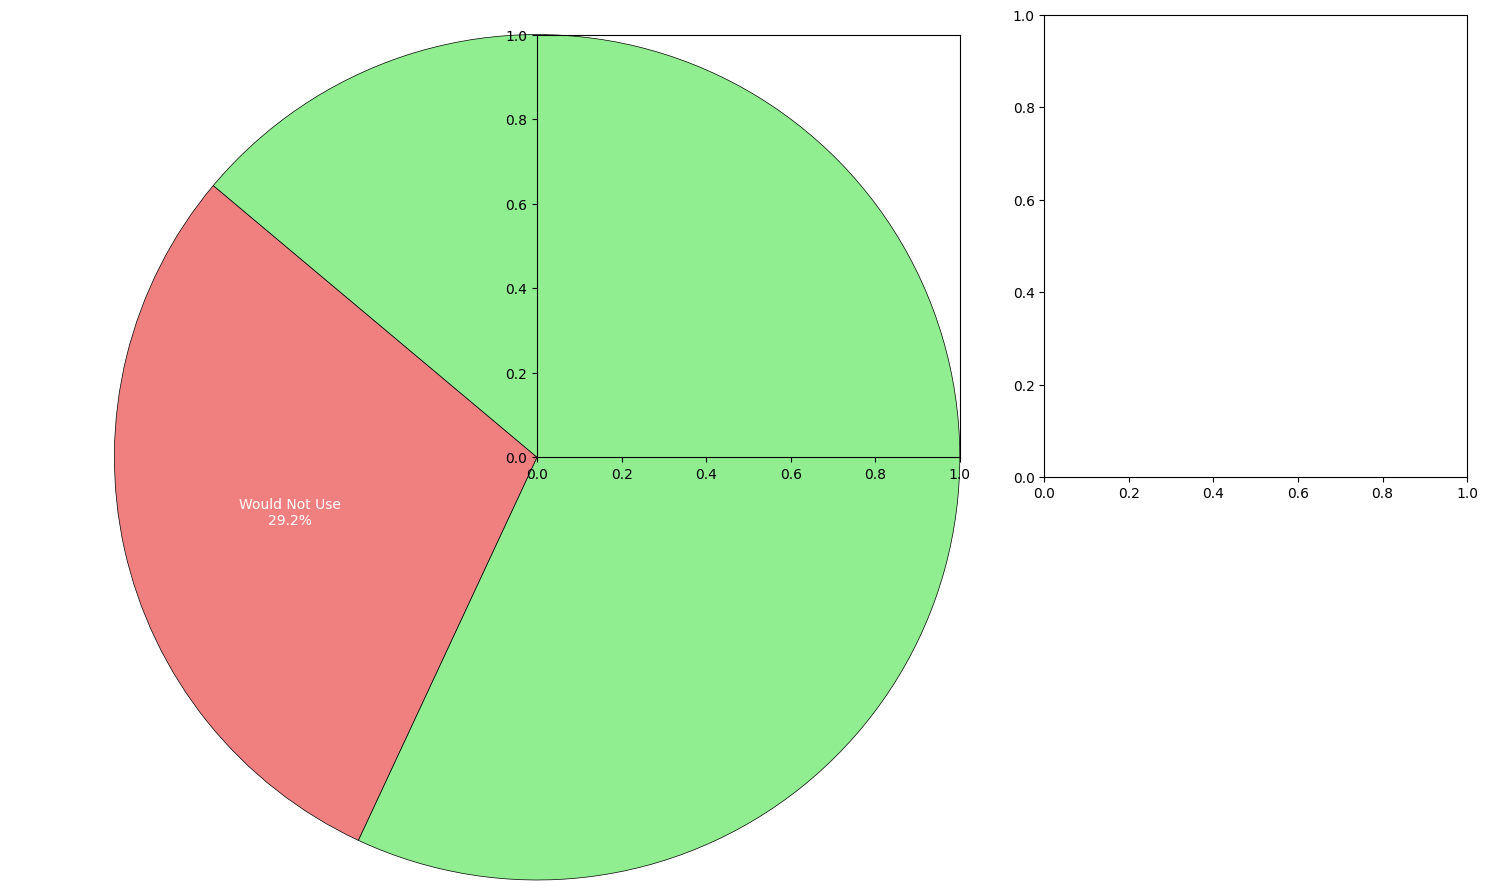

In [168]:
import matplotlib.pyplot as plt

# Data for the first round
labels = ['Would Use', 'Would Not Use']
sizes_first_round = [0.291667, 0.708333]

# Data for the second round
sizes_second_round = [0.15625, 0.84375]

# Define colors for the pie charts
colors = ['lightcoral', 'lightgreen']

# Function to format labels inside the pie chart
def func(pct, allvals, label):
    absolute = int(pct / 100. * sum(allvals))
    return f"{label}\n{pct:.1f}%"

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

wedgeprops = dict(edgecolor='black', linewidth=0.5)

# Plot the first round pie chart
wedges1, texts1, autotexts1 = ax1.pie(sizes_first_round, labels=labels, colors=colors,
                                      autopct=lambda pct: func(pct, sizes_first_round, labels[wedges1.index(wedges1[0]) if pct > 0.5 * 100 else 1]),
                                      startangle=140, textprops=dict(color="white"), wedgeprops=wedgeprops)

# Plot the second round pie chart
wedges2, texts2, autotexts2 = ax2.pie(sizes_second_round, labels=labels, colors=colors,
                                      autopct=lambda pct: func(pct, sizes_second_round, labels[wedges2.index(wedges2[0]) if pct > 0.5 * 100 else 1]),
                                      startangle=140, textprops=dict(color="white"), wedgeprops=wedgeprops)

# Customize the text properties
for text in autotexts1 + autotexts2:
    text.set_color('black')
    text.set_fontsize(12.5)

# Set titles with increased font size
ax1.set_title('Initial Usability', fontsize=18)
ax2.set_title('Usability after Revision', fontsize=18)

# Add a title for the overall figure with increased font size
fig.suptitle('Would You Use This Question in Your Course?', fontsize=20)

# Ensure that pie is drawn as a circle
ax1.axis('equal')
ax2.axis('equal')

# Adjust the spacing to create margin between the suptitle and the plots
plt.subplots_adjust(top=.85)  # Adjust the value to increase or decrease the margin

# Display the pie charts
plt.show()


In [ ]:
wedges1.index(wedges1[1])

In [169]:
second_round['Feedback_corrected'].value_counts(normalize=True)

Feedback_corrected
2    0.437500
1    0.395833
0    0.166667
Name: proportion, dtype: float64

## d

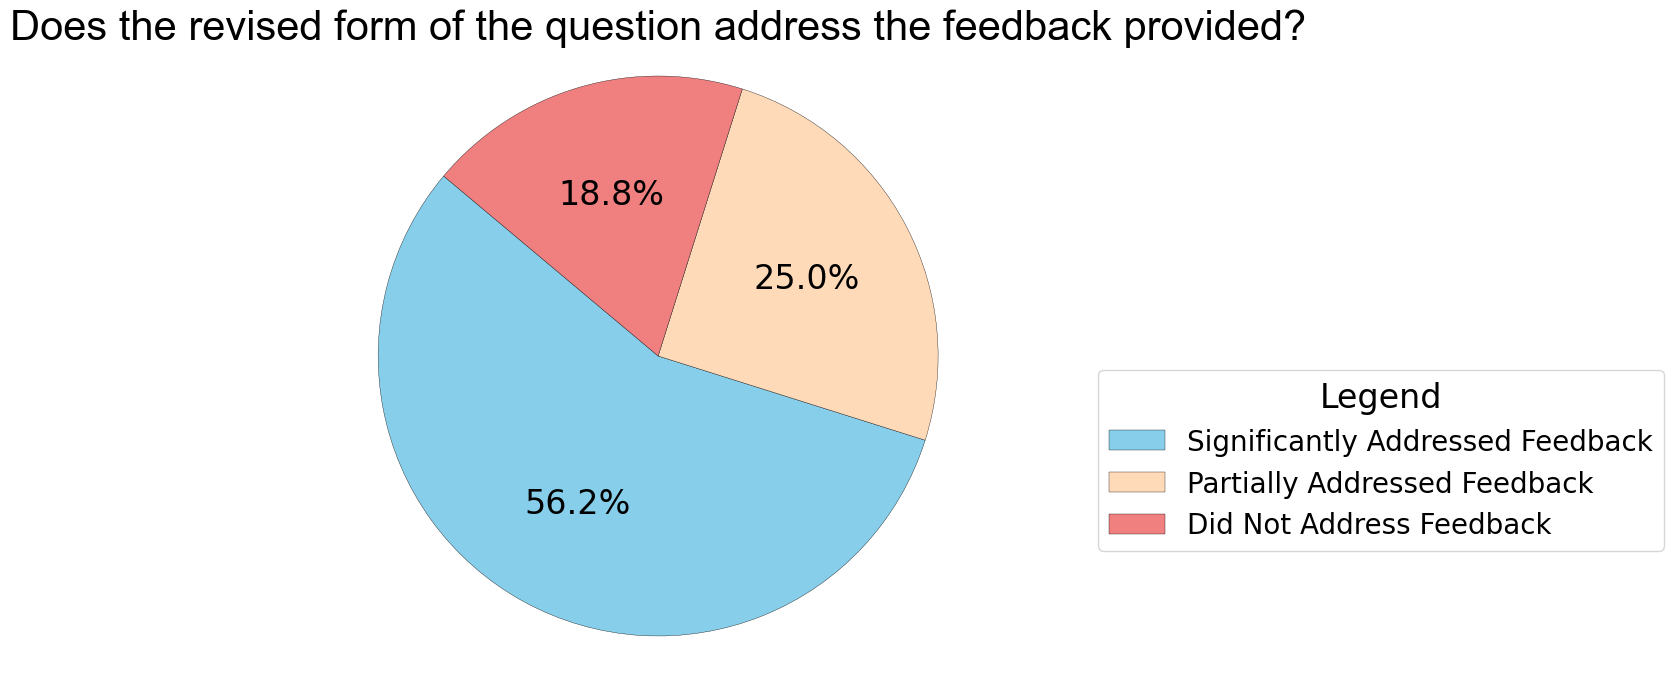

In [170]:
import matplotlib.pyplot as plt

# Data for the pie chart
labels = ['Significantly Addressed Feedback', 'Partially Addressed Feedback', 'Did Not Address Feedback']
sizes = [0.5625, 0.25, 0.1875]

# Define lighter colors for the pie chart
colors = ['skyblue', 'peachpuff', 'lightcoral']

# Function to format labels inside the pie chart
def func(pct, allvals):
    return f"{pct:.1f}%"

# Create a figure with a smaller pie chart
fig, ax = plt.subplots(figsize=(10, 8))  # Adjust the figure size

# Plot the pie chart without labels
wedges, texts, autotexts = ax.pie(sizes, labels=None, colors=colors,
                                  autopct=lambda pct: func(pct, sizes),
                                  startangle=140, textprops=dict(color="black"),
                                  radius=0.8, wedgeprops=dict(edgecolor='black', linewidth=.25))  # Black outline

# Customize the text properties
for text in autotexts:
    text.set_color('black')  # Use black for better readability
    text.set_fontsize(24)

# Set title with a larger font size
ax.set_title('Does the revised form of the question address the feedback provided?', fontsize=30, fontname='Arial')  # Increase the title font size

# Ensure that the pie is drawn as a circle
ax.axis('equal')

# Add a legend
ax.legend(wedges, labels, loc='best', title='Legend', title_fontsize=24,fontsize=20, bbox_to_anchor=(1.05, 0.5))

# Display the pie chart
plt.show()


In [171]:
first_round

Unnamed: 0  participant_ID  question_ID  Relevant  Correct_Info  \
0            0               1            1         2             2   
1            1               2            1         2             2   
2            2               3            1         2             2   
3            3               1            4         2             2   
4            4               2            4         2             2   
5            5               3            4         2             2   
6            6               1            5         2             2   
7            7               2            5         2             0   
8            8               3            5         2             2   
9            9               1            7         2             2   
10          10               2            7         2             2   
11          11               3            7         2             2   
12          12               1            9         2             2   
13          13               2            9         2             2   
14          14               3            9         2             2   
15          15               1           13         2             2   
16          16               2           13         2             2   
17          17               3           13         2             2   
18          18               1           14         2             2   
19          19               2           14         2             2   
20          20               3           14         2             2   
21          21               1           16         1             2   
22          22               2           16         2             2   
23          23               3           16         2             2   
24          24               1           18         1             2   
25          25               2           18         2             0   
26          26               3           18         2             2   
27          27               1           20         2             2   
28          28               2           20         2             2   
29          29               3           20         2             2   
30          30               1           22         2             2   
31          31               2           22         2             2   
32          32               3           22         2             2   
33          33               1           23         2             2   
34          34               2           23         2             2   
35          35               3           23         2             2   
36          36               1           24         1             2   
37          37               2           24         2             0   
38          38               3           24         2             2   
39          39               1           25         2             1   
40          40               2           25         2             2   
41          41               3           25         2             2   
42          42               1           26         2             1   
43          43               2           26         2             2   
44          44               3           26         2             2   
45          45               1           27         2             2   
46          46               2           27         2             2   
47          47               3           27         2             2   

    Grammatical  Enough_Info  Correct_Marked  One_Correct  Distinct_Option  \
0             2          2.0               2            2                2   
1             2          2.0               2            2                2   
2             2          2.0               2            2                1   
3             2          2.0               1            2                1   
4             2          2.0               1            2                2   
5             2          2.0               1            

In [172]:
first_description

NameError: name 'first_description' is not defined

In [173]:
first_description=first_round.describe()

In [174]:
second_description=second_round.describe()

In [175]:
columns_list = ['Relevant', 'Correct_Info', 'Grammatical', 'Enough_Info', 'Correct_Marked', 'One_Correct', 'Distinct_Option', 'Plausible', 'LG_Progress']

first_round_means = []
second_round_means =[]
percent_change =[]

for column in columns_list:
    first_mean = first_description[column]['mean']
    second_mean = second_description[column]['mean']
    percent = (second_mean-first_mean)/first_mean
    first_round_means.append(first_mean)
    second_round_means.append(second_mean)
    percent_change.append(percent)
    

In [176]:
first_round

Unnamed: 0  participant_ID  question_ID  Relevant  Correct_Info  \
0            0               1            1         2             2   
1            1               2            1         2             2   
2            2               3            1         2             2   
3            3               1            4         2             2   
4            4               2            4         2             2   
5            5               3            4         2             2   
6            6               1            5         2             2   
7            7               2            5         2             0   
8            8               3            5         2             2   
9            9               1            7         2             2   
10          10               2            7         2             2   
11          11               3            7         2             2   
12          12               1            9         2             2   
13          13               2            9         2             2   
14          14               3            9         2             2   
15          15               1           13         2             2   
16          16               2           13         2             2   
17          17               3           13         2             2   
18          18               1           14         2             2   
19          19               2           14         2             2   
20          20               3           14         2             2   
21          21               1           16         1             2   
22          22               2           16         2             2   
23          23               3           16         2             2   
24          24               1           18         1             2   
25          25               2           18         2             0   
26          26               3           18         2             2   
27          27               1           20         2             2   
28          28               2           20         2             2   
29          29               3           20         2             2   
30          30               1           22         2             2   
31          31               2           22         2             2   
32          32               3           22         2             2   
33          33               1           23         2             2   
34          34               2           23         2             2   
35          35               3           23         2             2   
36          36               1           24         1             2   
37          37               2           24         2             0   
38          38               3           24         2             2   
39          39               1           25         2             1   
40          40               2           25         2             2   
41          41               3           25         2             2   
42          42               1           26         2             1   
43          43               2           26         2             2   
44          44               3           26         2             2   
45          45               1           27         2             2   
46          46               2           27         2             2   
47          47               3           27         2             2   

    Grammatical  Enough_Info  Correct_Marked  One_Correct  Distinct_Option  \
0             2          2.0               2            2                2   
1             2          2.0               2            2                2   
2             2          2.0               2            2                1   
3             2          2.0               1            2                1   
4             2          2.0               1            2                2   
5             2          2.0               1            

In [177]:
second_round_means

[2.0,
 2.0,
 1.8125,
 1.8333333333333333,
 1.9166666666666667,
 1.8541666666666667,
 1.7872340425531914,
 1.7659574468085106,
 1.6875]

In [178]:
second_round_means

[2.0,
 2.0,
 1.8125,
 1.8333333333333333,
 1.9166666666666667,
 1.8541666666666667,
 1.7872340425531914,
 1.7659574468085106,
 1.6875]

In [179]:
second_round_means

[2.0,
 2.0,
 1.8125,
 1.8333333333333333,
 1.9166666666666667,
 1.8541666666666667,
 1.7872340425531914,
 1.7659574468085106,
 1.6875]

In [180]:
first_round_means

[1.9375,
 1.8333333333333333,
 1.9166666666666667,
 1.702127659574468,
 1.7916666666666667,
 1.9375,
 1.8125,
 1.625,
 1.8125]

In [181]:
for item in percent_change:
    print(f"{item * 100:.2f}")


3.23
9.09
-5.43
7.71
6.98
-4.30
-1.39
8.67
-6.90


<h2 style="text-align: center;">Question Quality Comparison</h2>

| Quality Measure         | Initial Average | Revised Average |
|-------------------------|-----------------|-----------------|
| Relevant                | 1.938           | 2.000 (<span style="color:blue">&uarr;</span> 3.23%) |
| Correct Information     | 1.833           | 2.000 (<span style="color:blue">&uarr;</span> 9.09%)          |
| Grammatical             | 1.917           | 1.844 (<span style="color:red">&darr;</span> -3.80%)          |
| Enough Information      | 1.702           | 1.906 (<span style="color:blue">&uarr;</span> 11.99%)          |
| Correct Answer Marked   | 1.792           | 2.000 (<span style="color:blue">&uarr;</span> 11.63%)          |
| One Correct Answer      | 1.938           | 1.938 ( - 0.00%)          |
| Distinct Options        | 1.813           | 1.875 (<span style="color:blue">&uarr;</span> 3.45%)          |
| Plausible Distractors   | 1.625           | 1.813 (<span style="color:blue">&uarr;</span> 11.54%)          |
| Learning Goal Progress  | 1.813           | 1.813 ( - 0.00%)          |
<span style="color:blue">

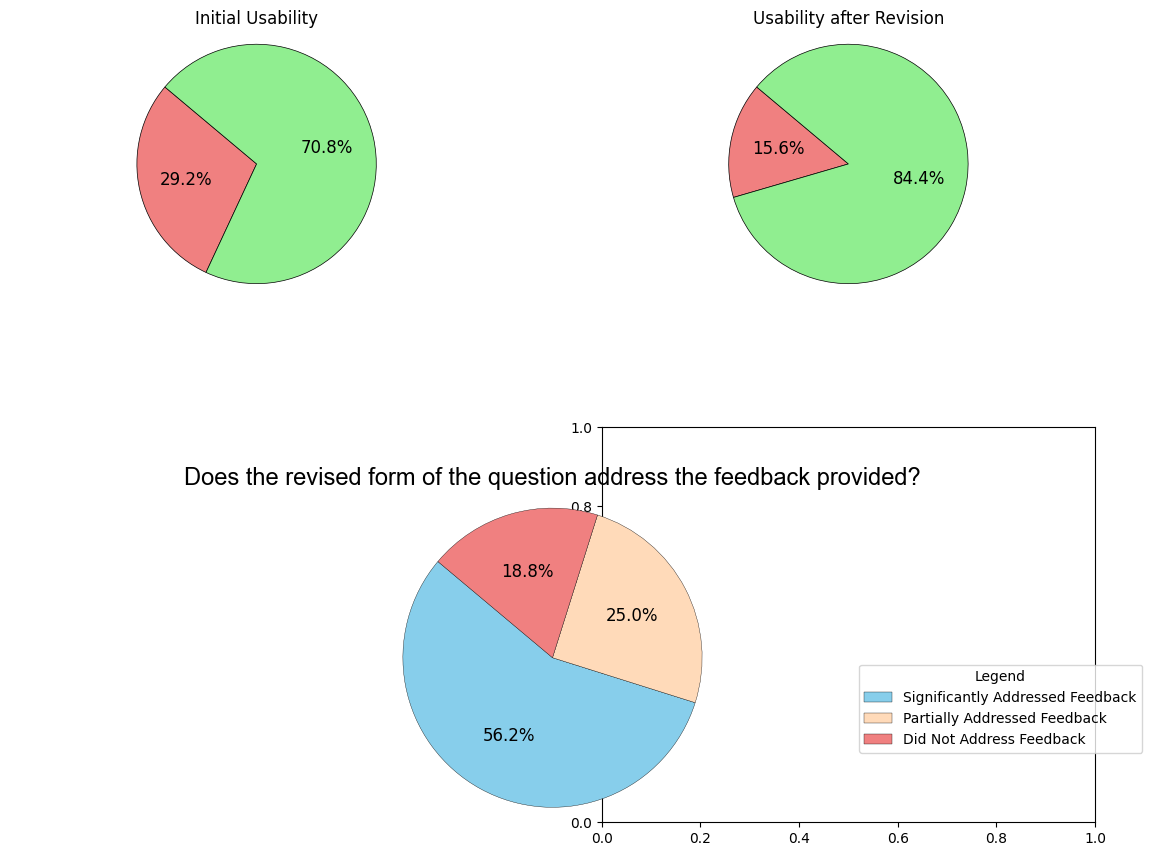

In [182]:
import matplotlib.pyplot as plt

# Data for the first round
labels = ['Would Use', 'Would Not Use']
sizes_first_round = [0.291667, 0.708333]

# Data for the second round
sizes_second_round = [0.15625, 0.84375]

# Data for the third pie chart
labels_feedback = ['Significantly Addressed Feedback', 'Partially Addressed Feedback', 'Did Not Address Feedback']
sizes_feedback = [0.5625, 0.25, 0.1875]

# Define colors for the pie charts
colors_first_second = ['lightcoral', 'lightgreen']
colors_feedback = ['skyblue', 'peachpuff', 'lightcoral']

# Function to format labels inside the pie chart
def func(pct, allvals):
    return f"{pct:.1f}%"

# Create a figure with three subplots: 2 on top, 1 on the bottom
fig, axs = plt.subplots(2, 2, figsize=(14, 10), gridspec_kw={'height_ratios': [1, 1.5]})

# Remove the empty subplot to make the third chart span both columns
axs[1, 0].remove()
ax_feedback = fig.add_subplot(2, 1, 2)

wedgeprops = dict(edgecolor='black', linewidth=0.5)

# Plot the first round pie chart (top left)
wedges1, texts1, autotexts1 = axs[0, 0].pie(sizes_first_round, labels=labels, colors=colors_first_second,
                                            autopct=lambda pct: func(pct, sizes_first_round),
                                            startangle=140, textprops=dict(color="white"), wedgeprops=wedgeprops)

# Plot the second round pie chart (top right)
wedges2, texts2, autotexts2 = axs[0, 1].pie(sizes_second_round, labels=labels, colors=colors_first_second,
                                            autopct=lambda pct: func(pct, sizes_second_round),
                                            startangle=140, textprops=dict(color="white"), wedgeprops=wedgeprops)

# Plot the third pie chart (bottom)
wedges3, texts3, autotexts3 = ax_feedback.pie(sizes_feedback, labels=None, colors=colors_feedback,
                                              autopct=lambda pct: func(pct, sizes_feedback),
                                              startangle=140, textprops=dict(color="black"),
                                              radius=0.8, wedgeprops=dict(edgecolor='black', linewidth=.25))

# Customize text properties for the first and second pie charts
for text in autotexts1 + autotexts2:
    text.set_color('black')
    text.set_fontsize(12)

# Customize text properties for the third pie chart
for text in autotexts3:
    text.set_color('black')
    text.set_fontsize(12)

# Set titles for each subplot
axs[0, 0].set_title('Initial Usability')
axs[0, 1].set_title('Usability after Revision')
ax_feedback.set_title('Does the revised form of the question address the feedback provided?', fontsize=17, fontname='Arial')

# Add a legend to the third pie chart
ax_feedback.legend(wedges3, labels_feedback, loc='best', title='Legend', fontsize=10, bbox_to_anchor=(1.05, 0.5))

# Ensure that all pies are drawn as circles
for ax in [axs[0, 0], axs[0, 1], ax_feedback]:
    ax.axis('equal')  # Ensures pie charts are circular
    ax.axis('off')    # Turns off the axes, preventing any unwanted display

# Adjust the spacing
plt.subplots_adjust(top=0.9, hspace=0.4)  # Adjust vertical space

# Display the pie charts
plt.show()


In [183]:
# Experiment 2 with Bloom's and Quality Score Breakdown
# Sankey Diagram side by side for experiment 2
# Experiment 1 effect of learning goals
    # Box plot for quality score based on learning goals
    # Compare accuracy for questions using learning goals and not
# Experiment 2 Pi Chart for learning goals


In [184]:
# Experiment 2 Pi Chart for learning goals

In [185]:
first_round.groupby(["LG_Progress"]).size() / len(first_round)


LG_Progress
0    0.020833
1    0.145833
2    0.833333
dtype: float64

In [186]:
second_round.groupby(["LG_Progress"]).size() / len(second_round) 



LG_Progress
0    0.0625
1    0.1875
2    0.7500
dtype: float64

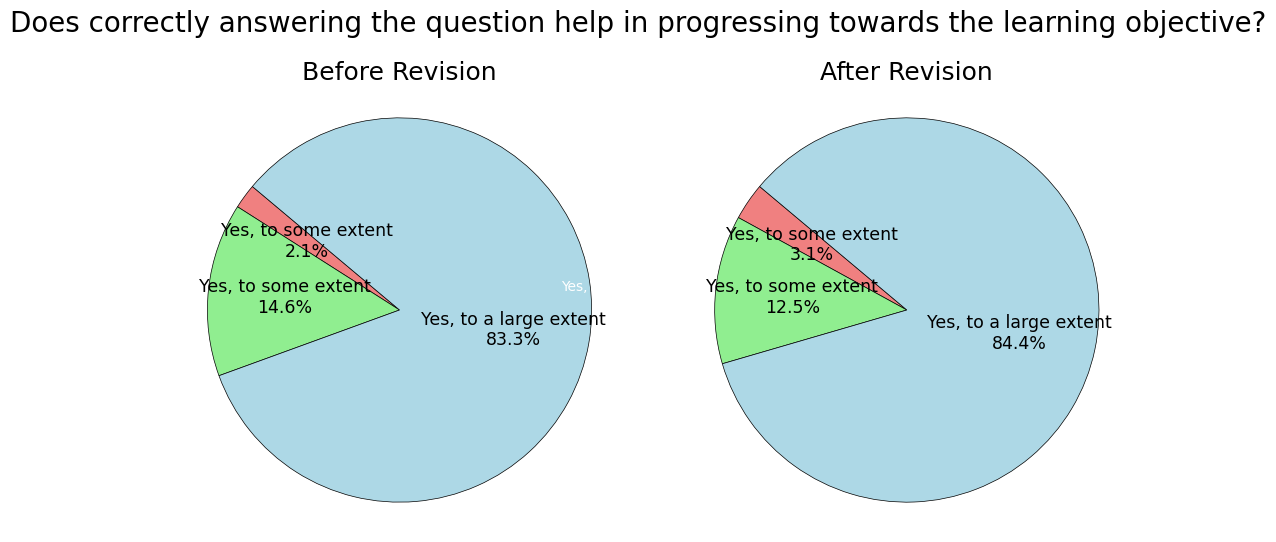

In [187]:
import matplotlib.pyplot as plt

# Data for the first round
labels = ['Yes, to a large extent', 'Yes, to some extent', 'No, it does not']
sizes_first_round = [0.020833, 0.145833, 0.833333]

# Data for the second round
sizes_second_round = [0.03125, 0.12500, 0.84375]

# Define colors for the pie charts
colors = ['lightcoral', 'lightgreen', "lightblue"]

# Function to format labels inside the pie chart
def func(pct, allvals, label):
    absolute = int(pct / 100. * sum(allvals))
    return f"{label}\n{pct:.1f}%"

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

wedgeprops = dict(edgecolor='black', linewidth=0.5)

# Plot the first round pie chart
wedges1, texts1, autotexts1 = ax1.pie(sizes_first_round, labels=labels, colors=colors,
                                      autopct=lambda pct: func(pct, sizes_first_round, labels[wedges1.index(wedges1[0]) if pct > 0.5 * 100 else 1]),
                                      startangle=140, textprops=dict(color="white"), wedgeprops=wedgeprops)

# Plot the second round pie chart
wedges2, texts2, autotexts2 = ax2.pie(sizes_second_round, labels=labels, colors=colors,
                                      autopct=lambda pct: func(pct, sizes_second_round, labels[wedges2.index(wedges2[0]) if pct > 0.5 * 100 else 1]),
                                      startangle=140, textprops=dict(color="white"), wedgeprops=wedgeprops)

# Customize the text properties
for text in autotexts1 + autotexts2:
    text.set_color('black')
    text.set_fontsize(12.5)

# Set titles with increased font size
ax1.set_title('Before Revision', fontsize=18)
ax2.set_title('After Revision', fontsize=18)

# Add a title for the overall figure with increased font size
fig.suptitle('Does correctly answering the question help in progressing towards the learning objective?', fontsize=20)

# Ensure that pie is drawn as a circle
ax1.axis('equal')
ax2.axis('equal')

# Adjust the spacing to create margin between the suptitle and the plots
plt.subplots_adjust(top=.85)  # Adjust the value to increase or decrease the margin

# Display the pie charts
plt.show()


In [188]:
# Can fix but there is very little change

In [189]:
# Experiment 1 learning goals  difference in quality scores


In [190]:
question_evaluation_secondary

Unnamed: 0  participant_ID  question_ID  LG_Progress  Relevant  \
0             0               1           34          NaN         2   
1             1               2           34          NaN         2   
2             2               3           34          NaN         2   
3             3               1           32          NaN         2   
4             4               2           32          NaN         2   
..          ...             ...          ...          ...       ...   
123         123               8           70          2.0         2   
124         124               7           73          2.0         1   
125         125               8           73          2.0         2   
126         126               7           74          2.0         1   
127         127               8           74          2.0         2   

     Correct_Info  Grammatical  Enough_Info  Correct_Marked  One_Correct  ...  \
0               2            2            2               2            2  ...   
1               2            1            2               2            2  ...   
2               2            1            2               2            2  ...   
3               2            2            2               2            2  ...   
4               2            1            2               2            2  ...   
..            ...          ...          ...             ...          ...  ...   
123             2            2            2               2            2  ...   
124             2            2            2               2            2  ...   
125             2            2            2               2            2  ...   
126             2            2            2               2            2  ...   
127             2            2            2               2            2  ...   

                                               options  correct_answer  \
0    A. Compound X B. Compound Y C. Both X and Y D....               A   
1    A. Compound X B. Compound Y C. Both X and Y D....               A   
2    A. Compound X B. Compound Y C. Both X and Y D....               A   
3    A. Compound F will gain electrons B. Compound ...               B   
4    A. Compound F will gain electrons B. Compound ...               B   
..                                                 ...             ...   
123  A. The production of ATP would increase.\nB. T...               B   
124  A. The catalytic histidine is essential for th...               A   
125  A. The catalytic histidine is essential for th...               A   
126  A. The oxidation of G3P releases energy that i...               C   
127  A. The oxidation of G3P releases energy that i...               C   

                                           explanation  textbook_section  \
0    Compound X acts as the reductant because it do...                 1   
1    Compound X acts as the reductant because it do...                 1   
2    Compound X acts as the reductant because it do...                 1   
3    If Compound F acts similarly to Compound C and...                 1   
4    If Compound F acts similarly to Compound C and...                 1   
..                                                 ...               ...   
123  The enzyme glyceraldehyde 3-phosphate dehydrog...                 4   
124  The catalytic histidine in glyceraldehyde-3-ph...                 4   
125  The catalytic histidine in glyceraldehyde-3-ph...                 4   
126  The correct answer is C. In the reaction catal...                 4   
127  The correct answer is C. In the reaction catal...                 4   

                                              analysis  \
0                                                  NaN   
1                                                  NaN   
2                                                  NaN   
3                                                  NaN   
4                                                  NaN   
..                           

In [191]:
# DataFrame with NaN values in LG_Progress
df_nan = question_evaluation_secondary[question_evaluation_secondary['LG_Progress'].isna()]

# DataFrame with non-NaN values in LG_Progress
df_not_nan = question_evaluation_secondary[~question_evaluation_secondary['LG_Progress'].isna()]


In [192]:
average_quality_score_nan = df_nan['quality_score'].mean()
print(average_quality_score_nan)


15.65625


In [193]:
means_no_lg = df_nan.groupby('Objective_Label')['quality_score'].mean()

In [194]:
means_no_lg

Objective_Label
Analyze       14.750000
Apply         16.708333
Remember      16.125000
Understand    15.041667
Name: quality_score, dtype: float64

In [195]:
average_quality_score_lg = df_not_nan['quality_score'].mean()
print(average_quality_score_lg)

15.5


In [196]:
means_lg = df_not_nan.groupby('Objective_Label')['quality_score'].mean()

In [197]:
means_lg

Objective_Label
Analyze       17.00
Apply         14.75
Remember      15.25
Understand    15.00
Name: quality_score, dtype: float64

In [198]:
# Experiment 1 learning goals diffeerence in accuracy

In [199]:
df_nan.columns

Index(['Unnamed: 0', 'participant_ID', 'question_ID', 'LG_Progress',
       'Relevant', 'Correct_Info', 'Grammatical', 'Enough_Info',
       'Correct_Marked', 'One_Correct', 'Distinct_Option', 'Plausible',
       'Misconceptions', 'Usable', 'Teacher_Blooms', 'objective', 'strategy',
       'scenario', 'question', 'options', 'correct_answer', 'explanation',
       'textbook_section', 'analysis', 'Learning Goal', 'quality_score',
       'quality_score_percent', 'Objective_Label', 'Teacher_Blooms_Label'],
      dtype='object')

In [200]:
performancePrinter(df_nan['objective'], df_nan['Teacher_Blooms'])

Accuracy Score ->  0.3958333333333333
Kappa Score ->  0.19444444444444442
ROC AUC Score -> Cannot calculate (probability scores required)
F1 Score ->  0.335656321440113
Classification report -> 
               precision    recall  f1-score   support

           1       0.44      0.79      0.57        24
           2       0.26      0.38      0.31        24
           3       0.53      0.42      0.47        24
           4       0.00      0.00      0.00        24

    accuracy                           0.40        96
   macro avg       0.31      0.40      0.34        96
weighted avg       0.31      0.40      0.34        96



/opt/anaconda3/envs/Diss/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/anaconda3/envs/Diss/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/anaconda3/envs/Diss/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



KeyError: 4

In [ ]:
performancePrinter(df_not_nan['objective'], df_not_nan['Teacher_Blooms'])

In [201]:
## Now significance
first_round['quality_score']

KeyError: 'quality_score'

In [ ]:
second_round['quality_score']

In [202]:
first_round

Unnamed: 0  participant_ID  question_ID  Relevant  Correct_Info  \
0            0               1            1         2             2   
1            1               2            1         2             2   
2            2               3            1         2             2   
3            3               1            4         2             2   
4            4               2            4         2             2   
5            5               3            4         2             2   
6            6               1            5         2             2   
7            7               2            5         2             0   
8            8               3            5         2             2   
9            9               1            7         2             2   
10          10               2            7         2             2   
11          11               3            7         2             2   
12          12               1            9         2             2   
13          13               2            9         2             2   
14          14               3            9         2             2   
15          15               1           13         2             2   
16          16               2           13         2             2   
17          17               3           13         2             2   
18          18               1           14         2             2   
19          19               2           14         2             2   
20          20               3           14         2             2   
21          21               1           16         1             2   
22          22               2           16         2             2   
23          23               3           16         2             2   
24          24               1           18         1             2   
25          25               2           18         2             0   
26          26               3           18         2             2   
27          27               1           20         2             2   
28          28               2           20         2             2   
29          29               3           20         2             2   
30          30               1           22         2             2   
31          31               2           22         2             2   
32          32               3           22         2             2   
33          33               1           23         2             2   
34          34               2           23         2             2   
35          35               3           23         2             2   
36          36               1           24         1             2   
37          37               2           24         2             0   
38          38               3           24         2             2   
39          39               1           25         2             1   
40          40               2           25         2             2   
41          41               3           25         2             2   
42          42               1           26         2             1   
43          43               2           26         2             2   
44          44               3           26         2             2   
45          45               1           27         2             2   
46          46               2           27         2             2   
47          47               3           27         2             2   

    Grammatical  Enough_Info  Correct_Marked  One_Correct  Distinct_Option  \
0             2          2.0               2            2                2   
1             2          2.0               2            2                2   
2             2          2.0               2            2                1   
3             2          2.0               1            2                1   
4             2          2.0               1            2                2   
5             2          2.0               1            

In [203]:
second_round['quality_score']

KeyError: 'quality_score'

In [204]:
import numpy as np
from scipy.stats import ttest_ind

v1 = first_round["quality_score"]
v2 = second_round["quality_score"]

res = ttest_ind(v1, v2)

print(res)

KeyError: 'quality_score'

In [ ]:
first_round.columns
f

In [205]:
first_round['quality_score']

KeyError: 'quality_score'

In [206]:
columns_to_average = [
    'Relevant', 'Correct_Info', 'Grammatical', 'Enough_Info', 'Correct_Marked',
    'One_Correct', 'Distinct_Option', 'Plausible', 'Usable', 'LG_Progress', 'quality_score'
]

# Creating the new dataframe with means
first_round_by_question = first_round.groupby('question_ID')[columns_to_average].mean().reset_index()
second_round_by_question = second_round.groupby('question_ID')[columns_to_average].mean().reset_index()


first_round_by_question

KeyError: "Columns not found: 'quality_score'"

In [207]:
second_round_by_question

NameError: name 'second_round_by_question' is not defined

In [208]:
import numpy as np
from scipy.stats import ttest_ind

v1 = first_round_by_question["quality_score"]
v2 = second_round_by_question["quality_score"]

res = ttest_ind(v1, v2)

print(res)

NameError: name 'first_round_by_question' is not defined

In [209]:
import numpy as np
from scipy.stats import ttest_ind

v1 = first_round_by_question["Relevant"]
v2 = second_round_by_question["Relevant"]

res = ttest_ind(v2, v1)

print("Relevant")
print(res)

v1 = first_round_by_question["Correct_Info"]
v2 = second_round_by_question["Correct_Info"]

res = ttest_ind(v2, v1)
print("Correct_Info ")
print(res)

v1 = first_round_by_question["Grammatical"]
v2 = second_round_by_question["Grammatical"]

res = ttest_ind(v2, v1)
print("Grammatical ")
print(res)

v1 = first_round_by_question["Enough_Info"]
v2 = second_round_by_question["Enough_Info"]

res = ttest_ind(v2, v1)
print("Enough_Info ")
print(res)

v1 = first_round_by_question["Correct_Marked"]
v2 = second_round_by_question["Correct_Marked"]

res = ttest_ind(v2, v1)
print("Correct_Marked ")
print(res)

v1 = first_round_by_question["One_Correct"]
v2 = second_round_by_question["One_Correct"]

res = ttest_ind(v2, v1)
print("One_correct ")
print(res)

v1 = first_round_by_question["Distinct_Option"]
v2 = second_round_by_question["Distinct_Option"]

res = ttest_ind(v2, v1)
print("Distint ")
print(res)

v1 = first_round_by_question["Plausible"]
v2 = second_round_by_question["Plausible"]

res = ttest_ind(v2, v1)
print("Plausible ")
print(res)

v1 = first_round_by_question["Usable"]
v2 = second_round_by_question["Usable"]

res = ttest_ind(v2, v1)
print("Usable ")
print(res)


v1 = first_round_by_question["LG_Progress"]
v2 = second_round_by_question["LG_Progress"]

res = ttest_ind(v2, v1)
print("LG_Progress ")
print(res)


NameError: name 'first_round_by_question' is not defined

In [210]:


v1 = first_round_by_question["quality_score"]
v2 = second_round_by_question["quality_score"]

res = ttest_ind(v2, v1)

print(res)

NameError: name 'first_round_by_question' is not defined

In [211]:
import numpy as np
from scipy.stats import ttest_ind

v1 = first_round["Relevant"]
v2 = second_round["Relevant"]

res = ttest_ind(v1, v2)

print("Relevant")
print(res)

v1 = first_round["Correct_Info"]
v2 = second_round["Correct_Info"]

res = ttest_ind(v1, v2)
print("Correct_Info ")
print(res)

v1 = first_round["Grammatical"]
v2 = second_round["Grammatical"]

res = ttest_ind(v1, v2)
print("Grammatical ")
print(res)

v1 = first_round["Enough_Info"]
v2 = second_round["Enough_Info"]

res = ttest_ind(v1, v2)
print("Enough_Info ")
print(res)

v1 = first_round["Correct_Marked"]
v2 = second_round["Correct_Marked"]

res = ttest_ind(v1, v2)
print("Correct_Marked ")
print(res)

v1 = first_round["One_Correct"]
v2 = second_round["One_Correct"]

res = ttest_ind(v1, v2)
print("One_correct ")
print(res)

v1 = first_round["Distinct_Option"]
v2 = second_round["Distinct_Option"]

res = ttest_ind(v1, v2)
print("Distint ")
print(res)

v1 = first_round["Plausible"]
v2 = second_round["Plausible"]

res = ttest_ind(v1, v2)
print("Plausible ")
print(res)

v1 = first_round["Usable"]
v2 = second_round["Usable"]

res = ttest_ind(v1, v2)
print("Usable ")
print(res)


v1 = first_round["LG_Progress"]
v2 = second_round["LG_Progress"]

res = ttest_ind(v1, v2)
print("LG_Progress ")
print(res)


Relevant
TtestResult(statistic=nan, pvalue=nan, df=nan)
Correct_Info 
TtestResult(statistic=-2.2242680641174157, pvalue=0.02852421681209504, df=94.0)
Grammatical 
TtestResult(statistic=1.2007155330930992, pvalue=0.2328785749261698, df=94.0)
Enough_Info 
TtestResult(statistic=nan, pvalue=nan, df=nan)
Correct_Marked 
TtestResult(statistic=-1.341640786499874, pvalue=0.1829446748749072, df=94.0)
One_correct 
TtestResult(statistic=1.2048806794606053, pvalue=0.23127407431092423, df=94.0)
Distint 
TtestResult(statistic=nan, pvalue=nan, df=nan)
Plausible 
TtestResult(statistic=nan, pvalue=nan, df=nan)
Usable 
TtestResult(statistic=0.43621485624599865, pvalue=0.6636810797746879, df=94.0)
LG_Progress 
TtestResult(statistic=1.1728639120109208, pvalue=0.24381399313290625, df=94.0)


/opt/anaconda3/envs/Diss/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.



In [212]:
#Compute correlation between all 16 pairs before and after revision
#Teacher Blooms vs Objective


In [213]:
second_round

Unnamed: 0  participant_ID  question_ID  Relevant  Correct_Info  \
0            0               1            1       2.0             2   
1            1               2            1       2.0             2   
2            2               3            1       2.0             2   
3            0               1            4       2.0             2   
4            1               2            4       2.0             2   
5            2               3            4       2.0             2   
6            0               1            5       2.0             2   
7            1               2            5       2.0             2   
8            2               3            5       2.0             2   
9            0               1            7       2.0             2   
10           1               2            7       2.0             2   
11           2               3            7       2.0             2   
12           0               1            9       2.0             2   
13           1               2            9       2.0             2   
14           2               3            9       2.0             2   
15           0               1           13       2.0             2   
16           1               2           13       2.0             2   
17           2               3           13       2.0             2   
18           0               1           14       2.0             2   
19           1               2           14       2.0             2   
20           2               3           14       2.0             2   
21           0               1           16       2.0             2   
22           1               2           16       2.0             2   
23           2               3           16       2.0             2   
24           0               1           18       2.0             2   
25           1               2           18       2.0             2   
26           2               3           18       2.0             2   
27           0               1           20       2.0             2   
28           1               2           20       2.0             2   
29           2               3           20       NaN             2   
30           0               1           22       2.0             2   
31           1               2           22       2.0             2   
32           2               3           22       2.0             2   
33           0               1           23       2.0             2   
34           1               2           23       2.0             2   
35           2               3           23       2.0             2   
36           0               1           24       2.0             2   
37           1               2           24       2.0             2   
38           2               3           24       2.0             2   
39           0               1           25       2.0             2   
40           1               2           25       2.0             2   
41           2               3           25       2.0             2   
42           0               1           26       2.0             2   
43           1               2           26       2.0             2   
44           2               3           26       2.0             2   
45           0               1           27       2.0             2   
46           1               2           27       2.0             2   
47           2               3           27       2.0             2   

    Grammatical  Enough_Info  Correct_Marked  One_Correct  Distinct_Option  \
0             2            2               2            2              1.0   
1             2            2               2            2              2.0   
2             2            2               2            2              2.0   
3             2            2               2            2              2.0   
4             1            2               2            2              2.0   
5             2            2               2            

In [214]:
r1, p1 = scipy.stats.pearsonr(first_round['Teacher_Blooms'], first_round['objective'])
r1, p1

(0.6452415312604779, 7.384372080023702e-07)

In [215]:
r2, p2 =scipy.stats.pearsonr(second_round["Teacher_Blooms"], second_round["objective"])
r2, p2

(0.779603348035809, 6.634583378135896e-11)

In [216]:
#Computer correlation for each rater in round 1 and round 2

# Identify repeated raters in round 1 vs round 2

In [217]:
rater1= first_round[first_round["participant_ID"]==1]
rater2= first_round[first_round["participant_ID"]==2]
rater3= first_round[first_round["participant_ID"]==3]

r1, p1 = scipy.stats.pearsonr(rater1["Teacher_Blooms"], rater1["objective"])
r2, p2 = scipy.stats.pearsonr(rater2["Teacher_Blooms"], rater2["objective"])
r3, p3 = scipy.stats.pearsonr(rater3["Teacher_Blooms"], rater3["objective"])

In [218]:
r1, p1

(0.5962847939999438, 0.014771636573007965)

In [219]:
r2, p2

(0.8252100701754845, 8.305747081855972e-05)

In [220]:
r3, p3

(0.5329480400990121, 0.03353292578624219)

In [221]:
rater1= first_round[first_round["participant_ID"]==1]
rater2= first_round[first_round["participant_ID"]==2]
rater3= first_round[first_round["participant_ID"]==3]

r1, p1 = scipy.stats.spearmanr(rater1["Teacher_Blooms"], rater1["objective"])
r2, p2 = scipy.stats.spearmanr(rater2["Teacher_Blooms"], rater2["objective"])
r3, p3 = scipy.stats.spearmanr(rater3["Teacher_Blooms"], rater3["objective"])

In [222]:
r1, p1

(0.5902084851809942, 0.01609182216258869)

In [223]:
r2, p2

(0.8258781518968789, 8.10131033272176e-05)

In [224]:
r3,p3

(0.5167050676973539, 0.0404286196157314)

In [225]:
# Rater 3 from round 1 is K, identified as rater 1 in round 2
rater3_round2 = second_round[second_round["participant_ID"]==1]
# Rater 2 from round 1 is Mi, identified as rater 2 in round 2
rater2_round2 = second_round[second_round["participant_ID"]==2]

In [226]:
r3r2, r3p2 = scipy.stats.pearsonr(rater3_round2["Teacher_Blooms"], rater3_round2["objective"])
r2r2, r2p2 = scipy.stats.pearsonr(rater2_round2["Teacher_Blooms"], rater2_round2["objective"])

In [227]:
r3r2, r3p2


(0.9219544457292888, 3.8404007448993497e-07)

In [228]:
r2r2, r2p2

(0.7888106377466155, 0.00028152562482114347)

In [229]:
r3r2, r3p2 = scipy.stats.spearmanr(rater3_round2["Teacher_Blooms"], rater3_round2["objective"])
r2r2, r2p2 = scipy.stats.spearmanr(rater2_round2["Teacher_Blooms"], rater2_round2["objective"])

In [230]:
r3r2, r3p2


(0.9418433869371499, 5.1694464162793534e-08)

In [231]:
r2r2, r2p2

(0.7756717518813397, 0.0004136221350651033)

In [162]:
#Calculate Spearman's rank correlation for experiment 2 to capture ordinal variables

In [183]:
scipy.stats.spearmanr(first_round['Teacher_Blooms'], first_round['objective'])

SignificanceResult(statistic=0.6321156420969805, pvalue=1.443221202474773e-06)

In [184]:
scipy.stats.spearmanr(second_round['Teacher_Blooms'], second_round['objective'])

SignificanceResult(statistic=0.8411098168960072, pvalue=1.6676601585885481e-09)